# Objective

Analyze the customers' data and information to provide recommendations to the Policy Maker and Marketing Team and also build a model to predict the potential customer who is going to purchase the newly introduced travel package.

We have no information on the new package besides its name, so to complete this task I will have to build profiles and predict the purchases of each package. This will allow me to offer advice for new packages as well.

## Data Dictionary

Customer details:

1. CustomerID: Unique customer ID
2. ProdTaken: Whether the customer has purchased a package or not (0: No, 1: Yes)
3. Age: Age of customer
4. TypeofContact: How customer was contacted (Company Invited or Self Inquiry)
5. CityTier: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. Tier 1 > Tier 2 > Tier 3
6. Occupation: Occupation of customer
7. Gender: Gender of customer
8. NumberOfPersonVisiting: Total number of persons planning to take the trip with the customer
9. PreferredPropertyStar: Preferred hotel property rating by customer
10. MaritalStatus: Marital status of customer
11. NumberOfTrips: Average number of trips in a year by customer
12. Passport: The customer has a passport or not (0: No, 1: Yes)
13. OwnCar: Whether the customers own a car or not (0: No, 1: Yes)
14. NumberOfChildrenVisiting: Total number of children with age less than 5 planning to take the trip with the customer
15. Designation: Designation of the customer in the current organization
16. MonthlyIncome: Gross monthly income of the customer

Customer interaction data: 

* PitchSatisfactionScore: Sales pitch satisfaction score
* ProductPitched: Product pitched by the salesperson
* NumberOfFollowups: Total number of follow-ups has been done by the salesperson after the sales pitch
* DurationOfPitch: Duration of the pitch by a salesperson to the customer


In [1]:
# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import sklearn
import sys
# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries to split data
from sklearn.model_selection import train_test_split


# Libraries to import decision tree classifier and different ensemble classifiers
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
# from mlxtend.classifier import StackingClassifier

# Libtune to tune model, get different metric scores
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score


#For imputing values
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [2]:
data = pd.read_excel('Tourism2.xlsx')

In [3]:
df = data.copy()

In [4]:
df.shape

(4888, 20)

There are 4888 customers with 20 columns describing each customer.

In [5]:
df.head(5)

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


Customer ID can reasonably be a unique identifier for each customer. This means I can keep it while I look for duplicates.

In [6]:
#checking for duplicates
df.duplicated().sum()

0

There are no duplicates as no unique identifier is repeated. Now I can just drop it.

In [7]:
df.drop(['CustomerID'],axis=1,inplace=True)

In [8]:
#Now to check out data types and look for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4888 non-null   int64  
 1   Age                       4662 non-null   float64
 2   TypeofContact             4863 non-null   object 
 3   CityTier                  4888 non-null   int64  
 4   DurationOfPitch           4637 non-null   float64
 5   Occupation                4888 non-null   object 
 6   Gender                    4888 non-null   object 
 7   NumberOfPersonVisiting    4888 non-null   int64  
 8   NumberOfFollowups         4843 non-null   float64
 9   ProductPitched            4888 non-null   object 
 10  PreferredPropertyStar     4862 non-null   float64
 11  MaritalStatus             4888 non-null   object 
 12  NumberOfTrips             4748 non-null   float64
 13  Passport                  4888 non-null   int64  
 14  PitchSat

Several columns have missing values. Unfortunately, they are different numbers of missing values each time, so it may not be one factor determining it all. I'll take each column one by one. I'll start with the categorical ones.

In [9]:
#separating out the categorical columns
cat_columns = ['ProdTaken',
               'TypeofContact',
               'CityTier',
               'Occupation',
               'Gender',
               'ProductPitched',
               'MaritalStatus',
               'Passport',
               'OwnCar',
               'Designation',
              'PreferredPropertyStar']
# Printing number of count of each unique value in each column
for column in cat_columns:
    print(df[column].value_counts())
    print("-" * 40)

0    3968
1     920
Name: ProdTaken, dtype: int64
----------------------------------------
Self Enquiry       3444
Company Invited    1419
Name: TypeofContact, dtype: int64
----------------------------------------
1    3190
3    1500
2     198
Name: CityTier, dtype: int64
----------------------------------------
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64
----------------------------------------
Male       2916
Female     1817
Fe Male     155
Name: Gender, dtype: int64
----------------------------------------
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64
----------------------------------------
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: MaritalStatus, dtype: int64
----------------------------------------
0    3466
1    1422
Name: Passport, dtype: int64
-----------------------------

Observations:
* The sample is imbalanced, with very few customers buying any product at all.
* Products pitched is also imbalanced, with basic and deluxe being pitched far more often.
* Clearly the gender column has some errors. Fe male should be female.

Now let's look at the continuous variables.

In [10]:
#looking at the numercial columns (and categorical columns that have already been numbered)
df.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
ProdTaken,4888.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0
Age,4662.0,37.6,9.3,18.0,31.0,36.0,44.0,61.0
CityTier,4888.0,1.7,0.9,1.0,1.0,1.0,3.0,3.0
DurationOfPitch,4637.0,15.5,8.5,5.0,9.0,13.0,20.0,127.0
NumberOfPersonVisiting,4888.0,2.9,0.7,1.0,2.0,3.0,3.0,5.0
NumberOfFollowups,4843.0,3.7,1.0,1.0,3.0,4.0,4.0,6.0
PreferredPropertyStar,4862.0,3.6,0.8,3.0,3.0,3.0,4.0,5.0
NumberOfTrips,4748.0,3.2,1.8,1.0,2.0,3.0,4.0,22.0
Passport,4888.0,0.3,0.5,0.0,0.0,0.0,1.0,1.0
PitchSatisfactionScore,4888.0,3.1,1.4,1.0,2.0,3.0,4.0,5.0


Observations
* Number of trips is going to have some huge outliers.
* MonthlyIncome will also have distribution problems.

Let's fix missing values and such. I'll start on the categorical columns.

# EDA and Preprocessing

First some functions to help me analyze everything.

In [11]:
def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [12]:
# function to create labeled barplots for our categorical variables


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [13]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [14]:
### function to plot distributions wrt target


def distribution_plot_wrt_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title("Distribution of target for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title("Distribution of target for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title("Boxplot w.r.t target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title("Boxplot (without outliers) w.r.t target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )

    plt.tight_layout()
    plt.show()

In [15]:
def outlier_ID(df,column,IQRMultiplier):
    #Pulling the quartiles
    quartiles = np.quantile(df[column][df[column].notnull()],[.25,.75])
    #Multiplying quartiles by IQRMultiplier for an extended 'whisker'
    power_iqr = IQRMultiplier * (quartiles[1] - quartiles[0])
    #printing our quartiles for reference
    print(f'The quartiles for {column} are the following: Q1 = {quartiles[0]}, Q3 = {quartiles[1]}, {IQRMultiplier}*IQR = {power_iqr}')
    #Identifying which values are outside IQR by the multiplier
    outlier = df.loc[np.abs(df[column] - df[column].median()) >
                            power_iqr, column]
    return outlier.sort_values(ascending = False)

## Categorical Variables

### Observations on TypeofContact

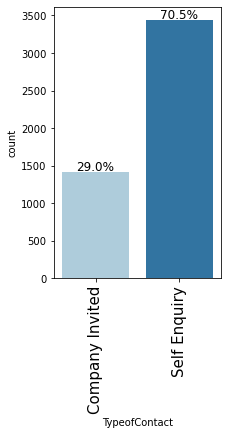

In [16]:
labeled_barplot(df, 'TypeofContact', perc=True)

It seems like the vast majority of customers came to us on their own, rather than were invited. This is not very informative on its own. Let's check for missing values.

In [17]:
#counting number of null values
df['TypeofContact'].isna().sum()

25

Let's take a look at them.

In [18]:
df[df['TypeofContact'].isna()==True]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
224,0,31.0,NaN,1,NaN,Small Business,Male,2,5.0,Deluxe,3.0,Divorced,1.0,0,3,1,0.0,Manager,NaN
571,0,26.0,NaN,1,NaN,Salaried,Female,3,5.0,Basic,3.0,Married,4.0,0,4,1,2.0,Executive,NaN
572,0,29.0,NaN,1,NaN,Small Business,Female,3,3.0,Deluxe,3.0,Divorced,5.0,0,2,1,0.0,Manager,NaN
576,0,27.0,NaN,3,NaN,Small Business,Male,2,3.0,Deluxe,3.0,Divorced,1.0,0,3,0,1.0,Manager,NaN
579,0,34.0,NaN,1,NaN,Small Business,Female,2,4.0,Basic,5.0,Single,2.0,0,2,1,1.0,Executive,NaN
598,1,28.0,NaN,1,NaN,Small Business,Male,2,3.0,Basic,3.0,Single,7.0,0,3,0,0.0,Executive,NaN
622,0,32.0,NaN,3,NaN,Salaried,Male,3,3.0,Deluxe,3.0,Married,3.0,0,2,0,0.0,Manager,NaN
724,0,24.0,NaN,1,NaN,Small Business,Female,2,4.0,Deluxe,3.0,Married,2.0,0,3,1,1.0,Manager,NaN
843,0,26.0,NaN,1,NaN,Small Business,Male,2,1.0,Basic,3.0,Divorced,2.0,0,5,1,1.0,Executive,NaN
1021,1,25.0,NaN,3,NaN,Salaried,Male,3,4.0,Basic,5.0,Divorced,4.0,0,1,1,0.0,Executive,NaN


All of these missing values are also missing monthly income and duration of pitch. I regret losing all the information we found, especially because several of these customers purchased a product, but given the large number of NaN for these customers and small overall number I think it best to remove them rather than impute them.

In [19]:
#This should remove just the 25 missing from this category.
df.dropna(subset=["TypeofContact"], inplace=True)

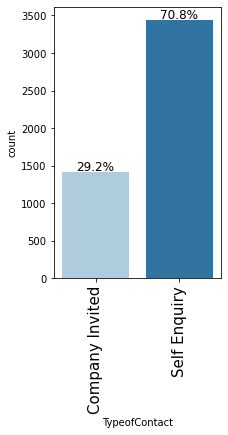

In [20]:
labeled_barplot(df, 'TypeofContact', perc=True)

The removal of these NaN did not overly impact the distribution, only changing the percent of company invited to increase 0.2%.

Now I am going to convert these to coded numbers for easier analysis later.

In [21]:
#First converting this column to category
df['TypeofContact'] = df['TypeofContact'].astype('category')
#Now assigning each category a number.
df['TypeofContact'] = df.TypeofContact.cat.codes

For reference:
* 0 = Company Invited
* 1 = Self Enquiry

### Observations on CityTier

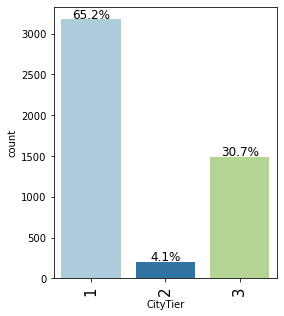

In [22]:
labeled_barplot(df, 'CityTier', perc=True)

The large majority of cities are the highest quality areas to live. Only a tiny few live in tier 2 cities, and about a third live in poor quality areas.

In [23]:
#counting number of null values
df['CityTier'].isna().sum()

0

City tier has no missing values. It's already a number so I don't need to change anything.

### Observations on Gender

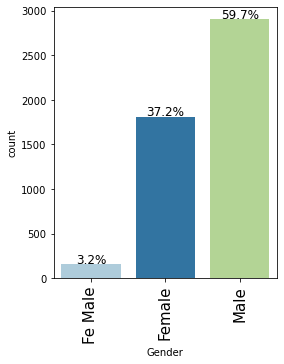

In [24]:
labeled_barplot(df, 'Gender', perc=True)

Ok let's fix those Fe Males.

In [25]:
#Iterate through each row finding the Fe Males and replacing them.
for i,x in df.iterrows():
    if df.at[i,'Gender'] == 'Fe Male':
        df.at[i,'Gender'] = 'Female'

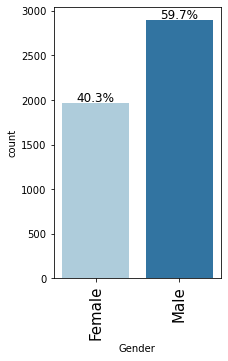

In [26]:
labeled_barplot(df, 'Gender', perc=True)

Much better.

There is a slight gender bias in the sample, with almost 60% of the sample being male. This may be because a little more than half of our customers are business owners and there are fewer female entrepreneurs in general (in the US anyway). Let's double check that assumption: we should see a closer to 50/50 distribution in salaried customers.

Gender          Female  Male   All
Occupation                        
All               1962  2901  4863
Salaried           940  1423  2363
Small Business     844  1220  2064
Large Business     178   256   434
Free Lancer          0     2     2
------------------------------------------------------------------------------------------------------------------------


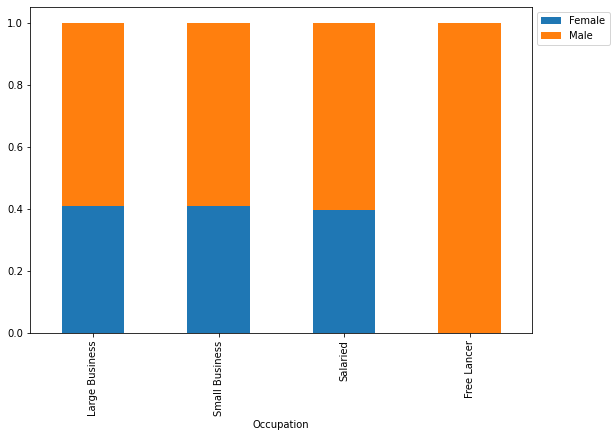

In [27]:
#Let's check my assumption
stacked_barplot(df, "Occupation", "Gender")

So much for that. The proportion is the same across all major occupational categories. Both freelancers are men, but that doesn't mean anything in general as there are only two.

In [28]:
#counting number of null values
df['Gender'].isna().sum()

0

There are no missing values to treat. Now to turn the column numerical for easier analysis later.

In [29]:
#First converting this column to category
df['Gender'] = df['Gender'].astype('category')
#Now assigning each category a number.
df['Gender'] = df.Gender.cat.codes

For reference:
* 0 = Female
* 1 = Male

### Observations on ProductPitched

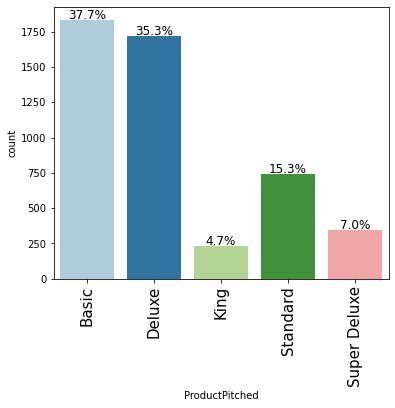

In [30]:
labeled_barplot(df, 'ProductPitched', perc=True)

About a third of our customers were pitched the Basic or Deluxe packages, with many fewer being pitched the others.



This is a very important variable. Because we have no information on what the new package looks like, we will need to make models for each of these products and create customer profiles for each using important features and shap. Then we can allow marketing to determine which package the new package is most similar to so they can make an educated guess on which strategy works best.

In [31]:
#counting number of null values
df['ProductPitched'].isna().sum()

0

No null values. I'll just make it into a number then.

In [32]:
#First converting this column to category
df['ProductPitched'] = df['ProductPitched'].astype('category')
#Now assigning each category a number.
df['ProductPitched'] = df.ProductPitched.cat.codes

For reference:
* 0 = Basic
* 1 = Deluxe
* 2 = King
* 3 = Standard
* 4 = Super Deluxe

### Observations on MaritalStatus

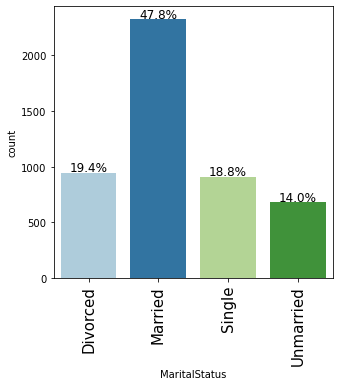

In [33]:
labeled_barplot(df, 'MaritalStatus', perc=True)

The largest category of our customers are those that are married, at almost half. Otherwise, divorced and single are about the same. Importantly, single and unmarried are different. Single reportedly means "Has no partner" whereas "unmarried" can have a partner they are just not married to.

I am curious how this category interacts with children.

MaritalStatus             Divorced  Married  Single  Unmarried   All
NumberOfChildrenVisiting                                            
All                            927     2296     892        682  4797
1.0                            398      980     381        310  2069
2.0                            241      661     200        231  1333
0.0                            222      492     274         82  1070
3.0                             66      163      37         59   325
------------------------------------------------------------------------------------------------------------------------


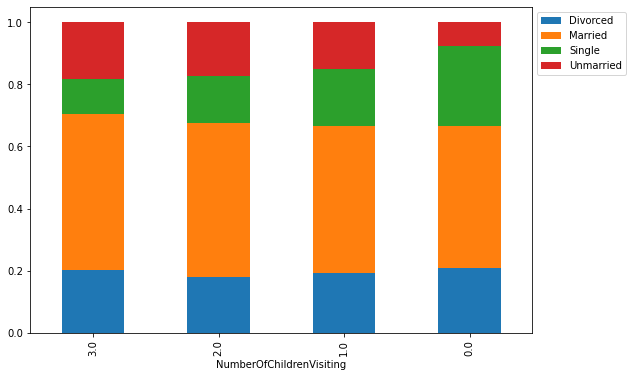

In [34]:
stacked_barplot(df, "NumberOfChildrenVisiting", "MaritalStatus")

These results are very counter-intuitive. The proportion of unmarried goes up as there are more children? I guess in our sample there are a lot of unmarried partnered couples with kids. I was expecting the proportion of married and divorced customers to go way up as number of kids increased, but it stays about the same.

In [35]:
#counting number of null values
df['MaritalStatus'].isna().sum()

0

No missing values. I'll just turn these categories into numbers for easier analysis later.

In [36]:
#First converting this column to category
df['MaritalStatus'] = df['MaritalStatus'].astype('category')
#Now assigning each category a number.
df['MaritalStatus'] = df.MaritalStatus.cat.codes

For reference:
* 0 = Divorced
* 1 = Married
* 2 = Single
* 3 = Unmarried

### Observations on Passport

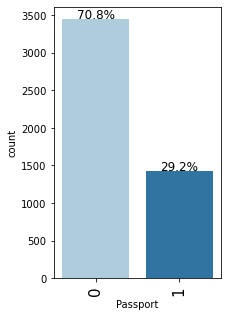

In [37]:
labeled_barplot(df, 'Passport', perc=True)

The large majority of our contacted customers did not have a passport. Less than a third did have one.

We'll look at how this interacts with ProdTaken in the ProdTaken category section.

In [38]:
#counting number of null values
df['Passport'].isna().sum()

0

No null values. It's already a number so I don't need to convert it.

### Observations on OwnCar

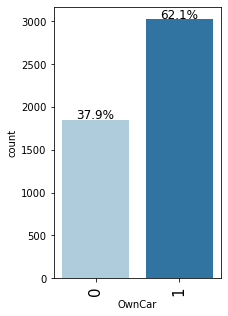

In [39]:
labeled_barplot(df, 'OwnCar', perc=True)

Almost two-thirds of our customers own their own car.

In [40]:
#counting number of null values
df['OwnCar'].isna().sum()

0

No null values and this is already a number so I don't need to further process it.

### Observations on Designation

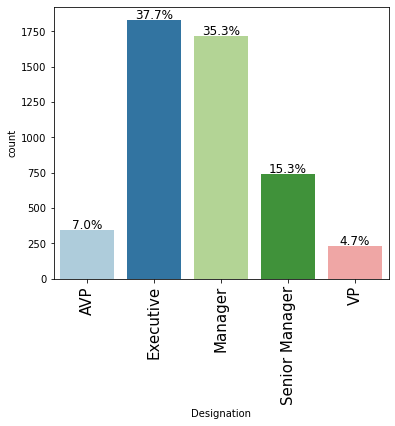

In [41]:
labeled_barplot(df, 'Designation', perc=True)

We have a lot of executives, but not nearly as many as the variable Occupation implies there should be. This makes me wonder what occupation actually means.

Occupation      Free Lancer  Large Business  Salaried  Small Business   All
Designation                                                                
Executive                 2             196       921             713  1832
All                       2             434      2363            2064  4863
AVP                       0              18       174             150   342
Manager                   0             124       816             777  1717
Senior Manager            0              84       338             320   742
VP                        0              12       114             104   230
------------------------------------------------------------------------------------------------------------------------


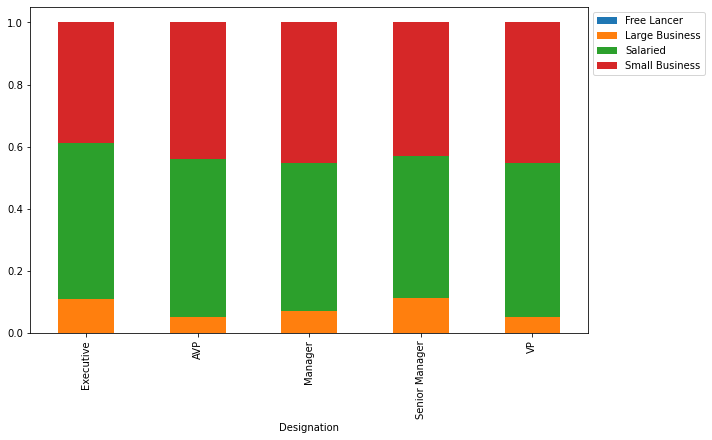

In [42]:
stacked_barplot(df, "Designation", "Occupation")

This has huge implications for the occupation category. It means that there are two fundamentally incompatable categories in an exclusive category.

Whether one works at a small business or not has nothing at all to do with whether or not one is salaried or paid hourly.

If someone is salaried they can still work at a small or large business.

These two things should not be in the same category.

I have no choice but to remove salaried from the occupation category and replace all of those with null values. Otherwise the data become uninterpretable. If I remove it, then the variable becomes "where does the customer work?"

In [43]:
#counting number of null values
df['Designation'].isna().sum()

0

There are no null values, so I'll just convert this column to numbers for easier processing later.

In [44]:
#First converting this column to category
df['Designation'] = df['Designation'].astype('category')
#Now assigning each category a number.
df['Designation'] = df.Designation.cat.codes

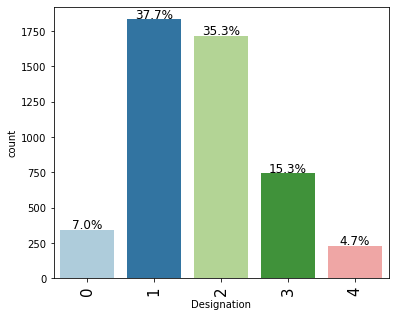

In [45]:
labeled_barplot(df, 'Designation', perc=True)

For reference:
* 0 = AVP
* 1 = Executive
* 2 = Manager
* 3 = Senior Manager
* 4 = VP

I want to make this category hierarchical, with the number equating to higher rank in the company.

In [46]:
#Now I need to change the categories around so I can actually make this hierarchical.
for i,row in df.iterrows():
    if df.at[i,'Designation']==1:
        df.at[i,'Designation'] = 5 #Executive 5
for i,row in df.iterrows():
    if df.at[i,'Designation']==2:
        df.at[i,'Designation'] = 1 #Manager 1
for i,row in df.iterrows():
    if df.at[i,'Designation']==3:
        df.at[i,'Designation'] = 2 #Senior Manager 2
for i,row in df.iterrows():
    if df.at[i,'Designation']==0:
        df.at[i,'Designation'] = 3 #AVP 3

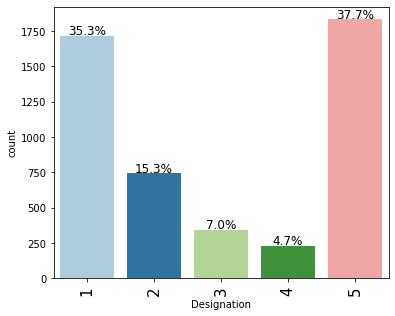

In [47]:
labeled_barplot(df, 'Designation', perc=True)

New reference:

* 1 = Manager
* 2 = Senior Manager
* 3 = AVP (associate Vice President?)
* 4 = VP (Vice President?)
* 5 = Executive (CEO?)

Now I can interpret this number as "the higher/lower they are in their company's hierarchy."
    

### Observations on Occupation

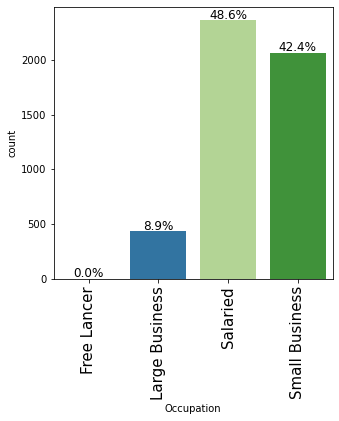

In [48]:
labeled_barplot(df, 'Occupation', perc=True)

We know from our unique values above that Free Lancer isn't actually 0%, it's two. I don't see a need to delete them.

As we learned from Designation, what does this category even mean? It seems to be asking "where does the customer work?" except that "salaried" has nothing at all to do with that question.

I have no choice but to remove Salaried completely and replace each instance with one of the other three categories. I'll use MissForest Imputer to do that along with my continuous missing values. For now, I'm just going to strip it all out.

In [49]:
#counting number of null values before I remove Salaried
df['Occupation'].isna().sum()

0

There are no missing values. I'm going to make the categories numerical before I strip out Salaried.

In [50]:
#First converting this column to category
df['Occupation'] = df['Occupation'].astype('category')
#Now assigning each category a number.
df['Occupation'] = df.Occupation.cat.codes

Next, to retain this information I am going to make a new category. 0 = not salaried, 1 = salaried.

In [51]:
df['Salaried'] = df['Occupation']

for i,row in df.iterrows():
    if df.at[i,'Salaried']!=2:
        df.at[i,'Salaried'] = 0
for i,row in df.iterrows():
    if df.at[i,'Salaried']==2:
        df.at[i,'Salaried'] = 1

In [52]:
df['Salaried'].value_counts()

0    2500
1    2363
Name: Salaried, dtype: int64

Now we know which customers are salaried and which are wage earners.

For reference:
* 0 = Wage Earner (not salaried)
* 1 = Salaried

In [53]:
#Removing salaried from Occupation by putting NaN in its place
df['Occupation'].replace(2,np.NaN, inplace=True)

In [54]:
#counting number of null values
df['Occupation'].isna().sum()

2363

All salaried customers are now NaN. I will impute these values along with the numerical columns later.

In [55]:
#Now I need to change the categories around so I can actually make this hierarchical.
for i,row in df.iterrows():
    if df.at[i,'Occupation']==1:
        df.at[i,'Occupation'] = 2
for i,row in df.iterrows():
    if df.at[i,'Occupation']==3:
        df.at[i,'Occupation'] = 1

In [56]:
#Let's look at the new values.
df['Occupation'].value_counts()

1.0    2064
2.0     434
0.0       2
Name: Occupation, dtype: int64

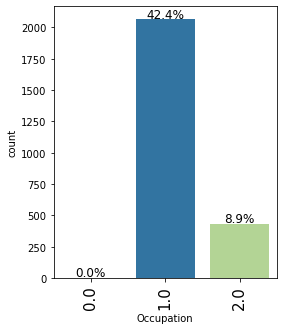

In [57]:
labeled_barplot(df, 'Occupation', perc=True)

Now these categories are hierarchical and easier to analyze. As the category number increases, the business where the customer works becomes larger.

For reference:
* 0 = Free Lancer
* 1 = Small Business
* 2 = Large Business

### Observations on PreferredPropertyStar

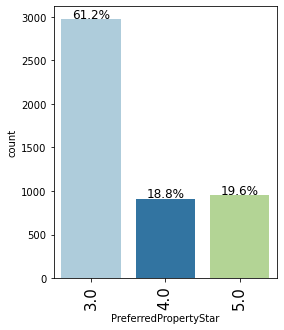

In [58]:
labeled_barplot(df, 'PreferredPropertyStar', perc=True)

Almost two thirds of customers prefer a 3 star hotel when traveling. I am a bit surprised by this, but it is what it is. Now to check missing values.

In [59]:
#counting number of null values
df['PreferredPropertyStar'].isna().sum()

26

In [60]:
#A closer look at those NaN
pd.set_option('display.max_columns', None)
df[df['PreferredPropertyStar'].isna()==True]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried
38,0,36.0,1,1,11.0,NaN,0,2,4.0,0,NaN,0,1.0,1,2,1,0.0,5,95000.0,1
2609,0,51.0,1,1,18.0,NaN,0,3,4.0,2,NaN,2,5.0,0,5,1,1.0,4,38604.0,1
2634,0,53.0,1,1,7.0,NaN,1,4,5.0,2,NaN,0,2.0,0,2,1,2.0,4,38677.0,1
3012,1,56.0,1,1,9.0,1.0,1,4,4.0,2,NaN,0,7.0,1,2,1,3.0,4,38537.0,0
3190,0,42.0,0,1,14.0,NaN,0,3,6.0,2,NaN,1,3.0,0,4,1,1.0,4,38651.0,1
3193,1,53.0,1,3,9.0,1.0,0,3,6.0,2,NaN,0,3.0,0,3,1,1.0,4,38523.0,0
3214,0,47.0,1,1,7.0,1.0,1,3,4.0,2,NaN,1,2.0,0,5,1,2.0,4,38305.0,0
3295,0,57.0,1,1,11.0,2.0,0,4,4.0,2,NaN,1,6.0,0,4,0,3.0,4,38621.0,0
3342,0,44.0,1,1,10.0,NaN,1,4,6.0,2,NaN,0,5.0,0,5,1,3.0,4,38418.0,1
3362,0,52.0,0,3,16.0,NaN,1,3,4.0,2,NaN,1,6.0,1,4,1,2.0,4,38525.0,1


I don't see any pattern to these NaN. I'll impute them along with everything else.

I am curious how this interacts with Designation. I'm guessing the big hotshots will prefer more stars in their hotels.

PreferredPropertyStar   3.0  4.0  5.0   All
Designation                                
All                    2974  912  951  4837
5                      1111  368  352  1831
1                      1078  311  327  1716
2                       436  130  175   741
3                       212   62   68   342
4                       137   41   29   207
------------------------------------------------------------------------------------------------------------------------


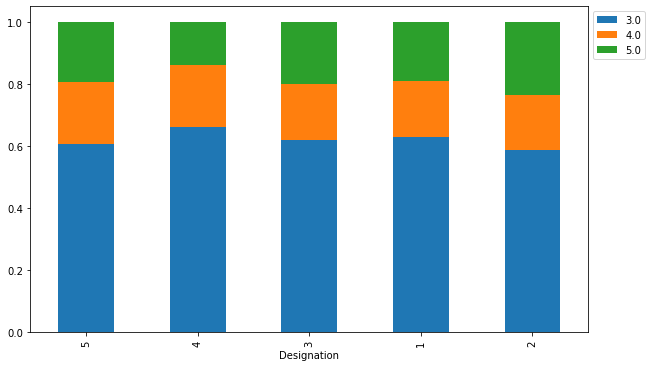

In [61]:
stacked_barplot(df, "Designation", "PreferredPropertyStar")

If there is a pattern there I can't see it. Oh well. Moving on.

## Numerical Variables

I know I left out ProdTaken. That is our target variable, so I want to fix all missing values and such before I look at how it interacts with the other variables.

### Observations on Age

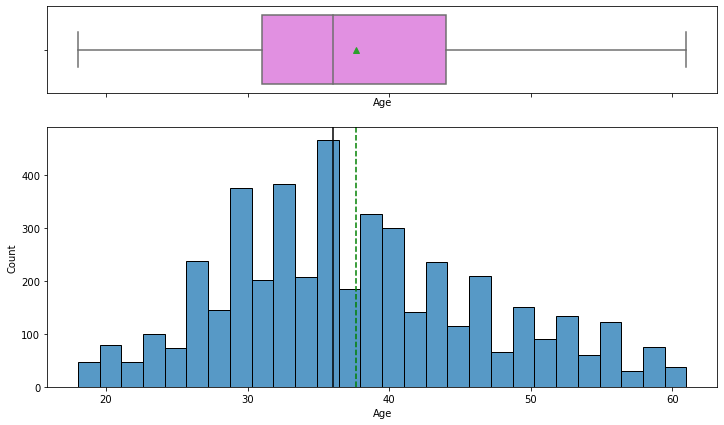

In [62]:
histogram_boxplot(df, 'Age')

In [63]:
print("Column: Age has skewness ",df['Age'].skew())

Column: Age has skewness  0.37775118467724317


In [64]:
#Checking for quartiles even though I see no outliers
outlier_ID(df,'Age',2)

The quartiles for Age are the following: Q1 = 31.0, Q3 = 44.0, 2*IQR = 26.0


Series([], Name: Age, dtype: float64)

Seems normally distributed, no strange outliers, no zeroes, not skewed. Nothing needs to be changed.

In [65]:
#counting number of null values
df['Age'].isna().sum()

226

We have some NaN values. Let me look at them.

In [66]:
df[df['Age'].isna()==True]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried
4,0,NaN,1,1,8.0,1.0,1,2,3.0,0,4.0,0,1.0,0,5,1,0.0,5,18468.0,0
11,0,NaN,1,1,21.0,NaN,0,2,4.0,1,3.0,2,1.0,1,3,0,0.0,1,NaN,1
19,0,NaN,1,1,8.0,NaN,1,2,3.0,0,3.0,2,6.0,1,4,0,1.0,5,NaN,1
20,0,NaN,0,1,17.0,NaN,0,3,2.0,1,3.0,1,1.0,0,3,1,2.0,1,NaN,1
21,1,NaN,1,3,15.0,NaN,1,2,4.0,1,5.0,2,1.0,0,2,0,0.0,1,18407.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2410,1,NaN,1,1,30.0,1.0,1,2,3.0,0,4.0,1,2.0,1,1,0,0.0,5,NaN,0
2413,1,NaN,1,3,21.0,1.0,1,2,5.0,1,3.0,1,7.0,1,1,0,1.0,1,18423.0,0
2427,1,NaN,1,3,22.0,1.0,1,3,3.0,3,3.0,1,3.0,0,5,0,1.0,2,18544.0,0
2430,1,NaN,1,1,14.0,1.0,0,3,3.0,0,5.0,1,2.0,1,3,0,2.0,5,NaN,0


No pattern immediately jumps out at me. I'll just impute it along with everything else.

### Observations on DurationOfPitch

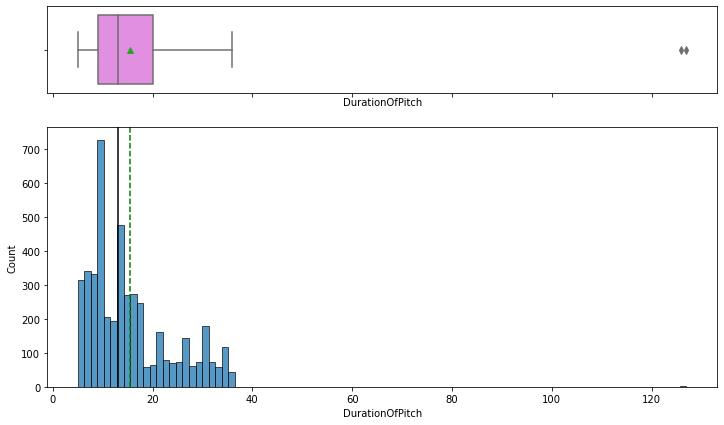

In [67]:
histogram_boxplot(df, 'DurationOfPitch')

Holy moly look at that outlier.

In [68]:
outlier_ID(df,'DurationOfPitch',3)

The quartiles for DurationOfPitch are the following: Q1 = 9.0, Q3 = 20.0, 3*IQR = 33.0


3878    127.0
1434    126.0
Name: DurationOfPitch, dtype: float64

In [69]:
#Let's take a close look at those two:
Dur_out = outlier_ID(df,'DurationOfPitch',3).index
df.loc[Dur_out]

The quartiles for DurationOfPitch are the following: Q1 = 9.0, Q3 = 20.0, 3*IQR = 33.0


,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried
3878,0,53.0,0,3,127.0,NaN,1,3,4.0,0,3.0,1,4.0,0,1,1,2.0,5,22160.0,1
1434,0,NaN,0,3,126.0,NaN,1,2,3.0,0,3.0,1,3.0,0,1,1,1.0,5,18482.0,1


They talked to the customer for two hours? Dang.

Given this only happened twice in a dataset of almost 5000, I'm fine just dropping these.

In [70]:
#We're sales not psychologists, no need to talk for 2 hours
df.drop([1434, 3878], inplace=True)

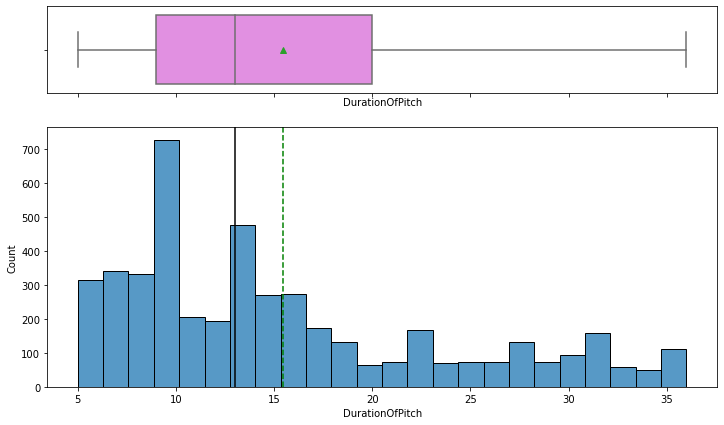

In [71]:
histogram_boxplot(df, 'DurationOfPitch')

In [72]:
outlier_ID(df,'DurationOfPitch',3)

The quartiles for DurationOfPitch are the following: Q1 = 9.0, Q3 = 20.0, 3*IQR = 33.0


Series([], Name: DurationOfPitch, dtype: float64)

In [73]:
print("Column: DurationOfPitch has skewness ",df['DurationOfPitch'].skew())

Column: DurationOfPitch has skewness  0.910969212193547


In [74]:
#Let's see the new description
df['DurationOfPitch'].describe()

count    4635.000000
mean       15.442934
std         8.203335
min         5.000000
25%         9.000000
50%        13.000000
75%        20.000000
max        36.000000
Name: DurationOfPitch, dtype: float64

It's not exactly normally distributed, but it's not too bad. A skew between -1 and 1 is fine.

In [75]:
df['DurationOfPitch'].isna().sum()

226

In [76]:
#A closer look at those NaN
df[df['DurationOfPitch'].isna()==True]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried
46,0,34.0,0,3,NaN,1.0,1,3,3.0,1,3.0,2,1.0,0,5,1,1.0,1,19568.0,0
75,0,31.0,1,1,NaN,NaN,0,3,3.0,1,3.0,2,2.0,0,5,0,1.0,1,NaN,1
76,0,35.0,1,3,NaN,1.0,1,2,4.0,1,5.0,2,1.0,0,2,0,1.0,1,NaN,0
84,0,34.0,1,1,NaN,1.0,1,3,3.0,1,4.0,0,2.0,0,5,0,0.0,1,NaN,0
103,0,34.0,1,1,NaN,NaN,0,2,3.0,1,3.0,2,2.0,0,3,1,0.0,1,19809.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4215,0,19.0,1,3,NaN,1.0,0,4,5.0,0,3.0,2,3.0,0,1,0,3.0,5,19878.0,0
4427,1,21.0,1,1,NaN,1.0,1,3,4.0,0,3.0,2,3.0,1,5,1,2.0,5,19687.0,0
4641,0,19.0,0,1,NaN,NaN,1,4,4.0,0,3.0,2,3.0,0,1,0,2.0,5,19729.0,1
4678,0,29.0,1,3,NaN,1.0,1,4,4.0,0,4.0,1,3.0,0,5,0,3.0,5,19730.0,0


Well, it has the same exact number of NaN as Age but they do not perfectly overlap. It is just a coincidence I guess. I'll handle them with everything else.

### Observations on NumberOfPersonVisiting

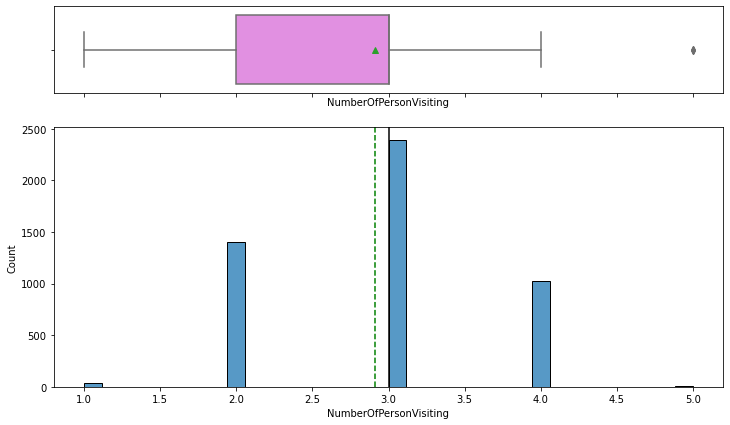

In [77]:
histogram_boxplot(df, 'NumberOfPersonVisiting')

In [78]:
print("Column: NumberOfPersonVisiting has skewness ",df['NumberOfPersonVisiting'].skew())

Column: NumberOfPersonVisiting has skewness  0.02405517550946663


In [79]:
#looking at IQR
outlier_ID(df,'NumberOfPersonVisiting',2)

The quartiles for NumberOfPersonVisiting are the following: Q1 = 2.0, Q3 = 3.0, 2*IQR = 2.0


Series([], Name: NumberOfPersonVisiting, dtype: int64)

In [80]:
#Refresh ourselves on the stats of this column
df['NumberOfPersonVisiting'].describe()

count    4861.000000
mean        2.908249
std         0.724793
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: NumberOfPersonVisiting, dtype: float64

There's no 0s? Weird but not impossible. The sole "outlier" is 5, which is a perfectly plausible number, and not really all that high.

In [81]:
df['NumberOfPersonVisiting'].isna().sum()

0

No missing numbers. I don't think this variable needs any treatments.

### Observations on NumberOfFollowups

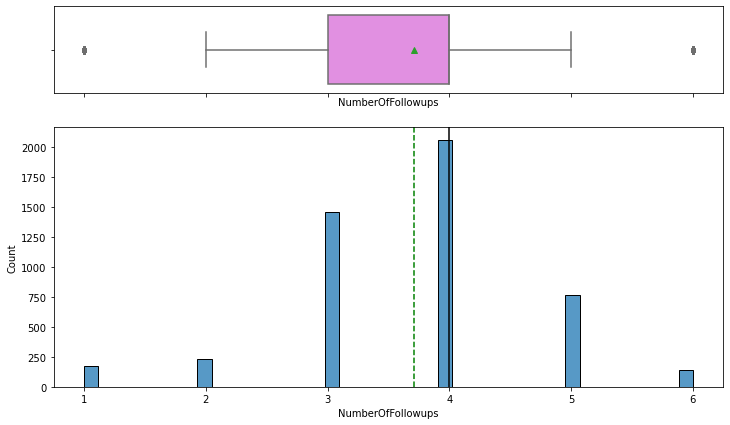

In [82]:
histogram_boxplot(df, 'NumberOfFollowups')

In [83]:
print("Column: NumberOfFollowups has skewness ",df['NumberOfFollowups'].skew())

Column: NumberOfFollowups has skewness  -0.3680510997789541


In [84]:
#looking at IQR
outlier_ID(df,'NumberOfFollowups',3)

The quartiles for NumberOfFollowups are the following: Q1 = 3.0, Q3 = 4.0, 3*IQR = 3.0


Series([], Name: NumberOfFollowups, dtype: float64)

The "outliers" are just 1s and 6s, which isn't really bad or unreasonable. I see no reason to delete them.

In [85]:
df['NumberOfFollowups'].isna().sum()

45

I am curious as to whether the missing values are simply zero. It does not seem unreasonable to think that some of the salespeople were unable to follow-up. I want to take a closer look.

In [86]:
#A closer look at those NaN
df[df['NumberOfFollowups'].isna()==True]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried
79,0,46.0,1,2,11.0,1.0,1,3,NaN,1,4.0,1,1.0,1,5,0,1.0,1,20021.0,0
94,0,32.0,1,3,12.0,1.0,1,2,NaN,1,3.0,2,2.0,0,5,1,0.0,1,20010.0,0
96,0,24.0,1,3,9.0,NaN,0,2,NaN,1,3.0,0,1.0,0,4,1,0.0,1,19999.0,1
122,1,56.0,1,1,20.0,NaN,0,3,NaN,0,4.0,0,1.0,1,5,1,1.0,5,19963.0,1
135,0,36.0,1,1,12.0,1.0,1,2,NaN,1,4.0,1,7.0,0,4,1,1.0,1,19941.0,0
174,0,45.0,1,3,10.0,NaN,0,1,NaN,1,5.0,1,5.0,1,4,0,0.0,1,20006.0,1
317,1,52.0,1,1,14.0,1.0,1,2,NaN,1,4.0,0,3.0,0,2,1,1.0,1,19941.0,0
322,0,32.0,1,1,8.0,1.0,0,3,NaN,1,3.0,2,1.0,0,3,1,2.0,1,20055.0,0
376,0,51.0,1,3,20.0,NaN,0,2,NaN,1,3.0,0,5.0,0,3,0,1.0,1,19936.0,1
532,0,47.0,1,3,20.0,1.0,1,2,NaN,1,5.0,2,3.0,0,2,0,1.0,1,19960.0,0


There are no obvious patterns here. I can either impute them or make them zero. 
I have a hypothesis: The trend away from 3 and 4 follow-ups is down. If these are actually zero, there should be many fewer than 1 follow-ups, and fewer than 6 as well.

In [87]:
print("Number of 1 follow-ups:", len(df[df['NumberOfFollowups']==1]))
print("Number of 6 follow-ups:", len(df[df['NumberOfFollowups']==6]))
print("Number of NaN follow-ups:", len(df[df['NumberOfFollowups'].isna()==True]))

Number of 1 follow-ups: 172
Number of 6 follow-ups: 136
Number of NaN follow-ups: 45


The number of NaN are less than half of the number of 1s and 6s, following the trend downwards quite cleanly. I think these NaN are actually zeroes.

But just in case I'm wrong I'll copy this column and make another imputed version. Then I can swap them out and test which model has a superior accuracy if I want to.

In [88]:
#I'll leave them NaN in this new column to be imputed later.
df['Followups_Imputed'] = df['NumberOfFollowups']

In [89]:
df['NumberOfFollowups'].replace(np.NaN,0, inplace=True)

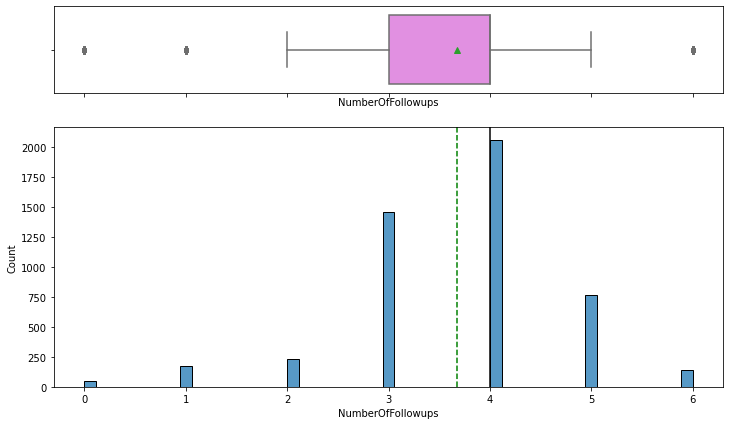

In [90]:
histogram_boxplot(df, 'NumberOfFollowups')

In [91]:
print("Column: NumberOfFollowups has skewness ",df['NumberOfFollowups'].skew())

Column: NumberOfFollowups has skewness  -0.6113424985395844


Making the NaN zero does increase the skew, but not so much as to make it heavily skewed.

### Observations on NumberOfTrips

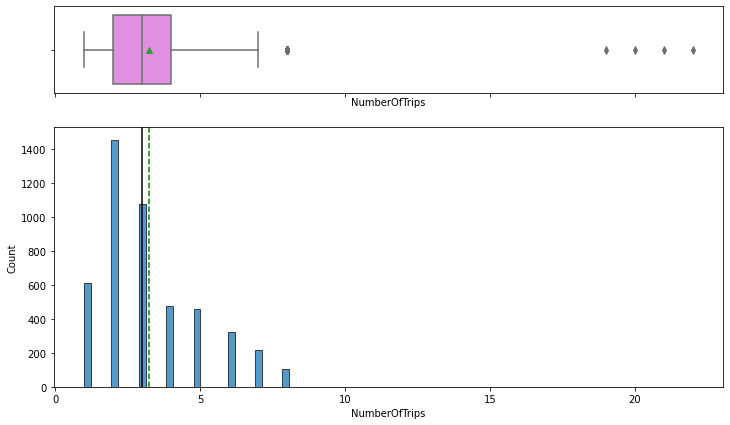

In [92]:
histogram_boxplot(df, 'NumberOfTrips')

In [93]:
print("Column: NumberOfTrips has skewness ",df['NumberOfTrips'].skew())

Column: NumberOfTrips has skewness  1.4569937864461187


That is skewed, probably because of the outliers. Let's look at those.

In [94]:
#looking at IQR
outlier_ID(df,'NumberOfTrips',3)

The quartiles for NumberOfTrips are the following: Q1 = 2.0, Q3 = 4.0, 3*IQR = 6.0


3260    22.0
816     21.0
2829    20.0
385     19.0
Name: NumberOfTrips, dtype: float64

That's a lot of trips. I want to know more about these people.

In [95]:
#Separating out these outliers so I can see them.
df_jetset = []
trip_out = [3260, 816, 2829, 385]
for i, x in df.iterrows():
    if i in trip_out:
        df_jetset.append(x)
pd.DataFrame(df_jetset)

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried,Followups_Imputed
385,1.0,30.0,0.0,1.0,10.0,2.0,1.0,2.0,3.0,0.0,3.0,2.0,19.0,1.0,4.0,1.0,1.0,5.0,17285.0,0.0,3.0
816,0.0,39.0,0.0,1.0,15.0,NaN,1.0,3.0,3.0,1.0,4.0,3.0,21.0,0.0,2.0,1.0,0.0,1.0,21782.0,1.0,3.0
2829,1.0,31.0,0.0,1.0,11.0,2.0,1.0,3.0,4.0,0.0,3.0,2.0,20.0,1.0,4.0,1.0,2.0,5.0,20963.0,0.0,4.0
3260,0.0,40.0,0.0,1.0,16.0,NaN,1.0,4.0,4.0,1.0,4.0,3.0,22.0,0.0,2.0,1.0,1.0,1.0,25460.0,1.0,4.0


These outliers can be true. I don't see any obvious problems, some people just travel a lot for work. I'd say the weirdest thing is the lack of a passport, but it's possible domestic flights are a thing.

I'm using decision trees in this analysis, so the outliers are probably not going to grossly affect things. I'm going to leave them alone.

In [96]:
df['NumberOfTrips'].isna().sum()

140

In [97]:
#A closer look at those NaN
df[df['NumberOfTrips'].isna()==True]

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried,Followups_Imputed
2469,0,54.0,1,1,12.0,NaN,0,3,4.0,2,3.0,1,NaN,0,5,0,2.0,4,37772.0,1,4.0
2473,0,47.0,1,3,9.0,1.0,0,3,4.0,2,5.0,2,NaN,0,2,0,2.0,4,37625.0,0,4.0
2506,0,51.0,1,1,14.0,1.0,0,3,5.0,2,3.0,1,NaN,1,4,1,2.0,4,37418.0,0,5.0
2549,0,60.0,0,2,9.0,NaN,0,3,5.0,2,3.0,0,NaN,0,2,1,2.0,4,37522.0,1,5.0
2550,0,51.0,0,1,7.0,NaN,0,4,4.0,2,4.0,0,NaN,1,2,0,3.0,4,36850.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4836,1,45.0,1,3,16.0,NaN,1,4,5.0,0,5.0,1,NaN,0,1,1,3.0,5,37868.0,1,5.0
4850,1,46.0,1,3,8.0,NaN,1,4,5.0,1,5.0,1,NaN,0,4,1,3.0,1,36739.0,1,5.0
4851,1,40.0,1,1,9.0,NaN,0,4,4.0,0,5.0,1,NaN,1,1,1,1.0,5,35801.0,1,4.0
4868,1,43.0,0,2,15.0,NaN,0,4,5.0,0,3.0,1,NaN,0,5,1,2.0,5,36539.0,1,5.0


I don't see any obvious patterns. I'll impute these with all of the rest of the values.

### Observations on PitchSatisfactionScore

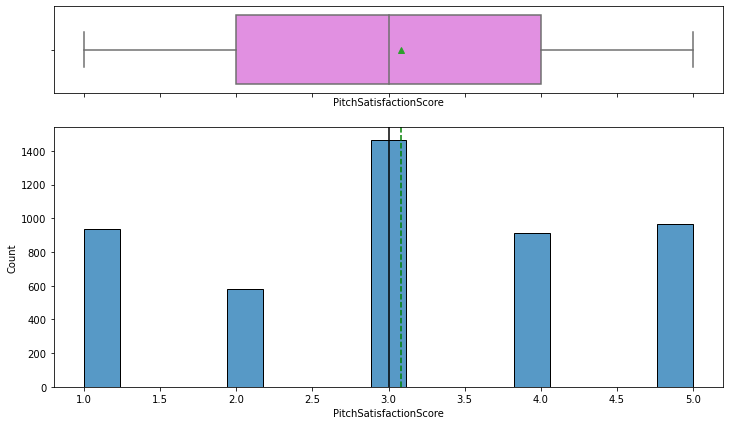

In [98]:
histogram_boxplot(df, 'PitchSatisfactionScore')

In [99]:
print("Column: PitchSatisfactionScore has skewness ",df['PitchSatisfactionScore'].skew())

Column: PitchSatisfactionScore has skewness  -0.12984585547151903


There are no outliers and there is virtually no skew. I should consider making this a categorical variable. My issue is that technically speaking, this variable should represent continuous data. However, most surveyers use the outdated Likert scale which innappropriately converts a continuous reality into discrete data. Oh well. At the very least it is hierarchical.

This is a target variable because the marketing department is asking for feedback. One of the things I'll probably want to predict is what results in a high pitch satisfaction. Thus I don't want to mess with this variable.

In [100]:
df['PitchSatisfactionScore'].isna().sum()

0

No missing values. That's good, because I'd have had to drop any rows with missing values.

### Observations on NumberOfChildrenVisiting

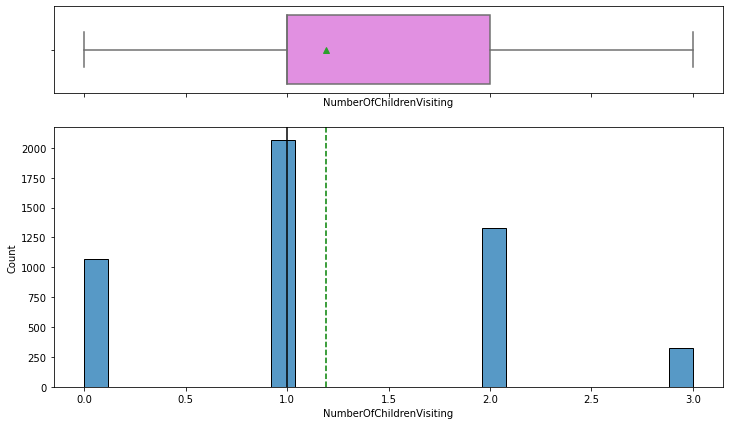

In [101]:
histogram_boxplot(df, 'NumberOfChildrenVisiting')

In [102]:
print("Column: NumberOfChildrenVisiting has skewness ",df['NumberOfChildrenVisiting'].skew())

Column: NumberOfChildrenVisiting has skewness  0.26954923560058897


In [103]:
df['NumberOfChildrenVisiting'].isna().sum()

66

I'm kind of surprised so many of our sample have very young children. Remember, this variable is only for children under 5. This makes me wonder if those 66 NaN are actually 0s.

Let's look at how the number of children is distributed across the other variables:

In [104]:
df.groupby(['NumberOfChildrenVisiting']).mean()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,Salaried,Followups_Imputed
NumberOfChildrenVisiting,,,,,,,,,,,,,,,,,,,,
0.0,0.186916,37.400624,0.705607,1.640187,15.039837,1.171846,0.581308,2.293458,3.142991,1.213084,3.551918,1.201869,2.704673,0.288785,3.069159,0.602804,2.896262,21665.410733,0.488785,3.190702
1.0,0.189072,37.562847,0.707930,1.660542,15.471574,1.172770,0.598646,2.829787,3.699710,1.152321,3.565049,1.291586,3.242184,0.286750,3.078820,0.613636,2.928917,23425.708816,0.485010,3.735840
2.0,0.189940,37.495012,0.708709,1.662162,15.536980,1.174603,0.611111,3.249249,3.940691,1.131381,3.599092,1.316066,3.519337,0.295796,3.088589,0.635135,2.968468,24358.609327,0.479730,3.967498
3.0,0.203077,37.606154,0.689231,1.615385,16.173913,1.165680,0.612308,4.000000,4.147692,1.135385,3.679245,1.273846,3.745875,0.332308,3.036923,0.636923,2.981538,25358.286154,0.480000,4.147692


The age of our customer is about the same no matter how many children they have? How?
I can't make sense of this. I'm just going to impute the number with everything else.

### Observations on MonthlyIncome

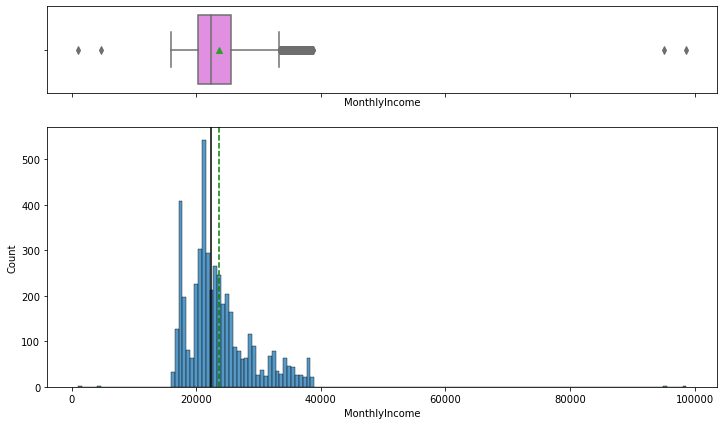

In [105]:
histogram_boxplot(df, 'MonthlyIncome')

In [106]:
print("Column: MonthlyIncome has skewness ",df['MonthlyIncome'].skew())

Column: MonthlyIncome has skewness  1.9487612395328233


Big outliers, big skew. Let's look at the outliers.

In [107]:
#looking at IQR
outlier_ID(df,'MonthlyIncome',4)

The quartiles for MonthlyIncome are the following: Q1 = 20346.0, Q3 = 25571.0, 4*IQR = 20900.0


2482    98678.0
38      95000.0
142      1000.0
Name: MonthlyIncome, dtype: float64

Two big outliers and one small outlier. Let's look at them.

In [108]:
#Separating out these outliers so I can see them.
df_incout = []
inc_out = [2482, 38, 142]
for i, x in df.iterrows():
    if i in inc_out:
        df_incout.append(x)
pd.DataFrame(df_incout)

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried,Followups_Imputed
38,0.0,36.0,1.0,1.0,11.0,NaN,0.0,2.0,4.0,0.0,NaN,0.0,1.0,1.0,2.0,1.0,0.0,5.0,95000.0,1.0,4.0
142,0.0,38.0,1.0,1.0,9.0,2.0,0.0,2.0,3.0,1.0,3.0,2.0,4.0,1.0,5.0,0.0,0.0,1.0,1000.0,0.0,3.0
2482,0.0,37.0,1.0,1.0,12.0,NaN,0.0,3.0,5.0,0.0,5.0,0.0,2.0,1.0,2.0,1.0,1.0,5.0,98678.0,1.0,5.0


My prediction for the big earners is they'd be big shots in a large company and the reverse for the small earner. The occupation turns out to be NaN, but Designation checks out. These are probably legit.

If I were going to do a logistic regression I'd drop them, but I'm using decision trees. Should be fine.

In [109]:
df['MonthlyIncome'].isna().sum()

208

That's a lot of missing values. I think I can just impute all of these.

## Missing Value Treatment

I'm going to impute everything with Missing Forest, as it reportedly does better than even KNN, especially with data that has outliers. I'll round the categorical variables and leave the continuous ones alone.

I'm going to start by imputing the smallest NaN categories and end with the largest one (Occupation).

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4861 entries, 0 to 4887
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4861 non-null   int64  
 1   Age                       4636 non-null   float64
 2   TypeofContact             4861 non-null   int8   
 3   CityTier                  4861 non-null   int64  
 4   DurationOfPitch           4635 non-null   float64
 5   Occupation                2500 non-null   float64
 6   Gender                    4861 non-null   int8   
 7   NumberOfPersonVisiting    4861 non-null   int64  
 8   NumberOfFollowups         4861 non-null   float64
 9   ProductPitched            4861 non-null   int8   
 10  PreferredPropertyStar     4835 non-null   float64
 11  MaritalStatus             4861 non-null   int8   
 12  NumberOfTrips             4721 non-null   float64
 13  Passport                  4861 non-null   int64  
 14  PitchSat

In [111]:
df.isnull().sum().sort_values(ascending=True)

ProdTaken                      0
Designation                    0
TypeofContact                  0
CityTier                       0
OwnCar                         0
PitchSatisfactionScore         0
Gender                         0
NumberOfPersonVisiting         0
NumberOfFollowups              0
ProductPitched                 0
Salaried                       0
MaritalStatus                  0
Passport                       0
PreferredPropertyStar         26
Followups_Imputed             45
NumberOfChildrenVisiting      66
NumberOfTrips                140
MonthlyIncome                208
Age                          225
DurationOfPitch              226
Occupation                  2361
dtype: int64

In [112]:
#I need column names so I can assign them to the imputed df.
df.columns

Index(['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome', 'Salaried',
       'Followups_Imputed'],
      dtype='object')

In [113]:
df

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried,Followups_Imputed
0,1,41.0,1,3,6.0,NaN,0,3,3.0,1,3.0,2,1.0,1,2,1,0.0,1,20993.0,1,3.0
1,0,49.0,0,1,14.0,NaN,1,3,4.0,1,4.0,0,2.0,0,3,1,2.0,1,20130.0,1,4.0
2,1,37.0,1,1,8.0,0.0,1,3,4.0,0,3.0,2,7.0,1,3,0,0.0,5,17090.0,0,4.0
3,0,33.0,0,1,9.0,NaN,0,2,3.0,0,3.0,0,2.0,1,5,1,1.0,5,17909.0,1,3.0
4,0,NaN,1,1,8.0,1.0,1,2,3.0,0,4.0,0,1.0,0,5,1,0.0,5,18468.0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,1,49.0,1,3,9.0,1.0,1,3,5.0,1,4.0,3,2.0,1,1,1,1.0,1,26576.0,0,5.0
4884,1,28.0,0,1,31.0,NaN,1,4,5.0,0,3.0,2,3.0,1,3,1,2.0,5,21212.0,1,5.0
4885,1,52.0,1,3,17.0,NaN,0,4,4.0,3,4.0,1,7.0,0,1,1,3.0,2,31820.0,1,4.0
4886,1,19.0,1,3,16.0,1.0,1,3,4.0,0,3.0,2,3.0,0,5,0,2.0,5,20289.0,0,4.0


In [114]:
#Imputing using MissForest, a non-parametric imputation method
imputer = MissForest()
X = df.drop(['ProdTaken','PitchSatisfactionScore'],axis=1)
df_imputed = pd.DataFrame(imputer.fit_transform(X))

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [115]:
#The imputer removes columns names and such for some reason. I have to do some cleanup.

df_imputed.columns = ['Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome', 'Salaried',
       'Followups_Imputed']
#adding target variables back in
df_imputed['ProdTaken'] = df['ProdTaken'].values 
df_imputed['PitchSatisfactionScore'] = df['PitchSatisfactionScore'].values

#Rounding columns that should be rounded
df_imputed['Occupation'] = round(df_imputed['Occupation'])
df_imputed['Age'] = round(df_imputed['Age'])
df_imputed['NumberOfTrips'] = round(df_imputed['NumberOfTrips'])
df_imputed['NumberOfChildrenVisiting'] = round(df_imputed['NumberOfChildrenVisiting'])
df_imputed['Followups_Imputed'] = round(df_imputed['Followups_Imputed'])
df_imputed['PreferredPropertyStar'] = round(df_imputed['PreferredPropertyStar'])
df_imputed

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,Salaried,Followups_Imputed,ProdTaken,PitchSatisfactionScore
0,41.0,1.0,3.0,6.0,1.0,0.0,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,0.0,1.0,20993.0,1.0,3.0,1,2
1,49.0,0.0,1.0,14.0,1.0,1.0,3.0,4.0,1.0,4.0,0.0,2.0,0.0,1.0,2.0,1.0,20130.0,1.0,4.0,0,3
2,37.0,1.0,1.0,8.0,0.0,1.0,3.0,4.0,0.0,3.0,2.0,7.0,1.0,0.0,0.0,5.0,17090.0,0.0,4.0,1,3
3,33.0,0.0,1.0,9.0,1.0,0.0,2.0,3.0,0.0,3.0,0.0,2.0,1.0,1.0,1.0,5.0,17909.0,1.0,3.0,0,5
4,32.0,1.0,1.0,8.0,1.0,1.0,2.0,3.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,5.0,18468.0,0.0,3.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4856,49.0,1.0,3.0,9.0,1.0,1.0,3.0,5.0,1.0,4.0,3.0,2.0,1.0,1.0,1.0,1.0,26576.0,0.0,5.0,1,1
4857,28.0,0.0,1.0,31.0,1.0,1.0,4.0,5.0,0.0,3.0,2.0,3.0,1.0,1.0,2.0,5.0,21212.0,1.0,5.0,1,3
4858,52.0,1.0,3.0,17.0,1.0,0.0,4.0,4.0,3.0,4.0,1.0,7.0,0.0,1.0,3.0,2.0,31820.0,1.0,4.0,1,1
4859,19.0,1.0,3.0,16.0,1.0,1.0,3.0,4.0,0.0,3.0,2.0,3.0,0.0,0.0,2.0,5.0,20289.0,0.0,4.0,1,5


In [116]:
# Double checking we got all the nan.
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4861 non-null   float64
 1   TypeofContact             4861 non-null   float64
 2   CityTier                  4861 non-null   float64
 3   DurationOfPitch           4861 non-null   float64
 4   Occupation                4861 non-null   float64
 5   Gender                    4861 non-null   float64
 6   NumberOfPersonVisiting    4861 non-null   float64
 7   NumberOfFollowups         4861 non-null   float64
 8   ProductPitched            4861 non-null   float64
 9   PreferredPropertyStar     4861 non-null   float64
 10  MaritalStatus             4861 non-null   float64
 11  NumberOfTrips             4861 non-null   float64
 12  Passport                  4861 non-null   float64
 13  OwnCar                    4861 non-null   float64
 14  NumberOf

I am not much worried about most of the columns, their NaN scores were few in number. However, Occupation worries me as almost half were missing because I removed Salaried.

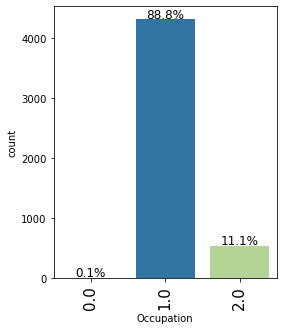

In [117]:
labeled_barplot(df_imputed, 'Occupation', perc=True)

In [118]:
df_imputed['Occupation'].value_counts()

1.0    4318
2.0     539
0.0       4
Name: Occupation, dtype: int64

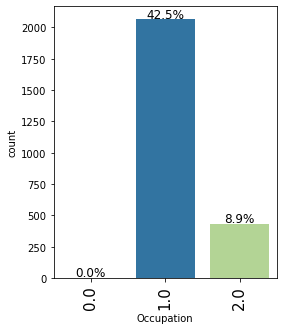

In [119]:
labeled_barplot(df, 'Occupation', perc=True)

In [120]:
df['Occupation'].value_counts()

1.0    2064
2.0     434
0.0       2
Name: Occupation, dtype: int64

I am surprised at the huge number of imputations that went to small businesses. It is how it is, though.

In [121]:
num_cols = []
for column in df.columns:
    if column not in cat_columns:
        num_cols.append(column)
num_cols

['Age',
 'DurationOfPitch',
 'NumberOfPersonVisiting',
 'NumberOfFollowups',
 'NumberOfTrips',
 'PitchSatisfactionScore',
 'NumberOfChildrenVisiting',
 'MonthlyIncome',
 'Salaried',
 'Followups_Imputed']

## Observations on Target Variables

With all that done, we can finally take a look at how everything interacts with the target variables.

### Observations on ProdTaken

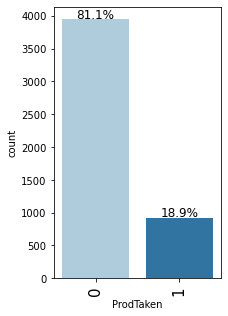

In [122]:
labeled_barplot(df_imputed, 'ProdTaken', perc=True)

As reported, we saw about 18.8% of customers buy a package. This is highly imbalanced and will have to be accounted for. Now let's see how it interacts with the other variables.

#### ProdTaken vs. Age

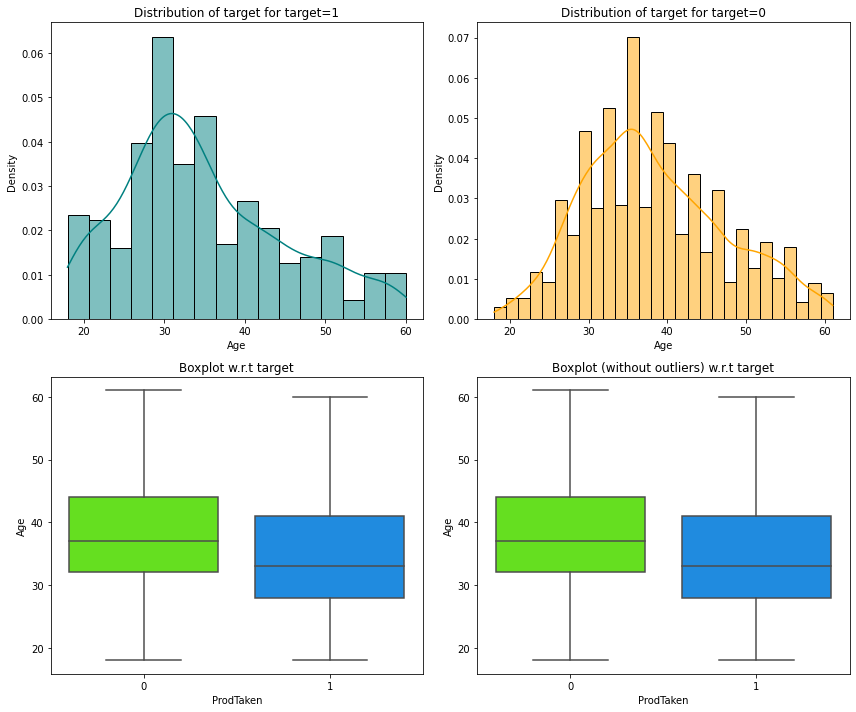

In [123]:
distribution_plot_wrt_target(df, "Age", "ProdTaken")

ProdTaken seems identical no matter the age of the customer. I doubt this will be a significant factor.

#### ProdTaken vs. TypeofContact

ProdTaken         0    1   All
TypeofContact                 
All            3944  917  4861
1              2837  607  3444
0              1107  310  1417
------------------------------------------------------------------------------------------------------------------------


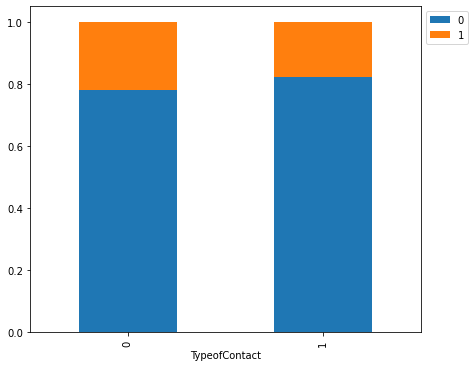

In [124]:
stacked_barplot(df, "TypeofContact", "ProdTaken")

Whether or not the person was referred by their company does not seem to greatly impact how often they bought a package. The proportions are very similar.

#### ProdTaken vs. CityTier

ProdTaken     0    1   All
CityTier                  
All        3944  917  4861
1.0        2655  518  3173
3.0        1137  353  1490
2.0         152   46   198
------------------------------------------------------------------------------------------------------------------------


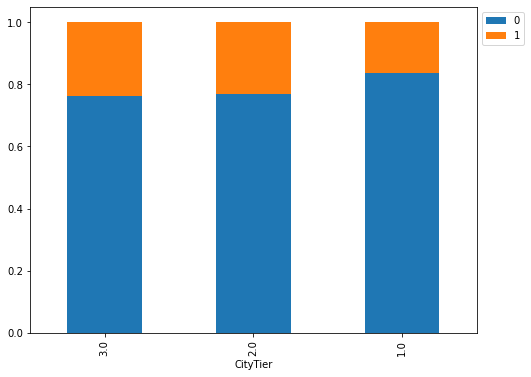

In [125]:
stacked_barplot(df_imputed, "CityTier", "ProdTaken")

If the customer lives in the nicest kind of city they seem slightly less likely to buy a travel package. Makes sense.

#### ProdTaken vs. DurationOfPitch

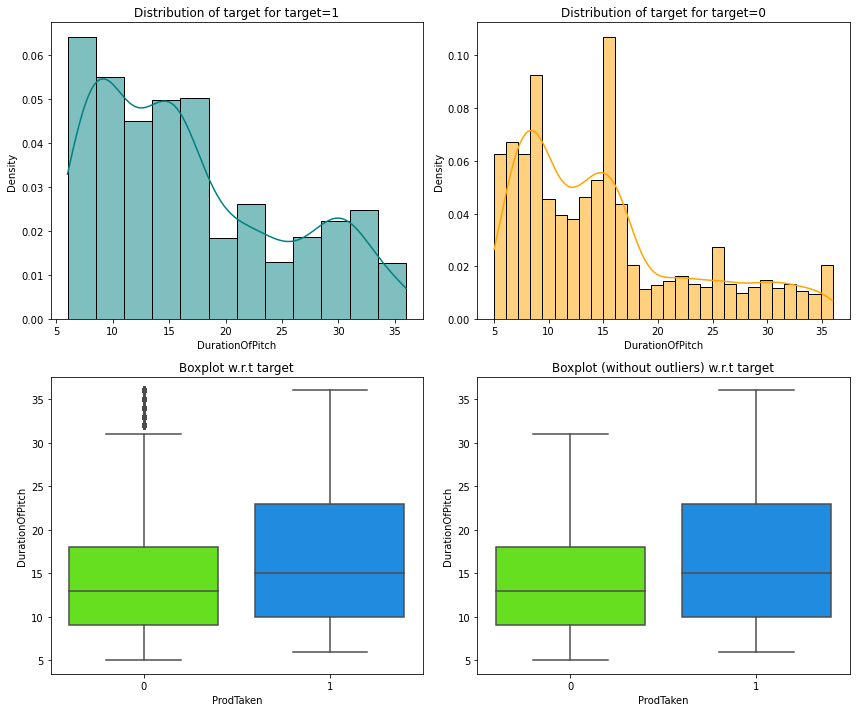

In [126]:
distribution_plot_wrt_target(df_imputed, "DurationOfPitch", "ProdTaken")

There is almost no difference between the distributions here. This factor is unlikely to matter.

#### ProdTaken vs. Occupation

ProdTaken      0    1   All
Occupation                 
All         3944  917  4861
1.0         3547  771  4318
2.0          397  142   539
0.0            0    4     4
------------------------------------------------------------------------------------------------------------------------


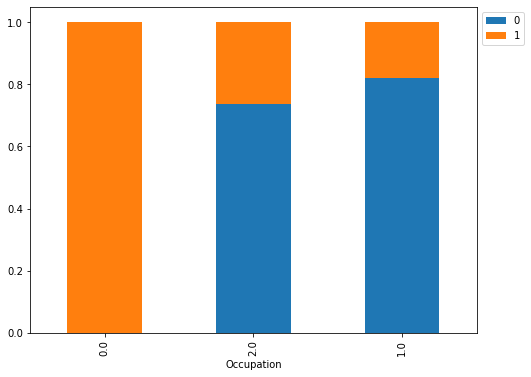

In [127]:
stacked_barplot(df_imputed, "Occupation", "ProdTaken")

I am discounting the freelancers because there are only 3 entries. It seems like those working at large businesses seem somewhat more likely to buy a package.

#### ProdTaken vs. Gender

ProdTaken     0    1   All
Gender                    
All        3944  917  4861
1.0        2324  575  2899
0.0        1620  342  1962
------------------------------------------------------------------------------------------------------------------------


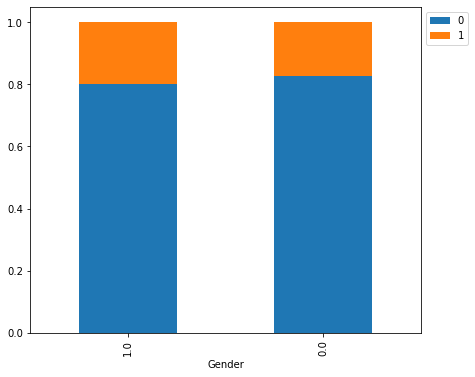

In [128]:
stacked_barplot(df_imputed, "Gender", "ProdTaken")

There seems to be no statistically significant difference between the genders.

#### ProdTaken vs. NumberOfPersonVisiting

ProdTaken                  0    1   All
NumberOfPersonVisiting                 
All                     3944  917  4861
3.0                     1934  459  2393
2.0                     1135  265  1400
4.0                      833  193  1026
1.0                       39    0    39
5.0                        3    0     3
------------------------------------------------------------------------------------------------------------------------


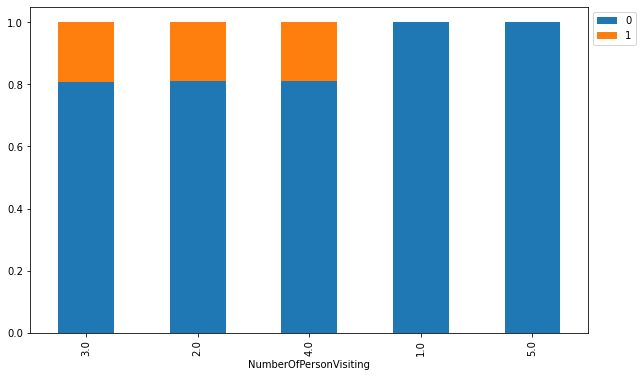

In [129]:
stacked_barplot(df_imputed, "NumberOfPersonVisiting", "ProdTaken")

Interestingly, those planning to travel alone never bought a package (I assume 1 means themselves, as there are no zeroes), but neither did those who would have traveled with 5 people.

#### ProdTaken vs. NumberOfFollowups

ProdTaken             0    1   All
NumberOfFollowups                 
All                3944  917  4861
4.0                1682  378  2060
3.0                1213  242  1455
5.0                 573  191   764
6.0                  82   54   136
2.0                 205   24   229
1.0                 152   20   172
0.0                  37    8    45
------------------------------------------------------------------------------------------------------------------------


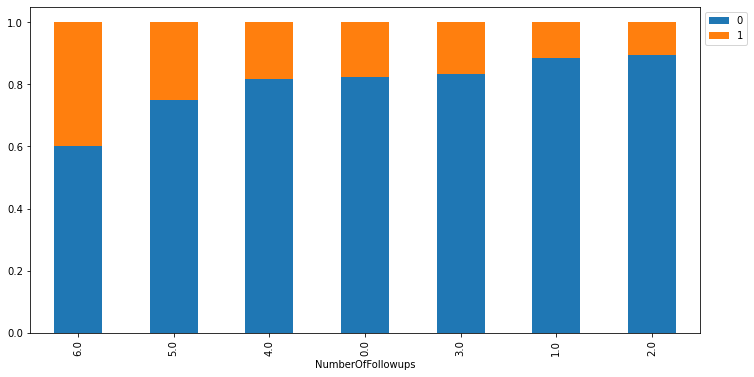

In [130]:
stacked_barplot(df_imputed, "NumberOfFollowups", "ProdTaken")

Although not linear, in general following-up 5 or 6 times is associated with more package purchases. However, this does not mean all that much, as the salesman may have followed up more times only if the customer seemed interested. More interest could have caused more follow-ups, in other words.

Honestly, because I don't know the follow-up policy, I am tempted to discount this column entirely. I'll toss it into the model anyway to see how it does.

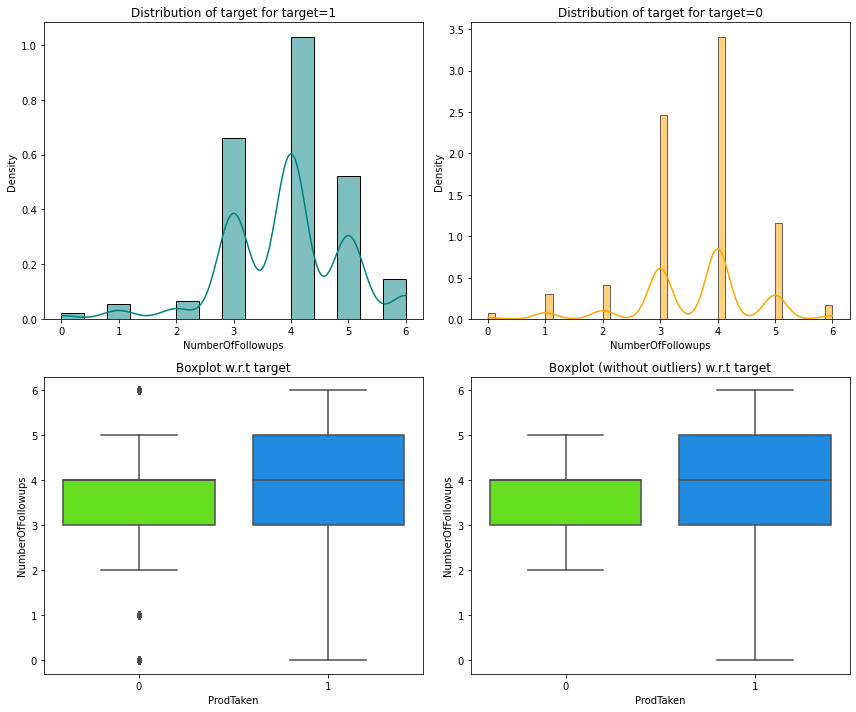

In [131]:
distribution_plot_wrt_target(df_imputed, "NumberOfFollowups", "ProdTaken")

There seems to be a weak relationship here, with more follow-ups leading to more sales.

#### ProdTaken vs. Followups_Imputed

As a reminder, this is where we imputed the NaN values in the number of follow-ups instead of making them zero.

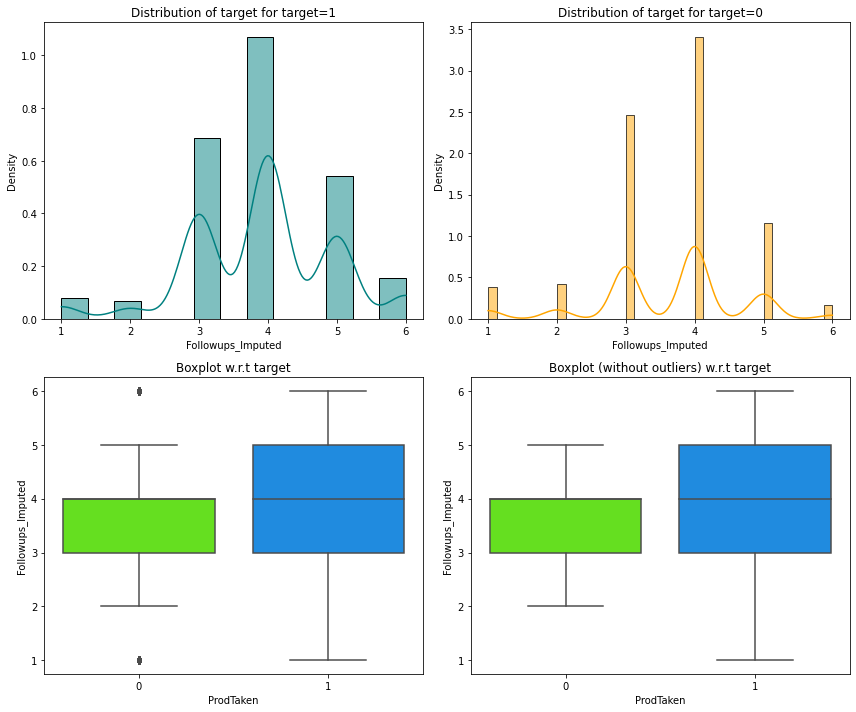

In [132]:
distribution_plot_wrt_target(df_imputed, "Followups_Imputed", "ProdTaken")

Imputing the NaN didn't seem to change anything. There is still a weak relationship.

#### ProdTaken vs. ProductPitched

ProdTaken          0    1   All
ProductPitched                 
All             3944  917  4861
0.0             1281  549  1830
1.0             1513  204  1717
3.0              618  124   742
2.0              210   20   230
4.0              322   20   342
------------------------------------------------------------------------------------------------------------------------


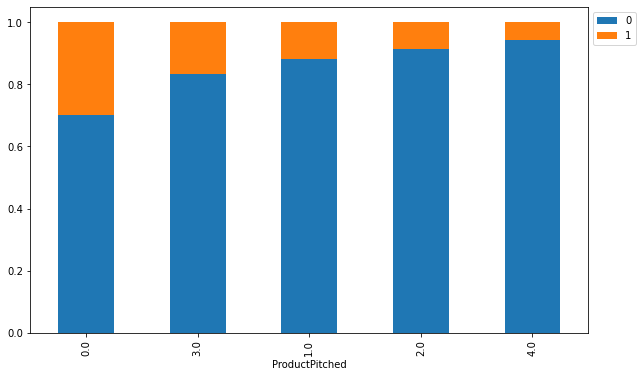

In [133]:
stacked_barplot(df_imputed, "ProductPitched", "ProdTaken")

Not only was the basic package (0) pitched more often, it was the most successful. The standard package (3) had a very good proportion of package purchasers, even though it was not pitched very often. Deluxe (1), despite being pitched almost as often as the basic package, had a much lower proportion of successes. Meanwhile, King (2) and Super Deluxe (4) performed very poorly.

I expect this variable to make a meaningful difference in the model.

#### ProdTaken vs. PreferredPropertyStar

ProdTaken                 0    1   All
PreferredPropertyStar                 
All                    3944  917  4861
3.0                    2499  482  2981
5.0                     702  249   951
4.0                     743  186   929
------------------------------------------------------------------------------------------------------------------------


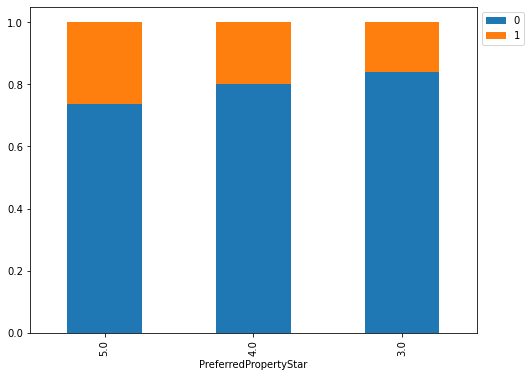

In [134]:
stacked_barplot(df_imputed, "PreferredPropertyStar", "ProdTaken")

The higher quality hotel they liked, the more likely they were to buy a package. 

This should make a difference in the models.

#### ProdTaken vs. MaritalStatus

ProdTaken         0    1   All
MaritalStatus                 
All            3944  917  4861
1.0            1997  326  2323
2.0             610  302   912
3.0             516  166   682
0.0             821  123   944
------------------------------------------------------------------------------------------------------------------------


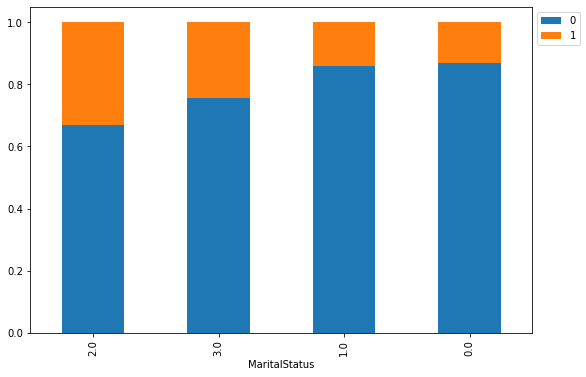

In [135]:
stacked_barplot(df_imputed, "MaritalStatus", "ProdTaken")

Married (2) individuals were more likely to buy a travel package compared to the others, with singles (3) a close second. I'm not sure how to analyze this, I have a feeling a hidden factor is the root cause of these disparities. I don't have a ready explanation for why divorced and unmarried have such a low proportion. 

Regardless, marriage seems to lead to a higher proportion of sales.

#### ProdTaken vs. NumberOfTrips

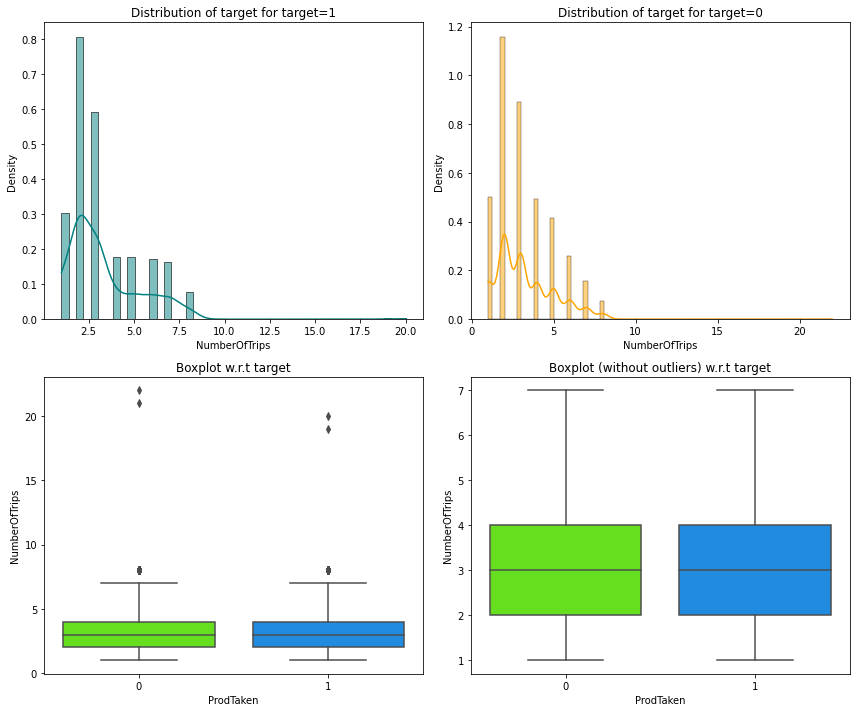

In [136]:
distribution_plot_wrt_target(df_imputed, "NumberOfTrips", "ProdTaken")

The distributions look identical regardless of whether the customer bought a package. This factor is unlikely to make a difference.

#### ProdTaken vs. Passport

ProdTaken     0    1   All
Passport                  
All        3944  917  4861
1.0         928  494  1422
0.0        3016  423  3439
------------------------------------------------------------------------------------------------------------------------


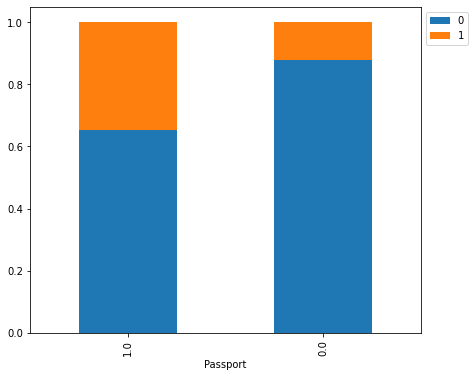

In [137]:
stacked_barplot(df_imputed, "Passport", "ProdTaken")

If they have a passport they're more likely to travel. Makes sense.

#### ProdTaken vs. OwnCar

ProdTaken     0    1   All
OwnCar                    
All        3944  917  4861
1.0        2458  558  3016
0.0        1486  359  1845
------------------------------------------------------------------------------------------------------------------------


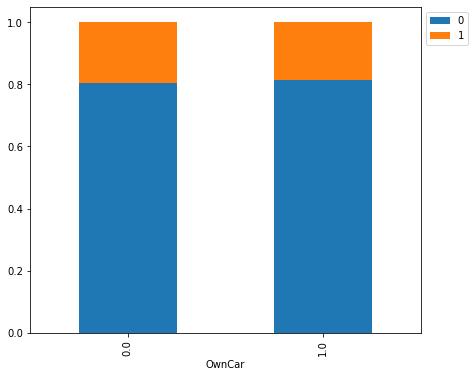

In [138]:
stacked_barplot(df_imputed, "OwnCar", "ProdTaken")

Whether or not they own a car seems to make no difference at all.

#### ProdTaken vs. NumberOfChildrenVisiting

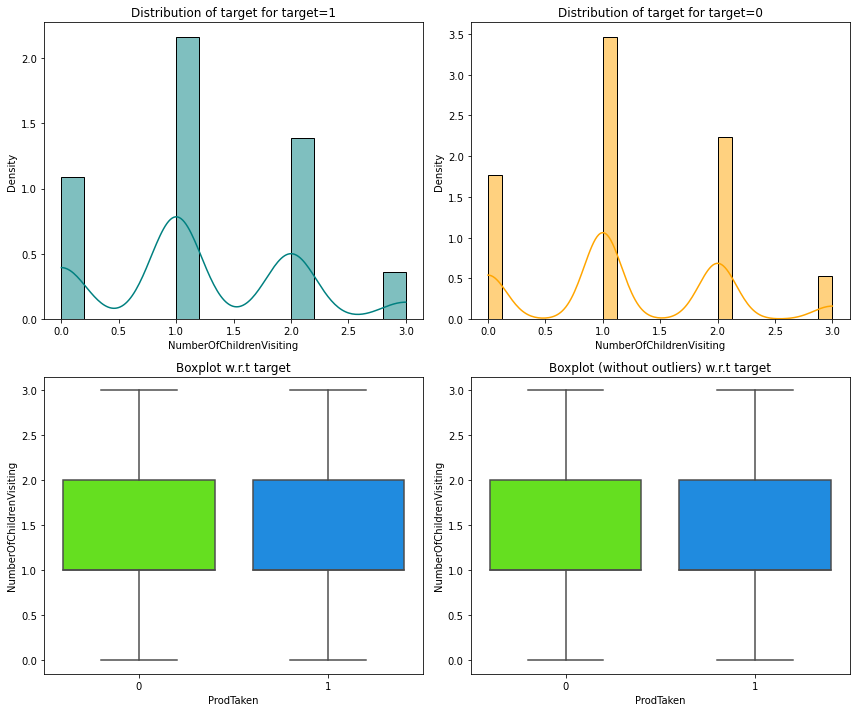

In [139]:
distribution_plot_wrt_target(df_imputed, "NumberOfChildrenVisiting", "ProdTaken")

The number of children visiting didn't seem to make any difference.

#### ProdTaken vs. Designation

ProdTaken       0    1   All
Designation                 
All          3944  917  4861
5.0          1281  549  1830
1.0          1513  204  1717
2.0           618  124   742
3.0           322   20   342
4.0           210   20   230
------------------------------------------------------------------------------------------------------------------------


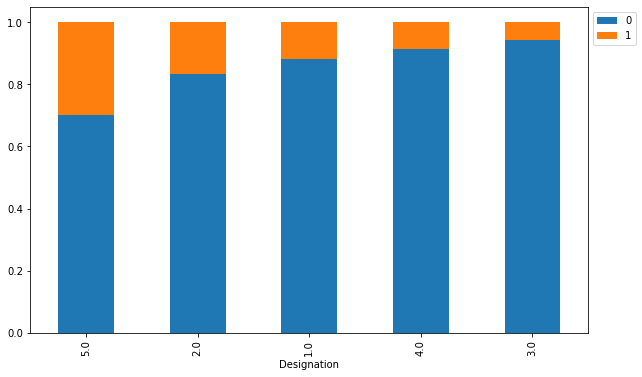

In [140]:
stacked_barplot(df_imputed, "Designation", "ProdTaken")

Executives had the highest proportion of purchases, but this variable follows a non-linear relationship. It is not "the higher up they are the more likely they are to buy a package" as the second highest proportion are senior managers.

This category should matter in the final analysis.

#### ProdTaken vs. MonthlyIncome

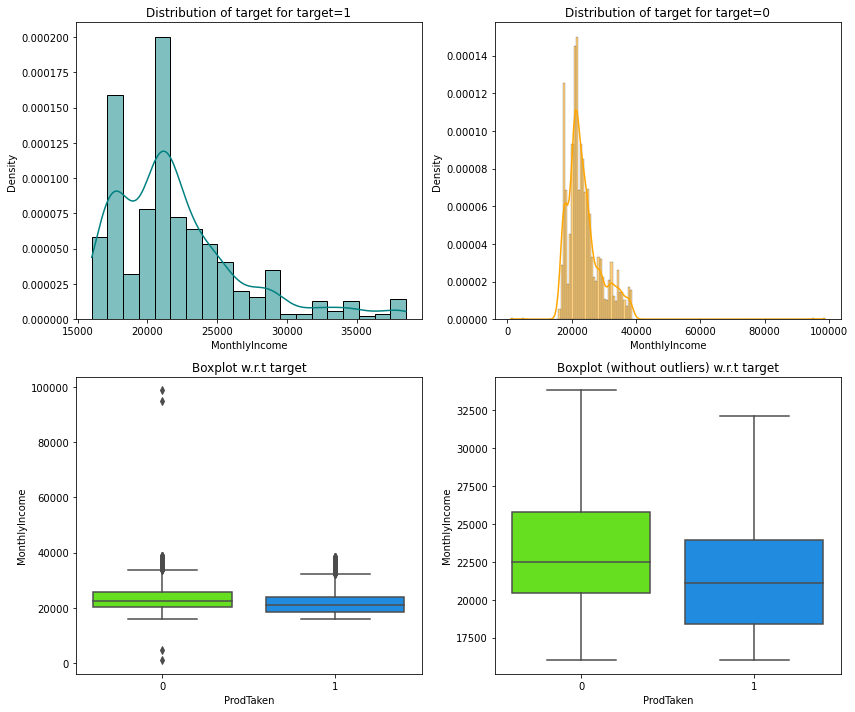

In [141]:
distribution_plot_wrt_target(df_imputed, "MonthlyIncome", "ProdTaken")

In contrast to my expectation, those with higher incomes seem to be less likely to purchase a package.

#### ProdTaken vs. Salaried

ProdTaken     0    1   All
Salaried                  
All        3944  917  4861
0.0        1996  504  2500
1.0        1948  413  2361
------------------------------------------------------------------------------------------------------------------------


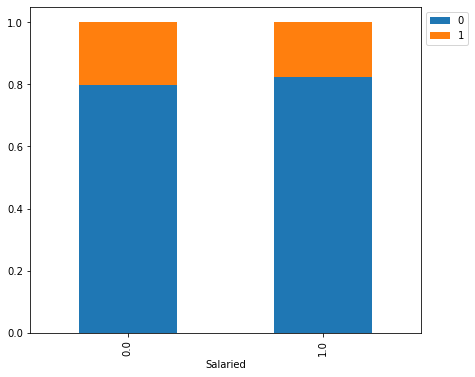

In [142]:
stacked_barplot(df_imputed, "Salaried", "ProdTaken")

Whether or not a customer is salaried seems to matter not at all. I should probably drop this one and occupation, both.

#### ProdTaken vs. PitchSatisfactionScore

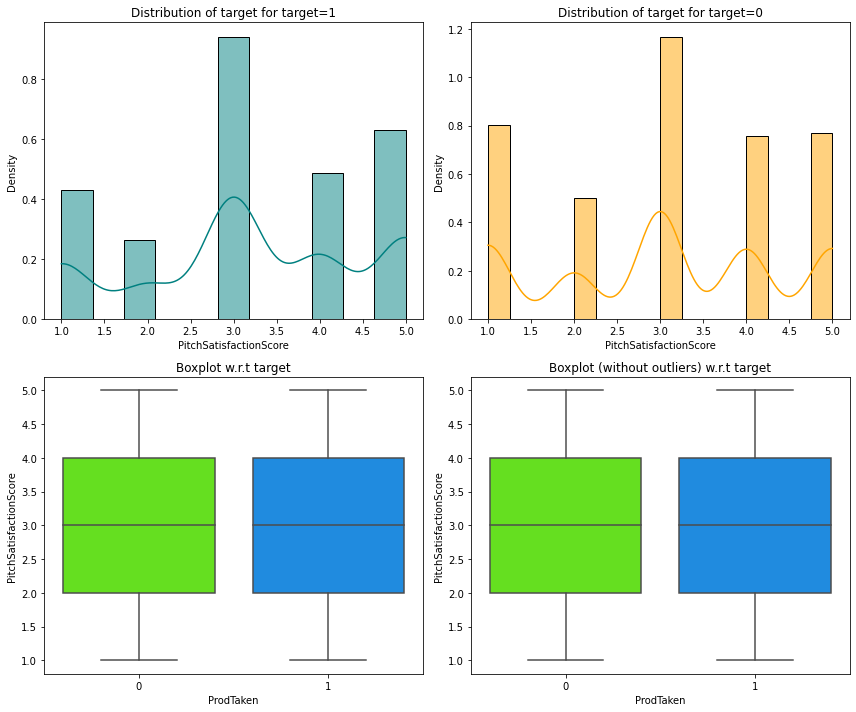

In [143]:
distribution_plot_wrt_target(df_imputed, "PitchSatisfactionScore", "ProdTaken")

Oddly, how satisfied they were with the pitch didn't seem to impact how often they bought a package much, if at all. 

Likert scales are notorious about their bias. A common solution when working with likert scales is to combine the tails with their neighbor, making "satisfied" and "highly satisfied" the same.

I'll go ahead and do that to see if it clarifies things a bit.

In [144]:
df_imputed['PitchLoveHate'] = df_imputed['PitchSatisfactionScore']
for i,row in df_imputed.iterrows():
    if df_imputed.at[i,'PitchLoveHate']==5:
        df_imputed.at[i,'PitchLoveHate'] = 4 
for i,row in df_imputed.iterrows():
    if df_imputed.at[i,'PitchLoveHate']==1:
        df_imputed.at[i,'PitchLoveHate'] = 2 

In [145]:
df_imputed['PitchLoveHate'].value_counts()

4    1877
2    1518
3    1466
Name: PitchLoveHate, dtype: int64

ProdTaken         0    1   All
PitchLoveHate                 
All            3944  917  4861
4              1505  372  1877
3              1152  314  1466
2              1287  231  1518
------------------------------------------------------------------------------------------------------------------------


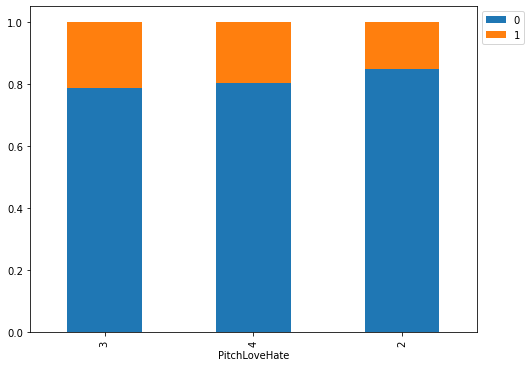

In [146]:
stacked_barplot(df_imputed, "PitchLoveHate", "ProdTaken")

From this we can conclude the following:

If they don't hate your pitch, they're slightly more likely to buy a package. If they hate the pitch, they're slightly less likely to buy.

The influence of this is very small, though. It may not show up as impactful in the model.

### Observations on PitchSatisfactionScore

I kept pitch satisfaction until last because I thought for sure it would impact sales more than it did. Given that overall it does not, I'll not bother with a lengthy investigation of this variable overall.

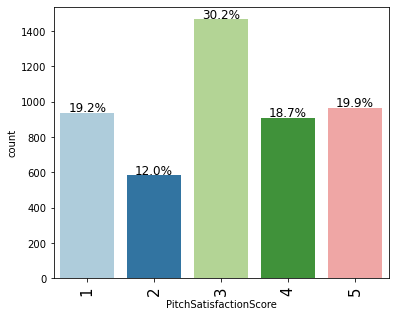

In [147]:
labeled_barplot(df_imputed, 'PitchSatisfactionScore', perc=True)

I see the bias I expected to see from information gathered via likert scales: the middle and tails tend to be greater than the middle numbers.

Overall the customers seemed to like our pitches more than they disliked them, but not by much.

I am curious how this interacted with product pitched.

PitchSatisfactionScore    1    2     3    4    5   All
ProductPitched                                        
All                     935  583  1466  910  967  4861
1.0                     350  218   542  280  327  1717
0.0                     353  203   548  388  338  1830
3.0                     146  102   202  144  148   742
2.0                      40   34    48   50   58   230
4.0                      46   26   126   48   96   342
------------------------------------------------------------------------------------------------------------------------


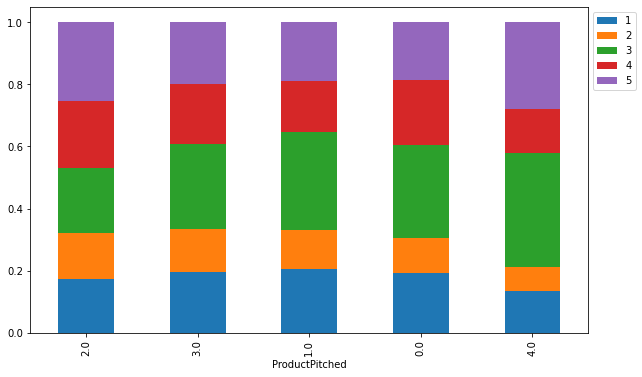

In [148]:
stacked_barplot(df_imputed, "ProductPitched", "PitchSatisfactionScore")

People seem much more satisfied with the pitches for king (2) and super deluxe (4). This is very weird, as these were the most underperforming products. There has to be more variables at play here. I'm going to have to separate the data by product to tease it out.

## Separation by Product

Each of the products pitched probably performed differently across different groups. Although we do not know what the packages look like, marketing does. They should be able to identify which old package is most similar to the new package. Consequently, it would be useful to them to know who was buying which package, and which customer interactions worked best.

To gain this information, I will separate the database by product pitched, and then try to predict sales by product rather than generally.

This means I am assuming a 1 in ProdTaken does not mean "bought a package." Instead, I am assuming a 1 to mean "bought the package pitched in ProductPitched." I think this is a safe assumption, though, because how would the customer know about the other packages unless it was pitched to them?



In [149]:
#Separating the data by product pitched/sold.
dfbasic = df_imputed[df_imputed["ProductPitched"]==0]
dfdeluxe = df_imputed[df_imputed["ProductPitched"]==1]
dfking = df_imputed[df_imputed["ProductPitched"]==2]
dfStandard = df_imputed[df_imputed["ProductPitched"]==3]
dfSuperD = df_imputed[df_imputed["ProductPitched"]==4]

Now I am going to check the shapes to see if I split correctly. It should be the same as the value counts for their respective product.

In [150]:
df_imputed['ProductPitched'].value_counts()

0.0    1830
1.0    1717
3.0     742
4.0     342
2.0     230
Name: ProductPitched, dtype: int64

In [151]:
dfbasic.shape

(1830, 22)

In [152]:
dfdeluxe.shape

(1717, 22)

In [153]:
dfking.shape

(230, 22)

In [154]:
dfStandard.shape

(742, 22)

In [155]:
dfSuperD.shape

(342, 22)

Looks good.

## Correlations

### Overall

In [156]:
#Salaried shouldn't be in the numerical columns.
num_cols.remove('Salaried')

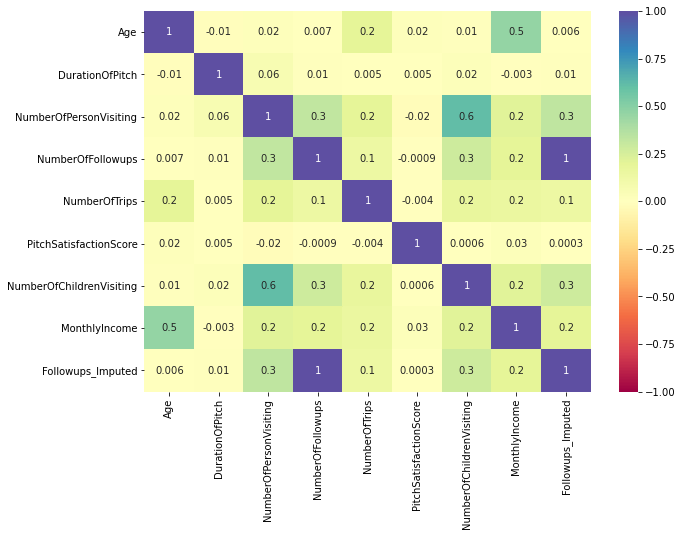

In [157]:
#Making correlation heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df_imputed[num_cols].corr(),annot=True,vmin=-1,vmax=1,fmt='.1g',cmap="Spectral")
plt.show()

Age correlates moderately to income, no surprise there. Number of children correlates to number of people visiting, which is good. Everything else is a very weak correlation. (Well, the two followup columns are perfectly correlated, of course.)

Overall, everything seems very independent.

## EDA Conclusions

Here are all of the conclusions we derived from the EDA:

* Age seems unimportantTypeofContact seems unimportant
* CityTier: The nicer the city, the less likely they'll buy a package
* Duration of pitch doesn't matter
* Large businesses more likely to buy a package
* Gender is unimportant
* Traveling alone or with 5 people means they won't buy a package
* Generally, more follow-ups the better
* Product Pitched makes a big difference, especially basic (0)
* Five star hotel lovers = more likely to buy
* Married (2) more likely to buy a package, with singles (3) close second
* Number of trips is unimportant
* Having a passport is hugely important
* Owning a car is unimportant
* Number of children under 5 seems unimportant
* Being an executive means they're more likely to buy a package. Non-linear relationship.
* Higher income less likely to buy.
* Salaried is unimportant
* If they don't hate your pitch, they're slightly more likely to buy a package.

A lot of these are "unimportant" in general, but remember that if a factor is important in one direction for one package and important for another package in the other direction then they'll cancel out when the packages are grouped together. Thus, it is entirely possible for, say, CityTier to be very important for some packages but not others.

The only way to check these things is to build models for each package individually and see which factors predict package purchase.

# Model Building for ProdTaken

## Approach
1. Split the data into the train and test set.
2. Train naked models on the training data.
3. Try to improve the model performance using hyperparameter tuning.
4. Test the performance on the test data.
5. Compare all model types
6. Repeat for each package separately

## Model evaluation Criteria

### The model can make wrong predictions as:
1. Predicting a customer will buy a package when they will not.
2. Predicting a customer won't buy a package when they will.

### Which case is more important? 
1. If a customer is pitched a product they won't buy, it wastes the salesman's time.
2. If a customer who will buy isn't contacted, we lose out on the income from their purchase.

### Which metric to optimize?

Because we do not know the hourly wages of the sales department, and we do not know the profit of any of the packages, we cannot assess which type of error is more egregious. Therefore, we just want to minimize error.

However, the model's target variable is highly imbalanced. Therefore, accuracy is an inappropriate measure.

This means that F1 will be the primary evaluation criteria for all models. This will paint us the most accurate picture of what customer is most likely to buy any given package, and allow us to construct good profiles.



In [158]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
        },
        index=[0],
    )

    return df_perf

In [159]:
#Making a function for displaying confusion matrices with percentages and such
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

# Overall Models

I'm going to do every kind of model to see what predicts best for the dataset overall before looking at each product individually.

## Splitting the data

In [160]:
# Separating features and the target column
X = df_imputed.drop(['ProdTaken','PitchLoveHate','Followups_Imputed',], axis=1)
y = df_imputed['ProdTaken']

In [161]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(3402, 19) (1459, 19)


Now we need to double check that y is distributed equally among test and train.

In [162]:
y.value_counts(1)

0    0.811356
1    0.188644
Name: ProdTaken, dtype: float64

In [163]:
y_test.value_counts(1)

0    0.811515
1    0.188485
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

## Bagging Classifier

   Accuracy   Recall  Precision        F1
0  0.994709  0.97352   0.998403  0.985804
   Accuracy    Recall  Precision        F1
0  0.923235  0.658182   0.909548  0.763713


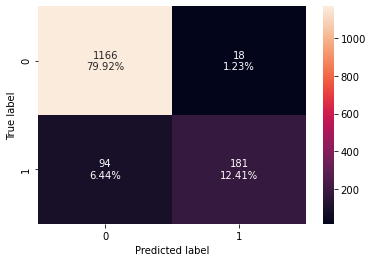

In [164]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* Bagging is overfitting, with large losses in performance, mostly from Recall.

### Hypertuning the bagging classifier

In [165]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.9, max_samples=0.9, n_estimators=50,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy    Recall  Precision        F1
0  0.999412  0.998442   0.998442  0.998442
   Accuracy    Recall  Precision        F1
0   0.93146  0.687273   0.931034  0.790795


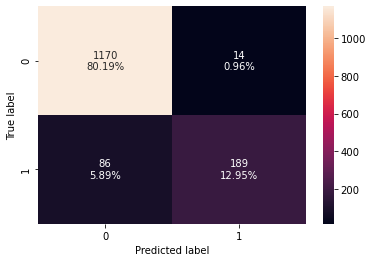

In [166]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Hypertuning helped some, improving everything a little.

## AdaBoost Classifier

   Accuracy    Recall  Precision        F1
0  0.849794  0.352025    0.70405  0.469367
   Accuracy    Recall  Precision        F1
0  0.851268  0.363636   0.704225  0.479616


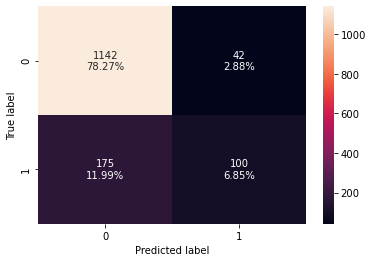

In [167]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* No overfit but poor performance

### Hypertuning the AdaBoost Classifier

In [168]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy    Recall  Precision        F1
0  0.987654  0.950156   0.983871  0.966719
   Accuracy    Recall  Precision        F1
0  0.886909  0.610909   0.743363  0.670659


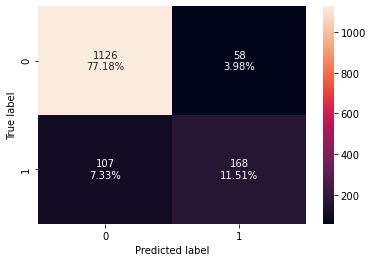

In [169]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

* Huge increase in performance accompanied by similarly huge increase in overfitting.
* Overall performance is still poor

## Gradient Boosting Classifier

Training performance:
    Accuracy    Recall  Precision        F1
0  0.889477  0.493769   0.861413  0.627723
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.873886  0.436364   0.805369  0.566038


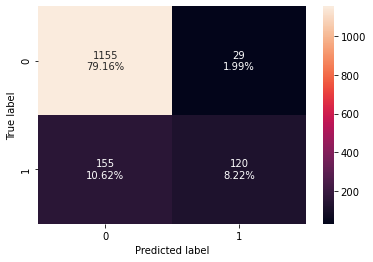

In [170]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* Gradient Boosting is not overfitting much but its performance is poor. Let's see how tuning helps.

### Hypertuning the Gradient Boosting Classifier

In [171]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

Training performance:
    Accuracy    Recall  Precision        F1
0  0.927102  0.649533   0.947727  0.770795
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.884853  0.516364    0.80226  0.628319


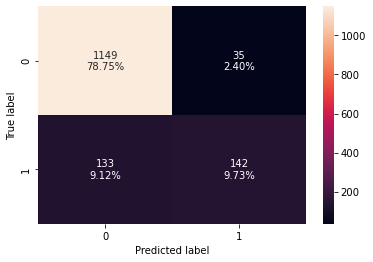

In [172]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* Some performance gain, recall increased some, but still overall poor performance
* Overfitting more than before

## XGBoost Classifier

Training performance:
    Accuracy    Recall  Precision        F1
0  0.999706  0.998442        1.0  0.999221
Testing performance:
    Accuracy    Recall  Precision     F1
0  0.942426  0.756364   0.924444  0.832


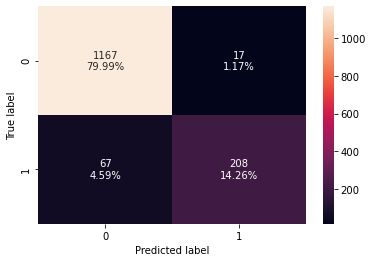

In [173]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Performance is pretty good but there is still some overfitting.
* Still struggling with Recall

### Hypertuning the Gradient Boosting Classifier

In [174]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy    Recall  Precision       F1
0  0.981188  0.995327   0.912857  0.95231
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.917066  0.854545   0.743671  0.795262


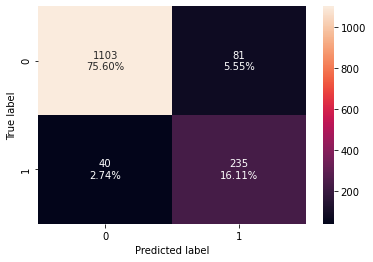

In [175]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* The hypertuned XGBClassifier has a worse performance, but is much more generalizable because it has been cross-validated. It is not overfitting as much.

## Random Forest Classifier

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.930089  0.676364   0.934673  0.78481


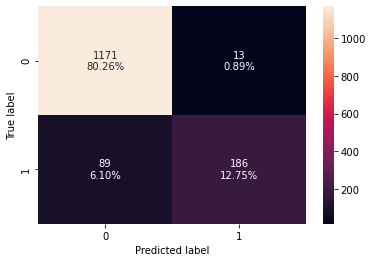

In [176]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* Decent performance but overfitting the data

### Hypertuning the Random Forest Classifier

In [177]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.18, 1: 0.82}, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=80, n_jobs=None, oob_score=True,
                       random_state=1, verbose=0, warm_start=False)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.995003  0.998442   0.975647  0.986913
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.929404  0.738182   0.867521  0.797642


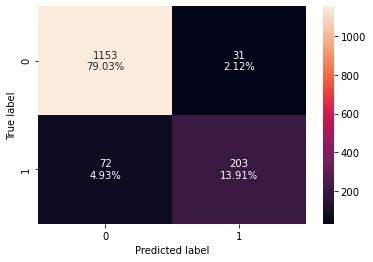

In [178]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

* Less overfitting and a decent F1 performance after hypertuning though still plenty of of overfit overall.

## Decision Tree

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.909527  0.774545    0.75265  0.763441


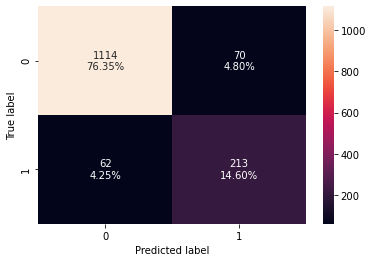

In [179]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

* Decision trees always overfit without hypertuning. So, we have to tune it.

### Hypertuning the Decision Tree

In [180]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.18, 1: 0.72},
                       criterion='gini', max_depth=7, max_features=None,
                       max_leaf_nodes=15, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')

Training performance:
    Accuracy    Recall  Precision        F1
0  0.805115  0.643302   0.487603  0.554735
Testing performance:
    Accuracy  Recall  Precision       F1
0  0.804661    0.64   0.486188  0.55259


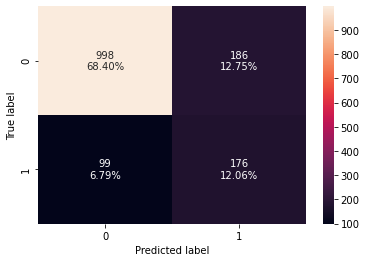

In [181]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

* Hypertuning restricted the depth, number of leaf nodes, and other hyperparameters, preventing the tree from growing until all nodes were pure.
* It's not overfitting anymore, but that is a horrible performance.

## Stacking Classifier

In [182]:
estimators = [('Bagging', bagging_estimator_tuned), ('Adaboost',abc_tuned),
              ('Random Forest',rf_tuned), ('Gradient Boosting',gbc_tuned),
              ('Decision Tree',dtree_estimator)]

final_estimator = xgb_tuned

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('Bagging',
                                BaggingClassifier(base_estimator=None,
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  max_features=0.9,
                                                  max_samples=0.9,
                                                  n_estimators=50, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=1, verbose=0,
                                                  warm_start=False)),
                               ('Adaboost',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0....
                                                 max_delta_step=0,

Training performance:
    Accuracy  Recall  Precision        F1
0  0.995003     1.0   0.974203  0.986933
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.930775  0.927273   0.758929  0.834697


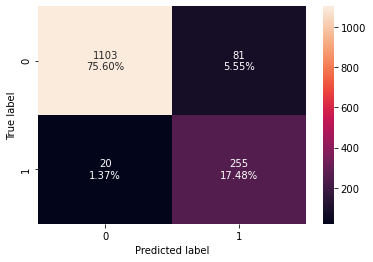

In [183]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

* Interestingly, all other models struggled with Recall, but this one struggled with Precision.
* Decent model overall.

## Comparing All Models

In [184]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.805115,1.0,0.995003,0.994709,0.999412,0.849794,0.987654,0.889477,0.927102,0.999706,0.981188,0.995003
Recall,1.0,0.643302,1.0,0.998442,0.973520,0.998442,0.352025,0.950156,0.493769,0.649533,0.998442,0.995327,1.000000
Precision,1.0,0.487603,1.0,0.975647,0.998403,0.998442,0.704050,0.983871,0.861413,0.947727,1.000000,0.912857,0.974203
F1,1.0,0.554735,1.0,0.986913,0.985804,0.998442,0.469367,0.966719,0.627723,0.770795,0.999221,0.952310,0.986933


In [185]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adabosst Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adabosst Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.909527,0.804661,0.930089,0.929404,0.923235,0.931460,0.851268,0.886909,0.873886,0.884853,0.942426,0.917066,0.930775
Recall,0.774545,0.640000,0.676364,0.738182,0.658182,0.687273,0.363636,0.610909,0.436364,0.516364,0.756364,0.854545,0.927273
Precision,0.752650,0.486188,0.934673,0.867521,0.909548,0.931034,0.704225,0.743363,0.805369,0.802260,0.924444,0.743671,0.758929
F1,0.763441,0.552590,0.784810,0.797642,0.763713,0.790795,0.479616,0.670659,0.566038,0.628319,0.832000,0.795262,0.834697


The top three models are:
1. Random Forest Tuned
2. XGBoost Tuned
3. Stacking Classifier

These models all have low bias, with Stacking being the best in this regard.

The tuned Random Forest has cross-validation mixed in because of the grid search. This means it should be a more robust model, less prone to variance and more generalizable.

Between the tuned Random Forest and the Stacking Classifier, the Stacking Classifier has better performance and has also been cross validated to some degree because XGBoost Tuned is actually used as its final estimator.

Therefore because the performances are otherwise similar, I'd choose the Stacking Classifier.

## Feature Importance and Analysis Overall

I cannot find the feature importance of a stacking classifier, none of the typical methods work. However, these things tend to be similar across models. I'll just look at the feature importances of the metaclassifier (the tuned XGB model).

I'll be using shap to get a good idea of the directionality of the features.

In [186]:
#Defining shap variables
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X)

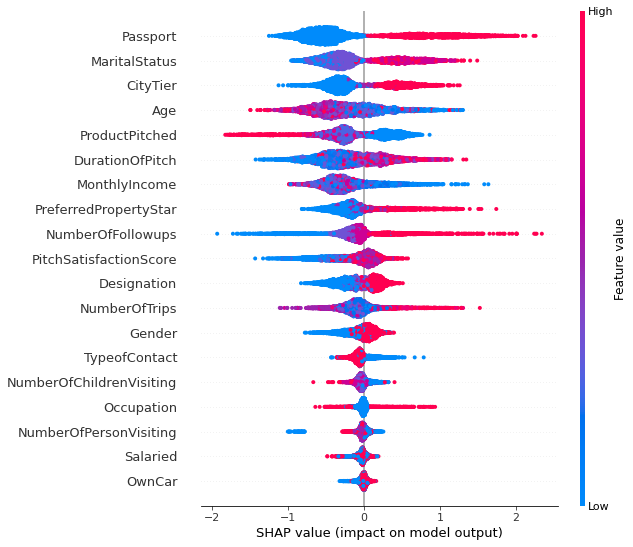

In [187]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

Just a guide on that graph: Red values are higher, blue are lower. The further to the right, the more likely that value was to predict that person would buy a package. The further to the left, the more likely that value was to predict the person would not buy a package. So, a red dot to the right would mean a high value predicts a purchase. Purple means it is unclear, or not a high/low value.

The features are listed in importance from top to bottom. The most important seems to be passport, though it is similar in strength to many other factors. It is, however, the most clear-cut.

Of particular note is the ProductPitched variable. The very low values mean the customer is moderately more likely to purchase a package, and the very high values mean the customer is much less likely to purchase a package, but there is a huge bundle of purple, meaning the middle values of ProductPitched have a slightly negative impact on whether the customer will purchase a package.

I think splitting the models by product pitched will become very interesting. That it is so important means that the product pitched is having a big impact one way or the other: and this is getting in the way of us building customer profiles. After all, "a customer who is pitched the basic package" is a very poor descriptor of customers most likely to purchase a basic package.

Otherwise, the relationships above mirror what I described in the EDA, with a few differences. For example the EDA predicted no impact from age, but the model says differently. Same for duration of pitch. Largely, the trends were similar, though.

From this we can derive the following general customer profile. In other words, these are the types of people who are most likely to buy any kind of package:

* Has a passport
* Is unmarried
* Is younger
* Lives in a tier 3 city
* Has a low income
* Likes 5 star hotels
* Travels a lot normally

These factors have a smaller impact, but could still matter
* Is the executive in their company
* Is male
* Was company-invited
* Owns a car
* Doesn't have very many children visiting
* Works at a large company
* Doesn't have many people visiting

That said, I think the package-specific models will be more elucidating.

I'd also like to say that the customer interactions did have an impact, so the behavior of the sales agent matters even if pitch satisfaction had a small impact. Rather than make generalizations, I'd like to craft pitch recommendations dependent on each package. I'll explore what kinds of pitches do best after I split the model by package.

In [189]:
#Saving the model so I can use it later if I want.
Overall_model = stacking_classifier

In [190]:
#Saving the feature rank so I can compare it to other models later
Overall_Featurerank = list(reversed(X.columns[np.argsort(np.abs(shap_values).mean(0))]))

In [191]:
#Extracting the performance of the best model for Overall.
Overall_best = pd.DataFrame(stacking_classifier_model_test_perf)
Overall_best['Classifier'] = 'Stacking'
Overall_best['Package'] = 'All'
Overall_best
#I'll combine this with the other models later for easy comparison.

,Accuracy,Recall,Precision,F1,Classifier,Package
0,0.930775,0.927273,0.758929,0.834697,Stacking,All


## Model building for the Basic Package

We're going to do the same thing as above, but just analyzing the results for the basic package.

Remember, because each pitch only pitched a single package, we know that if ProdTaken = 1 that means they bought the product pitched specifically.

A reminder: We are looking at f1 as our performance metric for all of the models we're building. Accuracy is inappropriate because of imbalance, and we don't know which kind of error is worse, so we're just minimizing error.

### Splitting the data

In [192]:
# Separating features and the target column
X = dfbasic.drop(['ProdTaken','PitchLoveHate','Followups_Imputed','ProductPitched',
                 'Designation'], axis=1) #I discovered removing Designation improved the model.
y = dfbasic['ProdTaken']

In [193]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(1281, 17) (549, 17)


Now we need to double check that y is distributed equally among test and train.

In [194]:
y.value_counts(1)

0    0.7
1    0.3
Name: ProdTaken, dtype: float64

In [195]:
y_test.value_counts(1)

0    0.699454
1    0.300546
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

### Bagging Classifier for the Basic Package

   Accuracy    Recall  Precision        F1
0  0.992974  0.976562        1.0  0.988142
   Accuracy    Recall  Precision        F1
0  0.867031  0.715152   0.819444  0.763754


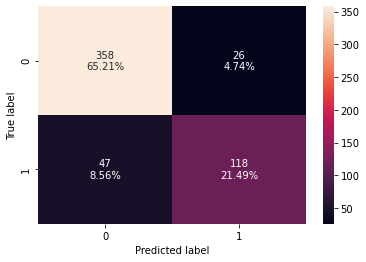

In [196]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* Bagging is overfitting, with poor f1 performance, mostly from Recall.

#### Hypertuning the Bagging Classifier for the Basic Package

In [197]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.9, max_samples=0.9, n_estimators=40,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision        F1
0  0.897996  0.769697   0.875862  0.819355


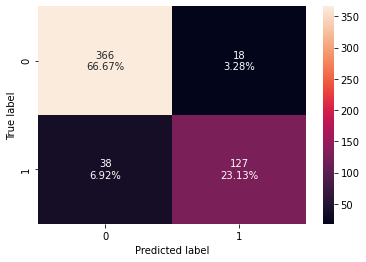

In [198]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Hypertuning helped a good amount but we're still seeing poor performance in Recall, which is dragging down the f1 score.
* It's clearly overfitting the data.

## AdaBoost Classifier for the Basic Package

   Accuracy    Recall  Precision        F1
0  0.825917  0.598958   0.769231  0.673499
   Accuracy    Recall  Precision        F1
0  0.777778  0.515152   0.669291  0.582192


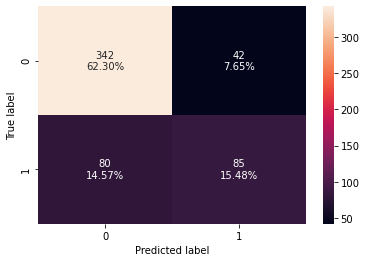

In [199]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* No too overfit but poor performance

#### Hypertuning the AdaBoost Classifier for the Basic Package

In [200]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision       F1
0  0.848816  0.709091   0.769737  0.73817


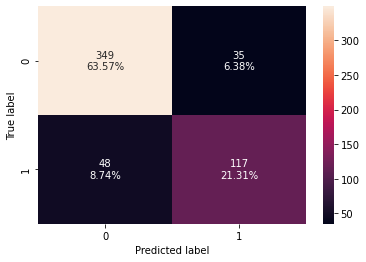

In [201]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

* Huge increase in performance accompanied by similarly huge increase in overfitting.
* Overall performance is still mediocre

## Gradient Boosting Classifier for the Basic Package

Training performance:
    Accuracy    Recall  Precision        F1
0  0.906323  0.736979   0.937086  0.825073
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.821494  0.587879    0.76378  0.664384


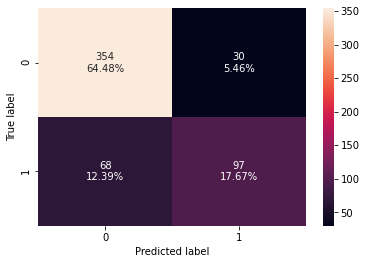

In [202]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* Gradient Boosting is not overfitting much but its performance is poor. Let's see how tuning helps.

#### Hypertuning the Gradient Boosting Classifier for the Basic Package

In [203]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

Training performance:
    Accuracy    Recall  Precision        F1
0  0.967994  0.903646   0.988604  0.944218
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.845173  0.654545   0.794118  0.717608


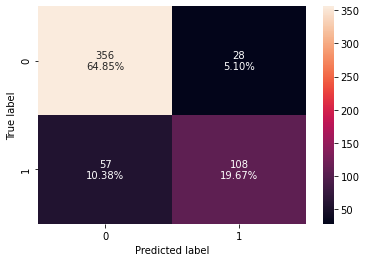

In [204]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* Some performance gain, still overall poor performance
* Still overfitting

## XGBoost Classifier for the Basic Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.901639  0.818182   0.849057  0.833333


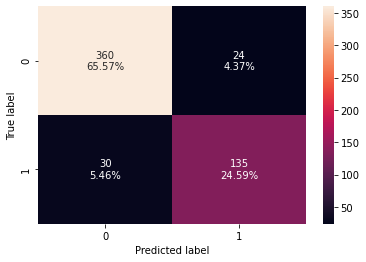

In [205]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Performance is pretty good but there is still some overfitting.

#### Hypertuning the XGBoost Classifier for the Basic Package

In [206]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=0.7,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision        F1
0  0.990632     1.0   0.969697  0.984615
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.870674  0.866667   0.744792  0.80112


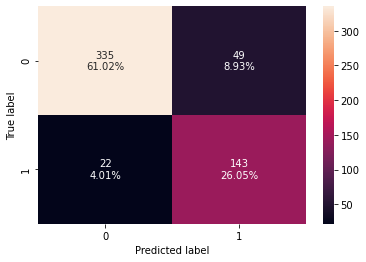

In [207]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* The hypertuned XGBClassifier almost identical performance, but is much more generalizable. It is not overfitting as much and has been cross-validated.

## Random Forest Classifier for the Basic Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.908925  0.775758   0.907801  0.836601


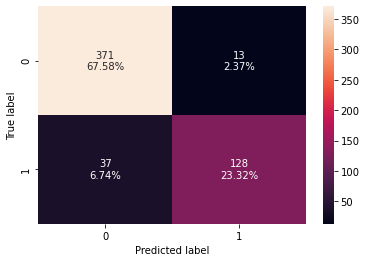

In [208]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* Decent performance but overfitting the data

#### Hypertuning the Random Forest Classifier for the Basic Package

In [209]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.18, 1: 0.82}, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=70, n_jobs=None, oob_score=True,
                       random_state=1, verbose=0, warm_start=False)

Training performance:
    Accuracy  Recall  Precision        F1
0  0.991413     1.0   0.972152  0.985879
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.867031  0.806061   0.764368  0.784661


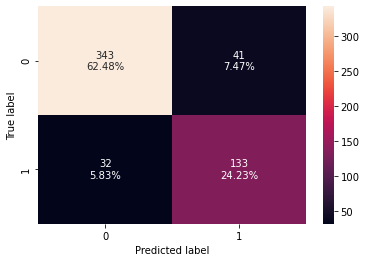

In [210]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

* Less overfitting but overall a lower F1 performance and a high degree of overfit

## Decision Tree for the Basic Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.846995  0.757576   0.739645  0.748503


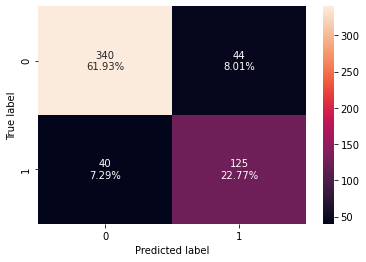

In [211]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

* Decision trees always overfit without hypertuning. So, we have to tune it.

#### Hypertuning the Decision Tree for the Basic Package

In [212]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.18, 1: 0.72},
                       criterion='gini', max_depth=7, max_features=None,
                       max_leaf_nodes=15, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=7,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')

Training performance:
    Accuracy    Recall  Precision        F1
0  0.720531  0.924479   0.519006  0.664794
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.703097  0.872727   0.503497  0.638581


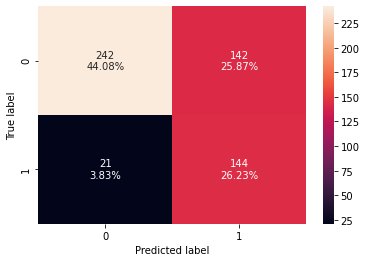

In [213]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

* It's not overfitting anymore, but that is a horrible performance.

## Stacking Classifier for the Basic Package

In [214]:
estimators = [('Bagging', bagging_estimator_tuned), ('Adaboost',abc_tuned),
              ('Gradient Boosting',gbc_tuned),('Decision Tree',dtree_estimator),
              ('Random Forest', rf_tuned)]

final_estimator = xgb_tuned 

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('Bagging',
                                BaggingClassifier(base_estimator=None,
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  max_features=0.9,
                                                  max_samples=0.9,
                                                  n_estimators=40, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=1, verbose=0,
                                                  warm_start=False)),
                               ('Adaboost',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0....
                                                 max_delta_step=0,

Training performance:
    Accuracy  Recall  Precision        F1
0  0.996097     1.0   0.987147  0.993532
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.857923  0.836364   0.730159  0.779661


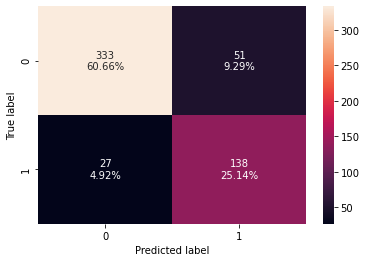

In [215]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

* Again, all other models struggled with Recall, but this one struggled with Precision.
* Decent model overall.

## Comparing All Models for the Basic Package

In [216]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.720531,1.0,0.991413,0.992974,1.0,0.825917,1.0,0.906323,0.967994,1.0,0.990632,0.996097
Recall,1.0,0.924479,1.0,1.000000,0.976562,1.0,0.598958,1.0,0.736979,0.903646,1.0,1.000000,1.000000
Precision,1.0,0.519006,1.0,0.972152,1.000000,1.0,0.769231,1.0,0.937086,0.988604,1.0,0.969697,0.987147
F1,1.0,0.664794,1.0,0.985879,0.988142,1.0,0.673499,1.0,0.825073,0.944218,1.0,0.984615,0.993532


In [217]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.846995,0.703097,0.908925,0.867031,0.867031,0.897996,0.777778,0.848816,0.821494,0.845173,0.901639,0.870674,0.857923
Recall,0.757576,0.872727,0.775758,0.806061,0.715152,0.769697,0.515152,0.709091,0.587879,0.654545,0.818182,0.866667,0.836364
Precision,0.739645,0.503497,0.907801,0.764368,0.819444,0.875862,0.669291,0.769737,0.763780,0.794118,0.849057,0.744792,0.730159
F1,0.748503,0.638581,0.836601,0.784661,0.763754,0.819355,0.582192,0.738170,0.664384,0.717608,0.833333,0.801120,0.779661


Because overthing is overfitting pretty badly, I'm going to put emphasis on the models that have been cross-validated. That means the tuned models get priority.

The top models are:
1. Random Forest Tuned
2. Bagging Estimator Tuned
3. Stacking Classifier
4. XGBoost Tuned

These models all have fairly low bias, with tuned Bagging Estimator being the best in this regard. Each of the top 3 models should be less prone to variance because of cross-validation.

I am somewhat concerned with overfitting (high train performance low test performance), but all three models are overfit. The only model I made without much overfit is the decision tree, and its performance is horrible.

I see no reason, then, to not go with the Tuned Bagging Estimator as the best model for the Basic Package.


## Feature Importance and Analysis for Basic Package

SHAP doesn't seem to work well with the Random Forest model, it's giving me errors. However, these things tend to be pretty similar across models, especially since the performance differences are slight. I'll just look at the feature importances of the tuned XGB model, since it works.

I'll be using shap to get a good idea of the directionality of the features.

In [218]:
#Defining shap variables
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X)

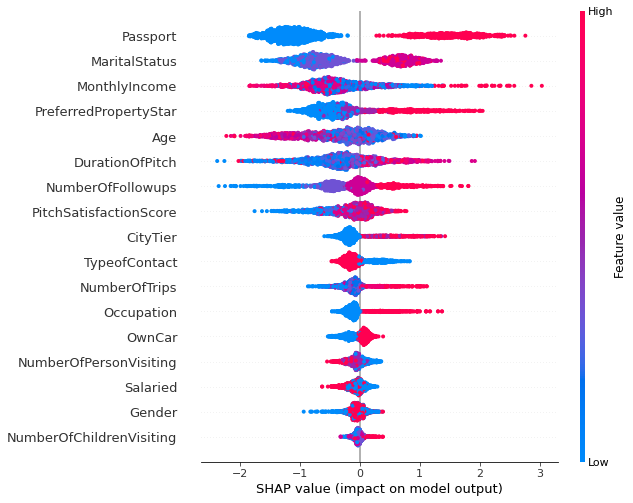

In [219]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

Remember that the basic package was the largest contributor to the dataset by far, so it should be most similar to the overall picture. Indeed, that does seem to be the case.

* Passport is the standout factor, which is no surprise.
* Martial status has a bit impact as well, and looks similar to the overall shap summary.
* Age became a little bit more distinct, with the higher ages being much less clumped around 0 impact and instead more strongly predicting the customer won't buy the package.
* Monthly income flipped somewhat in directionality. In the overall model, no high incomes predicted a purchase, whereas here a significant number of high incomes predicted a purchase.
* Pitch Satisfaction became much clearer, with higher scores predicting a purchase and lower predicting no purchase. This makes sense, and implies this factor in the overall model was likely being mixed up by high satisfaction being less important for some packages than others.
* Interestingly, occupation jumped in importance for this package. The larger the company, the more likely they were to purchase a package.

Compared to overall, I'd say the customer profile here has the following adjustments:

* Younger
* Single or Unmarried


In [221]:
#Saving the model in case I want it later
Basic_model = bagging_estimator_tuned

In [222]:
#Saving feature ranks for comparisons later
Basic_Featurerank = list(reversed(X.columns[np.argsort(np.abs(shap_values).mean(0))]))

In [223]:
#Extracting best model performance for comparisons later
Basic_best = pd.DataFrame(bagging_estimator_tuned_model_test_perf)
Basic_best['Classifier'] = 'Bagging Tuned'
Basic_best['Package'] = 'Basic'
Basic_best

,Accuracy,Recall,Precision,F1,Classifier,Package
0,0.897996,0.769697,0.875862,0.819355,Bagging Tuned,Basic


## Model building for the Deluxe Package

We're going to do the same thing as above, but just analyzing the results for the Deluxe package.

As a reminder, we're looking at f1 score for performance for all models.

### Splitting the data

In [224]:
# Separating features and the target column
X = dfdeluxe.drop(['ProdTaken','PitchLoveHate','Followups_Imputed','ProductPitched'], axis=1)
y = dfdeluxe['ProdTaken']

In [225]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(1201, 18) (516, 18)


Now we need to double check that y is distributed equally among test and train.

In [226]:
y.value_counts(1)

0    0.881188
1    0.118812
Name: ProdTaken, dtype: float64

In [227]:
y_test.value_counts(1)

0    0.881783
1    0.118217
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

### Bagging Classifier for the Deluxe Package

   Accuracy    Recall  Precision        F1
0  0.995004  0.958042        1.0  0.978571
   Accuracy    Recall  Precision        F1
0  0.939922  0.655738        0.8  0.720721


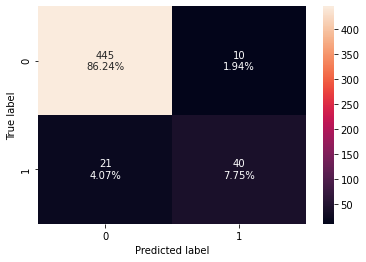

In [228]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* Bagging is overfitting, with overall poor performance.

#### Hypertuning the Bagging Classifier for the Deluxe Package

In [229]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.9, max_samples=0.9, n_estimators=30,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy    Recall  Precision        F1
0  0.997502  0.979021        1.0  0.989399
   Accuracy    Recall  Precision        F1
0  0.939922  0.590164   0.857143  0.699029


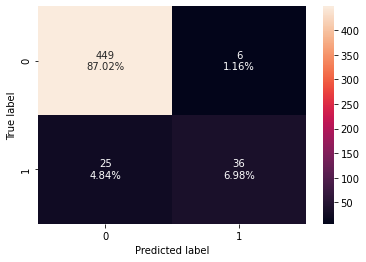

In [230]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Hypertuning didn't do much at all. Performance is about the same and it is still overfit.

## AdaBoost Classifier for the Deluxe Package

   Accuracy    Recall  Precision       F1
0  0.910075  0.307692   0.830189  0.44898
   Accuracy    Recall  Precision        F1
0  0.887597  0.213115   0.565217  0.309524


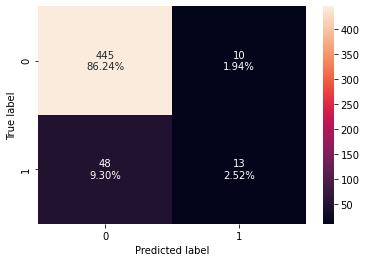

In [231]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* Performance is awful and it's even overfit somehow.

#### Hypertuning the AdaBoost Classifier for the Deluxe Package

In [232]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision        F1
0  0.930233  0.704918   0.704918  0.704918


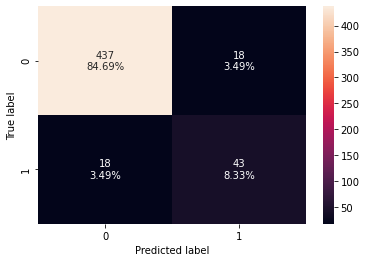

In [233]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

* Huge increase in performance, more than doubling it. Wow.
* Still seems to be overfitting some.
* Overall performance is still mediocre, just not quite so bad.

## Gradient Boosting Classifier for the Deluxe Package

Training performance:
    Accuracy    Recall  Precision        F1
0  0.957535  0.643357        1.0  0.782979
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.916667  0.393443        0.8  0.527473


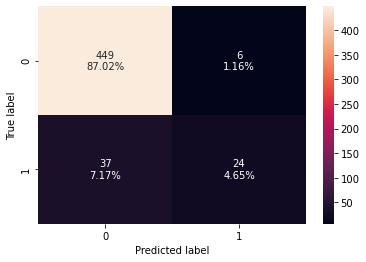

In [234]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* Gradient Boosting's performance is poor and it is overfit. Let's see how tuning helps.

#### Hypertuning the Gradient Boosting Classifier for the Deluxe Package

In [235]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

Training performance:
    Accuracy    Recall  Precision       F1
0  0.994172  0.951049        1.0  0.97491
Testing performance:
    Accuracy   Recall  Precision        F1
0  0.934109  0.57377   0.813953  0.673077


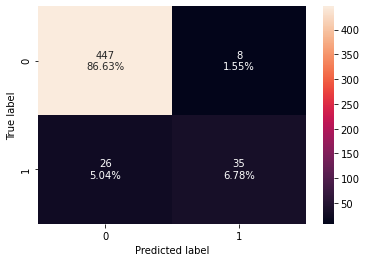

In [236]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* Good performance gain, making performance mediocre
* Still overfitting

## XGBoost Classifier for the Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.955426  0.770492   0.839286  0.803419


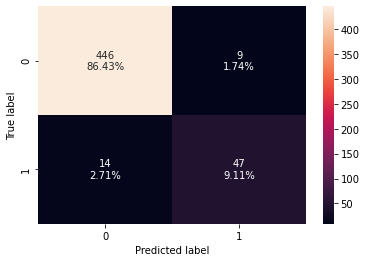

In [237]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Performance is pretty good
* still some overfitting.

#### Hypertuning the XGBoost Classifier for the Deluxe Package

In [238]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.955426  0.868852   0.779412  0.821705


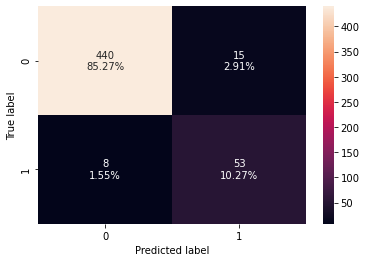

In [239]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* The hypertuned XGBClassifier has a pretty decent performance.
* Small increase in f1
* Overfitting still

## Random Forest Classifier for the Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.932171  0.508197   0.861111  0.639175


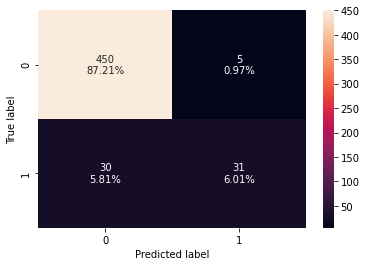

In [240]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* Mediocre performance and overfitting the data

#### Hypertuning the Random Forest Classifier for the Deluxe Package

In [241]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.18, 1: 0.82}, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=True,
                       random_state=1, verbose=0, warm_start=False)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.995004  0.972028   0.985816  0.978873
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.947674  0.688525       0.84  0.756757


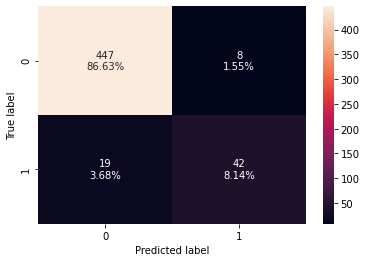

In [242]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

* Tuning reduced overfitting and increased performance
* Overall f1 still mediocre

## Decision Tree for the Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.914729  0.737705   0.616438  0.671642


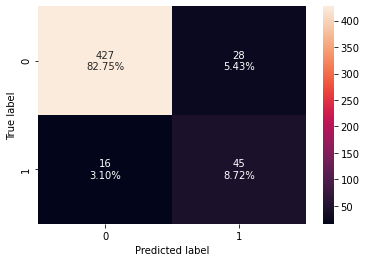

In [243]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

* Decision trees always overfit without hypertuning. So, we have to tune it.

#### Hypertuning the Decision Tree for the Deluxe Package

In [244]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.18, 1: 0.72},
                       criterion='gini', max_depth=7, max_features=None,
                       max_leaf_nodes=15, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')

Training performance:
    Accuracy    Recall  Precision        F1
0  0.850958  0.762238   0.429134  0.549118
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.80814  0.655738   0.338983  0.446927


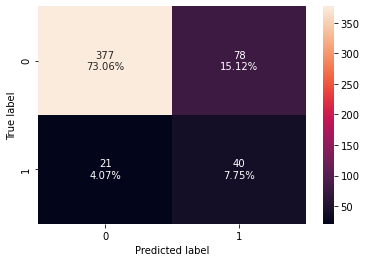

In [245]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

* It's not overfitting anymore, but that is a horrible performance.
* Performance dropped after tuning

## Stacking Classifier for the Deluxe Package

In [246]:
estimators = [('Bagging', bagging_estimator_tuned), ('Adaboost',abc_tuned),
              ('Gradient Boosting',gbc_tuned),('Decision Tree',dtree_estimator),
              ('Random Forest', rf_tuned)]

final_estimator = xgb_tuned 

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('Bagging',
                                BaggingClassifier(base_estimator=None,
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  max_features=0.9,
                                                  max_samples=0.9,
                                                  n_estimators=30, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=1, verbose=0,
                                                  warm_start=False)),
                               ('Adaboost',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0....
                                                 max_delta_step=0,

Training performance:
    Accuracy  Recall  Precision        F1
0  0.996669     1.0   0.972789  0.986207
Testing performance:
    Accuracy    Recall  Precision     F1
0  0.947674  0.803279   0.765625  0.784


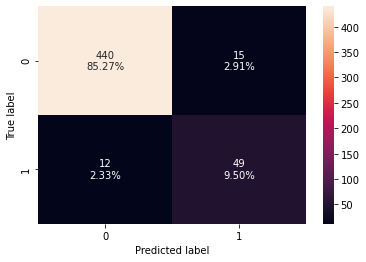

In [247]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

* Overfit a lot
* Performance is mediocre

## Comparing All Models for the Deluxe Package

In [248]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.850958,1.0,0.995004,0.995004,0.997502,0.910075,1.0,0.957535,0.994172,1.0,1.0,0.996669
Recall,1.0,0.762238,1.0,0.972028,0.958042,0.979021,0.307692,1.0,0.643357,0.951049,1.0,1.0,1.000000
Precision,1.0,0.429134,1.0,0.985816,1.000000,1.000000,0.830189,1.0,1.000000,1.000000,1.0,1.0,0.972789
F1,1.0,0.549118,1.0,0.978873,0.978571,0.989399,0.448980,1.0,0.782979,0.974910,1.0,1.0,0.986207


In [249]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.914729,0.808140,0.932171,0.947674,0.939922,0.939922,0.887597,0.930233,0.916667,0.934109,0.955426,0.955426,0.947674
Recall,0.737705,0.655738,0.508197,0.688525,0.655738,0.590164,0.213115,0.704918,0.393443,0.573770,0.770492,0.868852,0.803279
Precision,0.616438,0.338983,0.861111,0.840000,0.800000,0.857143,0.565217,0.704918,0.800000,0.813953,0.839286,0.779412,0.765625
F1,0.671642,0.446927,0.639175,0.756757,0.720721,0.699029,0.309524,0.704918,0.527473,0.673077,0.803419,0.821705,0.784000


The top three models, again prioritizing tuned, are:
1. XGBoost Tuned
2. Random Forest Tuned
3. Stacking classifier

The performance for this package is overall not great, but XGBoost tuned managed to get the highest.

The tuned XGBoost also has cross-validation mixed in because of the grid search. This means it should be a more robust model, less prone to variance and more generalizable.

This makes the tuned XGBoost the clear winner for this package.


## Feature Importance and Analysis for the Deluxe Package

I'll be using shap of the xgboost tuned model to get a good idea of the directionality of the features.

In [250]:
#Defining shap variables
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X)

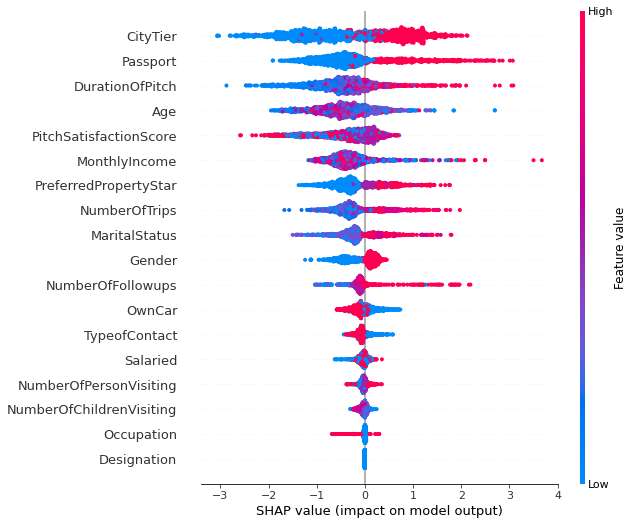

In [251]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

This package is different from overall as well.

* Having a passport is still important
* CityTier, a middling factor overall, is hugely important for Deluxe. The worse the city tier, the more likely they want to travel.
* Pitch Satisfaction also jumped in importance, with Deluxe purchases much more sensitive to pitch. Unfortunately, directionality is garbled.
* Income directionality is a bit garbled.

The customer profile for Deluxe is about the same as the other packages so far:

* Lives in a bad city
* Has a passport
* Didn't hate the pitch
* Lower income for the most part

In [253]:
#Saving the model for later use
Deluxe_model = xgb_tuned

In [254]:
#Saving feature ranks for later comparisons
Deluxe_Featurerank = list(reversed(X.columns[np.argsort(np.abs(shap_values).mean(0))]))

In [255]:
#Extracting model performance for later comparisons
Deluxe_best = pd.DataFrame(xgb_tuned_model_test_perf)
Deluxe_best['Classifier'] = 'XGBoost Tuned'
Deluxe_best['Package'] = 'Deluxe'
Deluxe_best

,Accuracy,Recall,Precision,F1,Classifier,Package
0,0.955426,0.868852,0.779412,0.821705,XGBoost Tuned,Deluxe


## Model building for the King Package

We're going to do the same thing as above, but just analyzing the results for the Deluxe package.

### Splitting the data

In [256]:
# Separating features and the target column
X = dfking.drop(['ProdTaken','PitchLoveHate','Followups_Imputed','ProductPitched'], axis=1)
y = dfking['ProdTaken']

In [257]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(161, 18) (69, 18)


Now we need to double check that y is distributed equally among test and train.

In [258]:
y.value_counts(1)

0    0.913043
1    0.086957
Name: ProdTaken, dtype: float64

In [259]:
y_test.value_counts(1)

0    0.913043
1    0.086957
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

### Bagging Classifier for the King Package

   Accuracy    Recall  Precision        F1
0  0.993789  0.928571        1.0  0.962963
   Accuracy    Recall  Precision        F1
0  0.985507  0.833333        1.0  0.909091


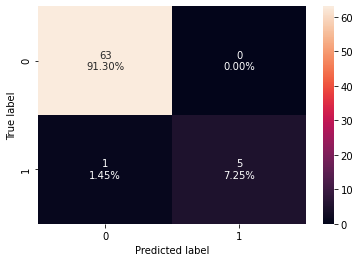

In [260]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* That's a very strong performance overall. Let's see if tuned can improve it some.

#### Hypertuning the Bagging Classifier for the King Package

In [261]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.7, max_samples=0.8, n_estimators=30,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy  Recall  Precision        F1
0  0.956522     0.5        1.0  0.666667


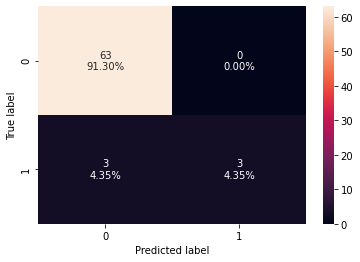

In [262]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Nope. It got much worse, which is weird.

With smaller datasets I expect variance to be a much bigger problem. That makes cross-validation ever more important. I think dataset size is what explains how tuning ruined the performance: It had good performance by chance and cross-validation revealed its true performance.

## AdaBoost Classifier for the King Package

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision        F1
0  0.985507  0.833333        1.0  0.909091


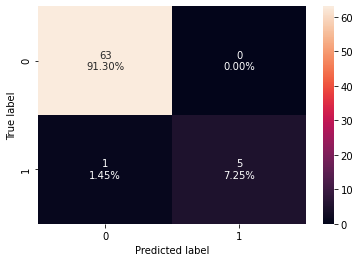

In [263]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* Excellent performance, let's see if tuning ruins it like before.

#### Hypertuning the AdaBoost Classifier for the King Package

In [264]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


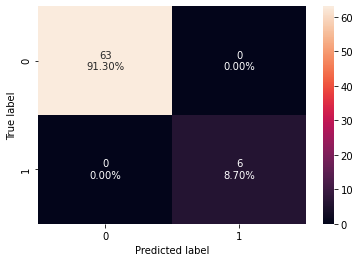

In [265]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

Perfect performance, excellent. Hypertuning helped.

*Note: The variance for this package is very high, and I was unable to change some of the random parameters. Therefore, if you re-run this package's models, some of the hypertuning results change. This is one of those: sometimes it is perfect, sometimes it isn't. Regardless, it does not greatly alter the final analysis*

## Gradient Boosting Classifier for the King Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


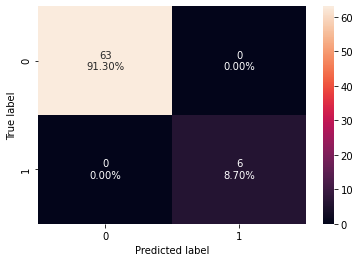

In [266]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* Another perfect model. Let's see if it holds up after cross validation.

#### Hypertuning the Gradient Boosting Classifier for the King Package

In [267]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.9, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


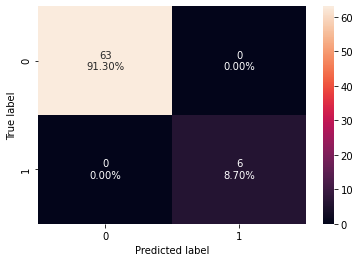

In [268]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

Yep. Nice.

We're going to have some good info for marketing on this package.

## XGBoost Classifier for the King Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision   F1
0  0.942029     0.5       0.75  0.6


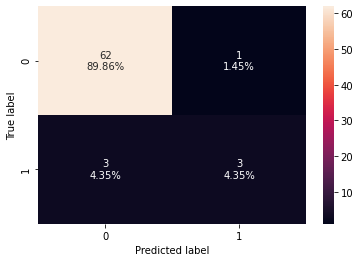

In [269]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

Non-perfect f1 score means we can skip this one unless hypertuning helps

#### Hypertuning the XGBoost Classifier for the King Package

In [270]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=0.9,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision        F1
0  0.993789     1.0   0.933333  0.965517
Testing performance:
    Accuracy  Recall  Precision   F1
0  0.956522     1.0   0.666667  0.8


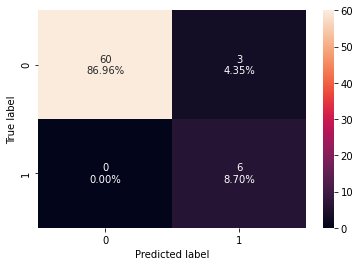

In [271]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

Hypertuning increased performance. It falls short of perfection, but its f1 score is very solid now.

## Random Forest Classifier for the King Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.956522     0.5        1.0  0.666667


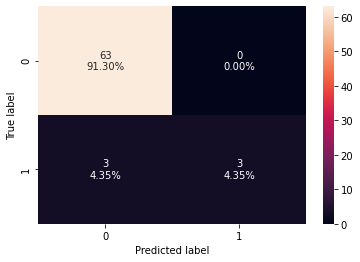

In [272]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* Decent performance but needs tuning and cross-validation.

#### Hypertuning the Random Forest Classifier for the King Package

In [273]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.18, 1: 0.82}, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=20, n_jobs=None, oob_score=True,
                       random_state=1, verbose=0, warm_start=False)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision   F1
0  0.971014  0.666667        1.0  0.8


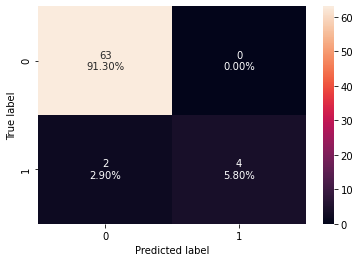

In [274]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

Hypertuning increased f1 score.

## Decision Tree for the King Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.956522     0.5        1.0  0.666667


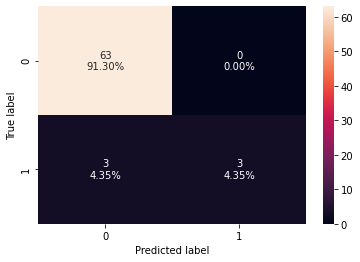

In [275]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

* Decision trees always overfit without hypertuning. So, we have to tune it.

#### Hypertuning the Decision Tree for the King Package

In [276]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.18, 1: 0.72},
                       criterion='gini', max_depth=5, max_features=None,
                       max_leaf_nodes=10, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')

Training performance:
    Accuracy  Recall  Precision        F1
0  0.981366     1.0   0.823529  0.903226
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.971014     1.0       0.75  0.857143


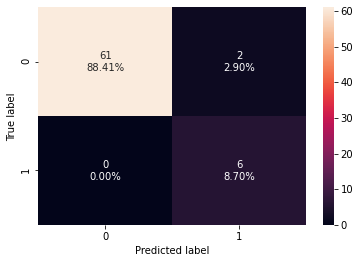

In [277]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

Tuning increased performance.

## Stacking Classifier for the King Package

In [278]:
estimators = [('Bagging', bagging_estimator_tuned), ('Adaboost',abc_tuned),
              ('Gradient Boosting',gbc_tuned),('Decision Tree',dtree_estimator),
              ('Random Forest', rf_tuned)]

final_estimator = xgb_tuned 

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('Bagging',
                                BaggingClassifier(base_estimator=None,
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  max_features=0.7,
                                                  max_samples=0.8,
                                                  n_estimators=30, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=1, verbose=0,
                                                  warm_start=False)),
                               ('Adaboost',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0....
                                                 max_delta_step=0,

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


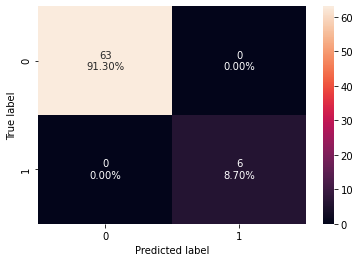

In [279]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

Excellent model.

## Comparing All Models for the King Package

In [280]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.981366,1.0,1.0,0.993789,1.0,1.0,1.0,1.0,1.0,1.0,0.993789,1.0
Recall,1.0,1.000000,1.0,1.0,0.928571,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0
Precision,1.0,0.823529,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.933333,1.0
F1,1.0,0.903226,1.0,1.0,0.962963,1.0,1.0,1.0,1.0,1.0,1.0,0.965517,1.0


In [281]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.956522,0.971014,0.956522,0.971014,0.985507,0.956522,0.985507,1.0,1.0,1.0,0.942029,0.956522,1.0
Recall,0.500000,1.000000,0.500000,0.666667,0.833333,0.500000,0.833333,1.0,1.0,1.0,0.500000,1.000000,1.0
Precision,1.000000,0.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,0.750000,0.666667,1.0
F1,0.666667,0.857143,0.666667,0.800000,0.909091,0.666667,0.909091,1.0,1.0,1.0,0.600000,0.800000,1.0


It's important to keep in mind that this dataset is very small. When we generalize ANY of these models, we're not going to continue to see perfect predictions. However, I am encouraged by these results. The following models predicted extremely well even after cross-validation:

* Decision Tree Tuned
* Random Forest Tuned
* Gradient Boost Tuned

Given the performance, I'm going to pick the one that is most similar between training and testing, and between tuned and untuned, which would be Gradient Boost. It had identical performance on training and test whether it was tuned or not.

## Feature Importance and Analysis for King Package

It is important for my interpretations that I not just get feature importance, but also the directionality of the features. When I use shap on the other models, it just gives me importances rather than case-by-case directionality.

Because of that, I will continue to look at the feature importance of the xgb model.

In [282]:
#Defining shap variables
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X)

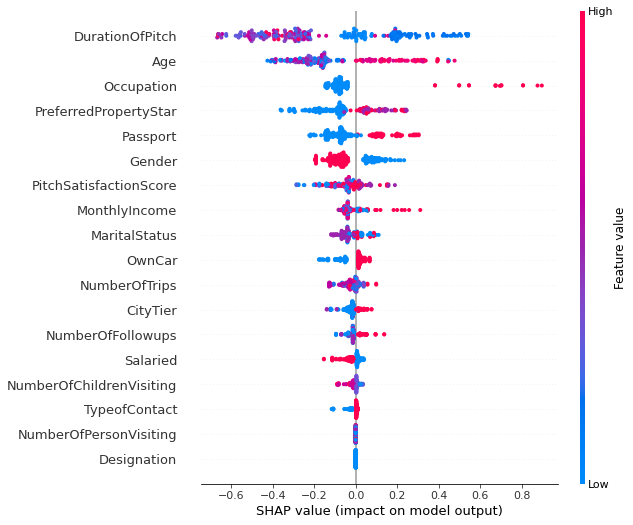

In [283]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

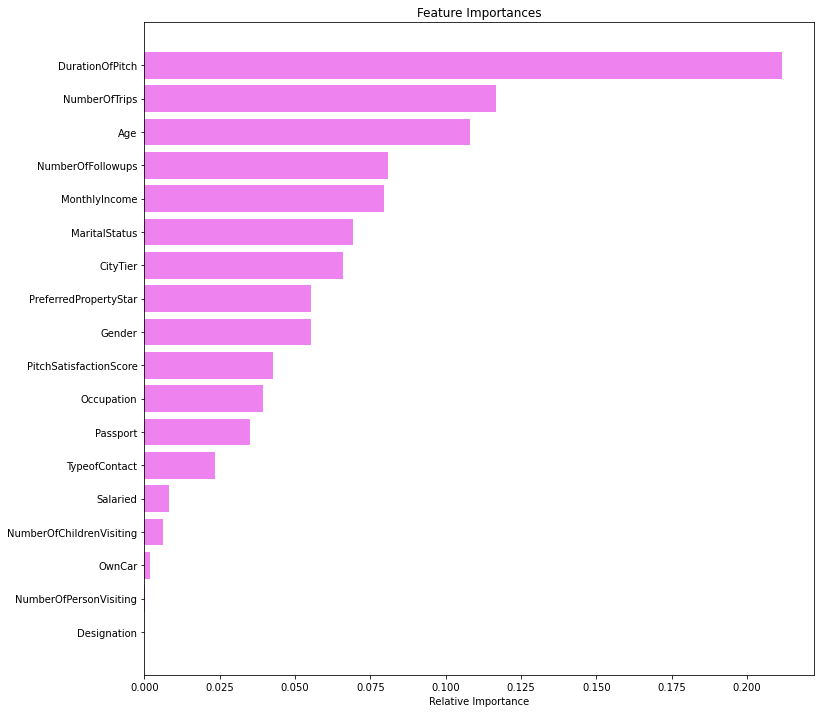

In [284]:
#SHAP is a better estimator of feature importance than regular sklearn.
# Even so, I want to double-check and see if it is more or less the same
# between models. Below is the gbc importance list.
feature_names = X_train.columns
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Although the importances differ somewhat, it is not a huge discrepency. I can get the directionality from the xcb model and that is very important.

For example, pitch duration is the most important factor in the gradient boost model according to sklearn, but what does that mean? Should the pitch be longer or shorter?

The XGBoost shap values show that a shorter pitch is better. This isn't the case for the overall model, deluxe, or basic package! For those, a longer pitch is better.

The same phenomenon occurs when I look at MonthlyIncome. For all of the other models so far, a lower income predicted a sale. However, for King a higher income predicted the sale. If I had just used the sklearn feature_importances_, I would have assumed the direction to be the same.

Age also seemed to flip for the King model, with higher ages meaning a higher probability of buying a package.

Gender also flipped, with females being more dominant, though the impact here is not great.

This is why I use the shap importances even though the XGBoost model is not the highest performing model.

Following this trend, the number of stars for a hotel become very important, with higher stars meaning higher probability of a package purchase.

For the King model, we see a distinct customer profile emerge, of an older, more wealthy customer:

* Prefers 5-star hotels
* High income
* Older
* Works at a large company
* Female
* Sales agent needed to get to the point in the pitch and not waste time (probably)

I wish pitch duration was a bit clearer. Again, I do not know if this factor is influenced by the sales agent being brief or the customer just being more decisive.

Lastly, I want to say I feel vindicated about removing salaried from occupation. Occupation was vastly more important here than salaried, meaning the salaried variable was just noise. Even though roughly half of occupation was imputed, the non-noise from the other half seemingly made a difference.

In [286]:
#Saving the model in case I want it later
King_model = gbc_tuned

In [287]:
#Saving feature rank list for later comparisons
King_Featurerank = list(reversed(X.columns[np.argsort(np.abs(shap_values).mean(0))]))

In [288]:
#Extracting best model performance for comparisons later
King_best = pd.DataFrame(gbc_tuned_model_test_perf)
King_best['Classifier'] = 'Gradient Boost Tuned'
King_best['Package'] = 'King'
King_best

,Accuracy,Recall,Precision,F1,Classifier,Package
0,1.0,1.0,1.0,1.0,Gradient Boost Tuned,King


## Model building for the Standard Package

We're going to do the same thing as above, but just analyzing the results for the Deluxe package.

### Splitting the data

In [289]:
# Separating features and the target column
X = dfStandard.drop(['ProdTaken','PitchLoveHate','Followups_Imputed','ProductPitched'], axis=1)
y = dfStandard['ProdTaken']

In [290]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(519, 18) (223, 18)


Now we need to double check that y is distributed equally among test and train.

In [291]:
y.value_counts(1)

0    0.832884
1    0.167116
Name: ProdTaken, dtype: float64

In [292]:
y_test.value_counts(1)

0    0.834081
1    0.165919
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

### Bagging Classifier for the Standard Package

   Accuracy    Recall  Precision        F1
0  0.996146  0.977011        1.0  0.988372
   Accuracy    Recall  Precision        F1
0  0.901345  0.540541        0.8  0.645161


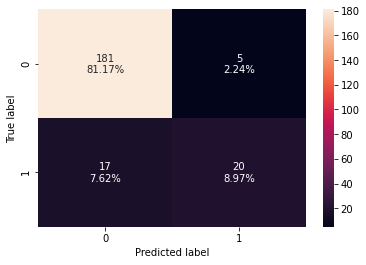

In [293]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* Bagging is overfitting, with large losses in performance because Recall is low.

#### Hypertuning the Bagging Classifier for the Standard Package

In [294]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.9, max_samples=0.8, n_estimators=40,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy    Recall  Precision        F1
0  0.996146  0.977011        1.0  0.988372
   Accuracy    Recall  Precision        F1
0   0.90583  0.513514   0.863636  0.644068


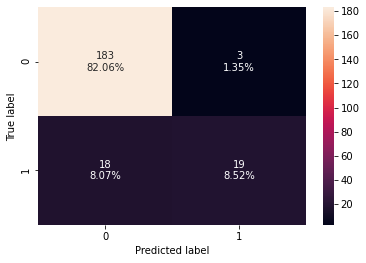

In [295]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Hypertuning didn't change much and we're still seeing a low Recall dragging down the f1 score.

## AdaBoost Classifier for the Standard Package

   Accuracy    Recall  Precision      F1
0    0.8921  0.413793   0.878049  0.5625
   Accuracy    Recall  Precision        F1
0  0.829596  0.243243   0.473684  0.321429


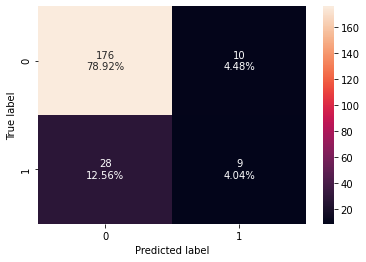

In [296]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* Overfit and abyssmal performance

#### Hypertuning the AdaBoost Classifier for the Standard Package

In [297]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision       F1
0  0.901345  0.567568   0.777778  0.65625


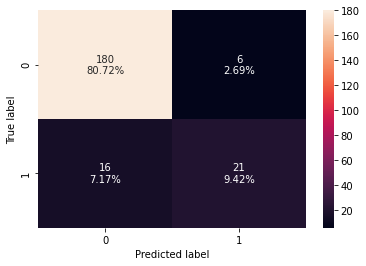

In [298]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

* Huge increase in performance, really made a massive difference
* f1 score increased, still not where we want it to be

## Gradient Boosting Classifier for the Standard Package

Training performance:
    Accuracy   Recall  Precision        F1
0  0.984586  0.91954   0.987654  0.952381
Testing performance:
    Accuracy    Recall  Precision       F1
0  0.883408  0.513514   0.703704  0.59375


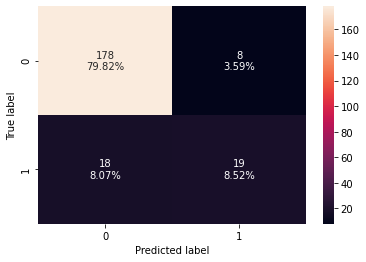

In [299]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* Gradient Boosting is overfitting and its performance is poor. Let's see how tuning helps.

#### Hypertuning the Gradient Boosting Classifier for the Standard Package

In [300]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.896861  0.540541   0.769231  0.634921


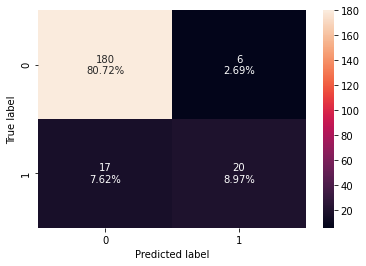

In [301]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* Some performance gain, but minimal
* Still overfitting about the same amount.

## XGBoost Classifier for the Standard Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.914798  0.648649        0.8  0.716418


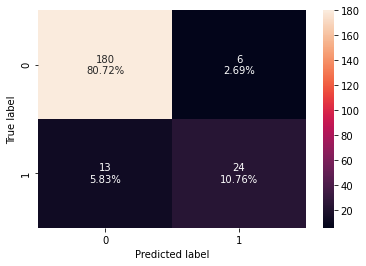

In [302]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Performance is pretty good but there is still some overfitting.
* Still struggling with Recall

#### Hypertuning the XGBoost Classifier for the Standard Package

In [303]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.932735  0.756757   0.823529  0.788732


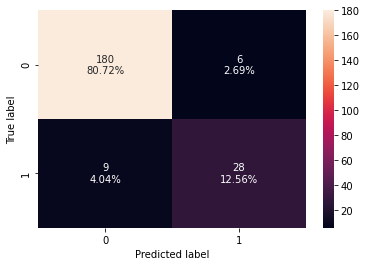

In [304]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* The hypertuned XGBClassifier has a slightly better performance, and is much more generalizable because of the cross-validation.

## Random Forest Classifier for the Standard Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.874439  0.324324        0.8  0.461538


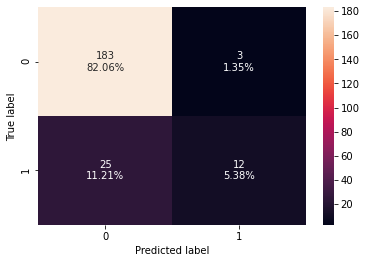

In [305]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* That is some extreme overfitting combined with trash f1 score.

#### Hypertuning the Random Forest Classifier for the Standard Package

In [306]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.18, 1: 0.82}, criterion='gini',
                       max_depth=10, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=7, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=None, oob_score=True,
                       random_state=1, verbose=0, warm_start=False)

Training performance:
    Accuracy    Recall  Precision       F1
0  0.998073  0.988506        1.0  0.99422
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.923767  0.540541        1.0  0.701754


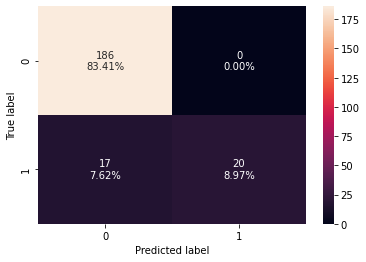

In [307]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

* Less overfitting but overall still relatively low F1 performance and a high degree of overfit
* f1 score is better after tuning, but it is still not where I want it.

## Decision Tree for the Standard Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.838565  0.540541   0.512821  0.526316


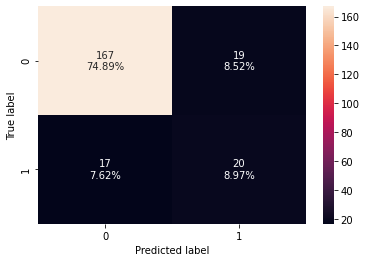

In [308]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

* Decision trees always overfit without hypertuning. So, we have to tune it.

#### Hypertuning the Decision Tree for the Standard Package

In [309]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.18, 1: 0.72},
                       criterion='gini', max_depth=8, max_features=None,
                       max_leaf_nodes=15, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=2,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')

Training performance:
    Accuracy    Recall  Precision        F1
0  0.807322  0.908046   0.461988  0.612403
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.748879  0.702703   0.366197  0.481481


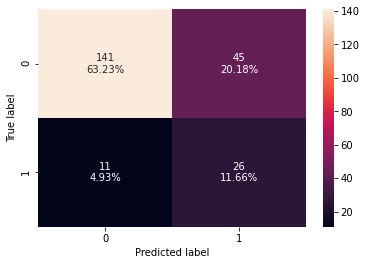

In [310]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

* It's not overfitting as much anymore, but that is a horrible performance.

## Stacking Classifier for the Standard Package

In [311]:
estimators = [('Bagging', bagging_estimator_tuned), ('Adaboost',abc_tuned),
              ('Gradient Boosting',gbc_tuned),('Decision Tree',dtree_estimator),
              ('Random Forest', rf_tuned)]

final_estimator = xgb_tuned 

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('Bagging',
                                BaggingClassifier(base_estimator=None,
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  max_features=0.9,
                                                  max_samples=0.8,
                                                  n_estimators=40, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=1, verbose=0,
                                                  warm_start=False)),
                               ('Adaboost',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0....
                                                 max_delta_step=0,

Training performance:
    Accuracy  Recall  Precision        F1
0   0.99422     1.0   0.966667  0.983051
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.90583  0.756757        0.7  0.727273


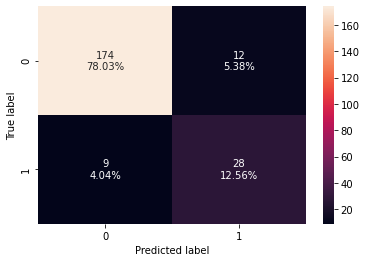

In [312]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

* Pretty good f1 score

## Comparing All Models for the Standard Package

In [313]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,0.807322,1.0,0.998073,0.996146,0.996146,0.892100,1.0,0.984586,1.0,1.0,1.0,0.994220
Recall,1.0,0.908046,1.0,0.988506,0.977011,0.977011,0.413793,1.0,0.919540,1.0,1.0,1.0,1.000000
Precision,1.0,0.461988,1.0,1.000000,1.000000,1.000000,0.878049,1.0,0.987654,1.0,1.0,1.0,0.966667
F1,1.0,0.612403,1.0,0.994220,0.988372,0.988372,0.562500,1.0,0.952381,1.0,1.0,1.0,0.983051


In [314]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.838565,0.748879,0.874439,0.923767,0.901345,0.905830,0.829596,0.901345,0.883408,0.896861,0.914798,0.932735,0.905830
Recall,0.540541,0.702703,0.324324,0.540541,0.540541,0.513514,0.243243,0.567568,0.513514,0.540541,0.648649,0.756757,0.756757
Precision,0.512821,0.366197,0.800000,1.000000,0.800000,0.863636,0.473684,0.777778,0.703704,0.769231,0.800000,0.823529,0.700000
F1,0.526316,0.481481,0.461538,0.701754,0.645161,0.644068,0.321429,0.656250,0.593750,0.634921,0.716418,0.788732,0.727273


The top three models, prioritizing tuned models because of cross-validation, are:
1. XGBoost Tuned
2. Stacking classifier
3. Random Forest Tuned 

Of these, the XGBoost classifier is the best, with the highest f1 score. It is the clear choice.

## Feature Importance and Analysis for Standard Package

Again, it is important to see directionality, and it is impossible to get feature importances for stacking classifiers. Because of that, I'll just look at the feature importances of the metaclassifier (the tuned XGB model).

I'll be using shap to get a good idea of the directionality of the features.

In [315]:
#Defining shap variables
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X)

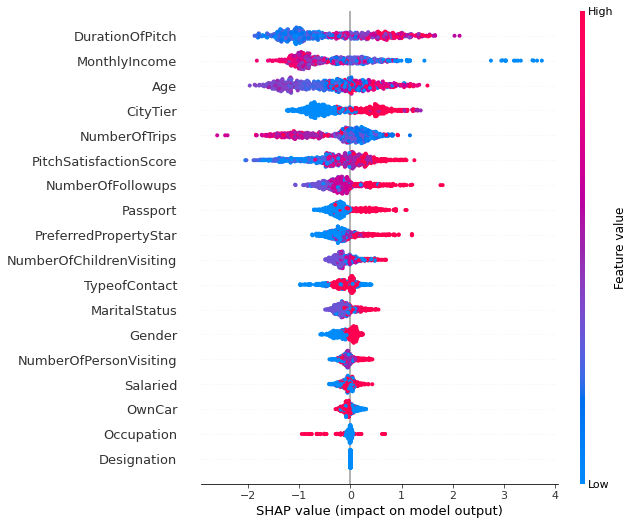

In [316]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

Duration of Pitch remains a strong predictor here, however its direction is opposite that of the King package: For Standard package buyers, a longer pitch is more important.

Monthly Income is also very important here, with much of the garbled going away and the trend towards lower income becoming quite clear.

Notably, not only is number of trips an important predictor here, it is also flipped from the overall model. Age is also flipped, with older customers buying the package

Importantly, Passport drops steeply in importance for the standard package purchaser.

These feature importances paint a distinct picture for this kind of customer:

* Older
* Doesn't travel much, if at all
* Lower income
* Received a lot of attention from the sales agent



In [318]:
# Saving the model for later if I want it
Standard_model = xgb_tuned

In [319]:
# Saving feature importance rankings
Standard_Featurerank = list(reversed(X.columns[np.argsort(np.abs(shap_values).mean(0))]))

In [320]:
# Extracting the best model performance for Standard
Standard_best = pd.DataFrame(xgb_tuned_model_test_perf)
Standard_best['Classifier'] = 'XGBoost Tuned'
Standard_best['Package'] = 'Standard'
Standard_best

,Accuracy,Recall,Precision,F1,Classifier,Package
0,0.932735,0.756757,0.823529,0.788732,XGBoost Tuned,Standard


## Model building for the Super Deluxe Package

We're going to do the same thing as above, but just analyzing the results for the Super Deluxe package.

### Splitting the data

In [321]:
"""I discovered that removing low-importance columns really helped performance. The removal of these
additional column is the result of that experimentation. If I included all of the columns, the highest
performing model had a test f1 of 0.857"""   

X = dfSuperD.drop(['ProdTaken','PitchLoveHate','Followups_Imputed','ProductPitched',
                  'Designation','Occupation','OwnCar','NumberOfPersonVisiting'], axis=1)

y = dfSuperD['ProdTaken']

In [322]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(239, 14) (103, 14)


Now we need to double check that y is distributed equally among test and train.

In [323]:
y.value_counts(1)

0    0.94152
1    0.05848
Name: ProdTaken, dtype: float64

In [324]:
y_test.value_counts(1)

0    0.941748
1    0.058252
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

### Bagging Classifier for the Super Deluxe Package

   Accuracy    Recall  Precision        F1
0  0.995816  0.928571        1.0  0.962963
   Accuracy  Recall  Precision        F1
0  0.951456     0.5        0.6  0.545455


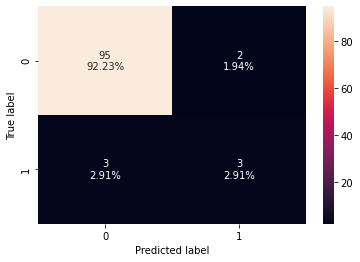

In [325]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* Bagging is overfitting, with low f1 performance, both from Recall and Precision.

#### Hypertuning the Bagging Classifier for the Super Deluxe Package

In [326]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.7, max_samples=0.8, n_estimators=30,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy  Recall  Precision   F1
0  0.961165     0.5       0.75  0.6


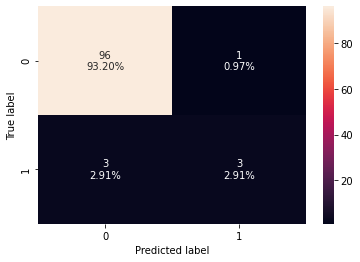

In [327]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Hypertuning helped some but we're still seeing the model struggle with Recall, keeping f1 low.

## AdaBoost Classifier for the Super Deluxe Package

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision   F1
0  0.980583  0.666667        1.0  0.8


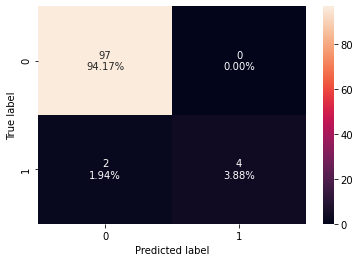

In [328]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* Not a bad model overall, let's see if tuning can help

#### Hypertuning the AdaBoost Classifier for the Super Deluxe Package

In [329]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision        F1
0  0.990291  0.833333        1.0  0.909091


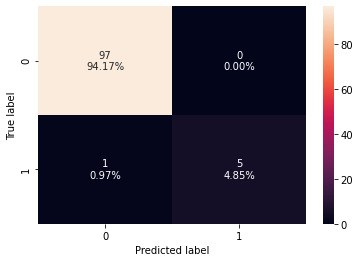

In [330]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

Hypertuning boosted the f1 score to perfection. Can't get much better than that.

## Gradient Boosting Classifier for the Super Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.951456     0.5        0.6  0.545455


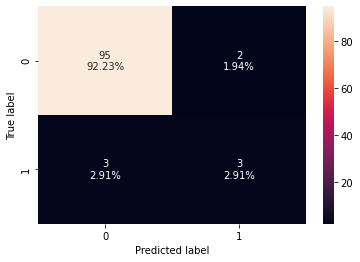

In [331]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* The overfit here is very extreme, and the performance is very low.

#### Hypertuning the Gradient Boosting Classifier for the Super Deluxe Package

In [332]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                                       random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=1, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
               

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision   F1
0  0.980583  0.666667        1.0  0.8


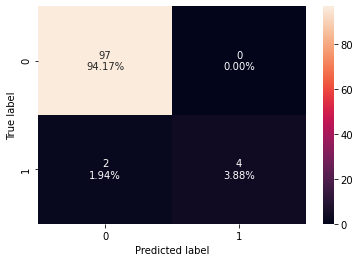

In [333]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* Hypertuning boosted precision immensely and recall some as well, making a decent model in terms of f1 score.

## XGBoost Classifier for the Super Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.951456     0.5        0.6  0.545455


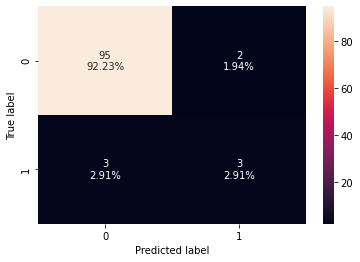

In [334]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Similar to gradient boost, this is highly overfit and its performance is low with both bad recall and precision.

#### Hypertuning the XGBoost Classifier for the Super Deluxe Package

In [335]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.980583     1.0       0.75  0.857143


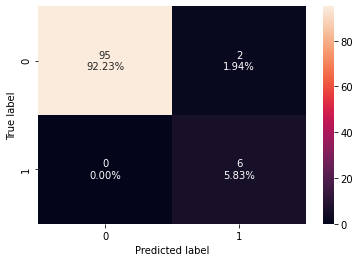

In [336]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* The hypertuned XGBClassifier has a perfect recall, which is an outlier among all of the models that typically struggle with recall. The huge improvement in recall and precision made the f1 score become quite good.

## Random Forest Classifier for the Super Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.970874     0.5        1.0  0.666667


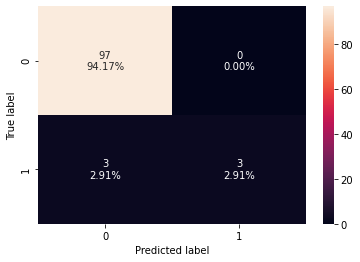

In [337]:
#Fitting the model
rf_estimator = RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

#Calculating different metrics
rf_estimator_model_train_perf=model_performance_classification_sklearn(rf_estimator,X_train,y_train)
print("Training performance:\n",rf_estimator_model_train_perf)
rf_estimator_model_test_perf=model_performance_classification_sklearn(rf_estimator,X_test,y_test)
print("Testing performance:\n",rf_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_estimator,X_test,y_test)

* Recall is low and is dragging down f1.

#### Hypertuning the Random Forest Classifier for the Super Deluxe Package

In [338]:
# Choose the type of classifier. 
rf_tuned = RandomForestClassifier(class_weight={0:0.18,1:0.82},random_state=1,oob_score=True,bootstrap=True)

parameters = {  
                'max_depth': list(np.arange(5,30,5)) + [None],
                'max_features': ['sqrt','log2',None],
                'min_samples_leaf': np.arange(1,15,5),
                'min_samples_split': np.arange(2, 20, 5),
                'n_estimators': np.arange(10,110,10)}


# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=5,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.18, 1: 0.82}, criterion='gini',
                       max_depth=5, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=70, n_jobs=None, oob_score=True,
                       random_state=1, verbose=0, warm_start=False)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.970874     0.5        1.0  0.666667


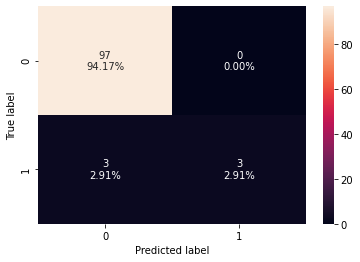

In [339]:
#Calculating different metrics
rf_tuned_model_train_perf=model_performance_classification_sklearn(rf_tuned,X_train,y_train)
print("Training performance:\n",rf_tuned_model_train_perf)
rf_tuned_model_test_perf=model_performance_classification_sklearn(rf_tuned,X_test,y_test)
print("Testing performance:\n",rf_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(rf_tuned,X_test,y_test)

* Hypertuning improved the mode some, yielding a higher f1 score.

## Decision Tree for the Super Deluxe Package

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision   F1
0  0.912621     0.5   0.333333  0.4


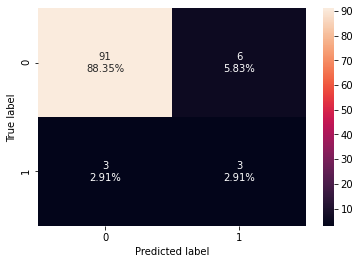

In [340]:
#Fitting the model
d_tree = DecisionTreeClassifier(random_state=1)
d_tree.fit(X_train,y_train)

#Calculating different metrics
d_tree_model_train_perf=model_performance_classification_sklearn(d_tree,X_train,y_train)
print("Training performance:\n",d_tree_model_train_perf)
d_tree_model_test_perf=model_performance_classification_sklearn(d_tree,X_test,y_test)
print("Testing performance:\n",d_tree_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(d_tree,X_test,y_test)

* Decision trees always overfit without hypertuning. So, we have to tune it.
* The performance is extremely low.

#### Hypertuning the Decision Tree for the Super Deluxe Package

In [341]:
#Choose the type of classifier. 
dtree_estimator = DecisionTreeClassifier(class_weight={0:0.18,1:0.72},random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(2,30), 
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_estimator, parameters, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_estimator.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.18, 1: 0.72},
                       criterion='gini', max_depth=6, max_features=None,
                       max_leaf_nodes=15, min_impurity_decrease=0.0001,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=1, splitter='best')

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.941748  0.666667        0.5  0.571429


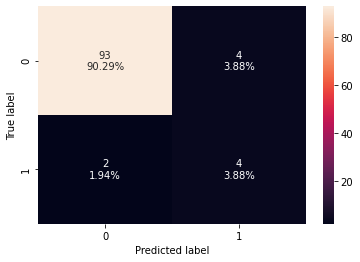

In [342]:
#Calculating different metrics
dtree_estimator_model_train_perf=model_performance_classification_sklearn(dtree_estimator,X_train,y_train)
print("Training performance:\n",dtree_estimator_model_train_perf)
dtree_estimator_model_test_perf=model_performance_classification_sklearn(dtree_estimator,X_test,y_test)
print("Testing performance:\n",dtree_estimator_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(dtree_estimator,X_test,y_test)

* Performance improved markedly but it is still overfitting a great deal.
* Even with improved performance, f1 score still low.

## Stacking Classifier for the Super Deluxe Package

In [343]:
estimators = [('Bagging', bagging_estimator_tuned), ('Adaboost',abc_tuned),
              ('Gradient Boosting',gbc_tuned),('Decision Tree',dtree_estimator),
              ('Random Forest', rf_tuned)]

final_estimator = xgb_tuned 

stacking_classifier= StackingClassifier(estimators=estimators,final_estimator=final_estimator)

stacking_classifier.fit(X_train,y_train)

StackingClassifier(cv=None,
                   estimators=[('Bagging',
                                BaggingClassifier(base_estimator=None,
                                                  bootstrap=True,
                                                  bootstrap_features=False,
                                                  max_features=0.7,
                                                  max_samples=0.8,
                                                  n_estimators=30, n_jobs=None,
                                                  oob_score=False,
                                                  random_state=1, verbose=0,
                                                  warm_start=False)),
                               ('Adaboost',
                                AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=DecisionTreeClassifier(ccp_alpha=0....
                                                 max_delta_step=0,

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision        F1
0  0.990291     1.0   0.857143  0.923077


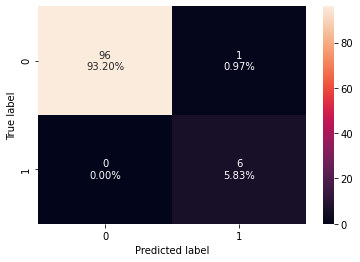

In [344]:
#Calculating different metrics
stacking_classifier_model_train_perf=model_performance_classification_sklearn(stacking_classifier,X_train,y_train)
print("Training performance:\n",stacking_classifier_model_train_perf)
stacking_classifier_model_test_perf=model_performance_classification_sklearn(stacking_classifier,X_test,y_test)
print("Testing performance:\n",stacking_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(stacking_classifier,X_test,y_test)

* f1 score is pretty good
* Overfit, but not too bad.

## Comparing All Models for the Super Deluxe Package

In [345]:
# training performance comparison

models_train_comp_df = pd.concat(
    [d_tree_model_train_perf.T,dtree_estimator_model_train_perf.T,rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
     bagging_classifier_model_train_perf.T,bagging_estimator_tuned_model_train_perf.T,ab_classifier_model_train_perf.T,
     abc_tuned_model_train_perf.T,gb_classifier_model_train_perf.T,gbc_tuned_model_train_perf.T,xgb_classifier_model_train_perf.T,
    xgb_tuned_model_train_perf.T,stacking_classifier_model_train_perf.T],
    axis=1,
)
models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,1.0,1.0,1.0,1.0,0.995816,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Recall,1.0,1.0,1.0,1.0,0.928571,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Precision,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
F1,1.0,1.0,1.0,1.0,0.962963,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [346]:
# testing performance comparison

models_test_comp_df = pd.concat(
    [d_tree_model_test_perf.T,dtree_estimator_model_test_perf.T,rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
     bagging_classifier_model_test_perf.T,bagging_estimator_tuned_model_test_perf.T,ab_classifier_model_test_perf.T,
     abc_tuned_model_test_perf.T,gb_classifier_model_test_perf.T,gbc_tuned_model_test_perf.T,xgb_classifier_model_test_perf.T,
    xgb_tuned_model_test_perf.T,stacking_classifier_model_test_perf.T],
    axis=1,
)
models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Estimator",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Bagging Classifier",
    "Bagging Estimator Tuned",
    "Adaboost Classifier",
    "Adaboost Classifier Tuned",
    "Gradient Boost Classifier",
    "Gradient Boost Classifier Tuned",
    "XGBoost Classifier",
    "XGBoost Classifier Tuned",
    "Stacking Classifier"]
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Estimator,Random Forest Estimator,Random Forest Tuned,Bagging Classifier,Bagging Estimator Tuned,Adaboost Classifier,Adaboost Classifier Tuned,Gradient Boost Classifier,Gradient Boost Classifier Tuned,XGBoost Classifier,XGBoost Classifier Tuned,Stacking Classifier
Accuracy,0.912621,0.941748,0.970874,0.970874,0.951456,0.961165,0.980583,0.990291,0.951456,0.980583,0.951456,0.980583,0.990291
Recall,0.500000,0.666667,0.500000,0.500000,0.500000,0.500000,0.666667,0.833333,0.500000,0.666667,0.500000,1.000000,1.000000
Precision,0.333333,0.500000,1.000000,1.000000,0.600000,0.750000,1.000000,1.000000,0.600000,1.000000,0.600000,0.750000,0.857143
F1,0.400000,0.571429,0.666667,0.666667,0.545455,0.600000,0.800000,0.909091,0.545455,0.800000,0.545455,0.857143,0.923077


The top three models are:
1. Adaboost tuned
2. Stacking Classifier
3. XGBoost Tuned

Adaboost performs the best. I can see no reason not to use it, since I cross-validated it too.

Otherwise, XGBoost Tuned and stacking did very well.

## Feature Importance and Analysis for the Super Deluxe Package

Again it is important to see the directionality of the features. So, even though the importances may be slightly different between XGBoost and the adaboost model, we'll look at the shap values for XGBoost.

In [347]:
#Defining shap variables
explainer = shap.TreeExplainer(xgb_tuned)
shap_values = explainer.shap_values(X)

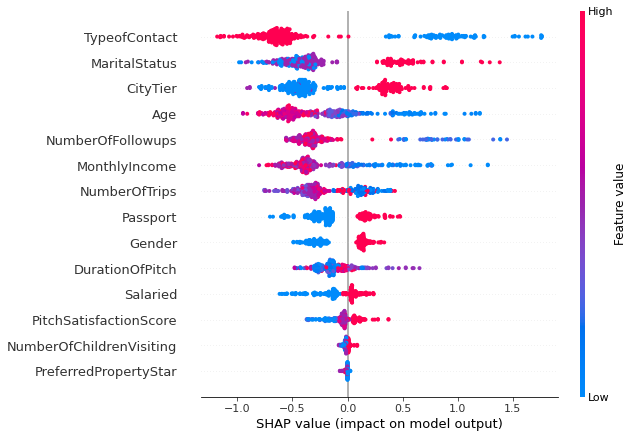

In [348]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

The strongest predictor for Super Deluxe was Type of Contact: If they were invited by a company, they were much more likely to purchase this package.

Secondly, unmarried and singles were much more likely to buy this package.

Notably, number of follow-ups was swapped in direction compared to overall. Unlike almost every other package, these customers did not appreciate being followed-up on.

Duration of pitch is unimportant here, but as far as it goes an average length, neither short nor long, seems to influence them to buy.

Again I feel justified in splitting salaried from occupation, as dropping occupation improved this model but salaried remained helpful.

Gender and passport are clearly distinct as well, with men being more likely to buy, and having a passport still important.

The customer profile for super deluxe looks like this:

* Referred to by a company
* Unmarried or single
* Younger
* Lives in a bad city
* Low income
* Doesn't travel much
* has a passport
* is male

In [350]:
# Saving the model for later if I want it
SuperD_model = abc_tuned

In [351]:
#Extracting the best model's performance for later comparison
SuperD_best = pd.DataFrame(abc_tuned_model_test_perf)
SuperD_best['Classifier'] = 'Adaboost Tuned'
SuperD_best['Package'] = 'SuperD'
SuperD_best

,Accuracy,Recall,Precision,F1,Classifier,Package
0,0.990291,0.833333,1.0,0.909091,Adaboost Tuned,SuperD


In [352]:
# Saving the rank list for later comparison
SuperD_Featurerank = list(reversed(X.columns[np.argsort(np.abs(shap_values).mean(0))]))

# Results Analysis and Conclusions

For easy analysis, I'm going to bring all of the results together into tables. First, I'm going to rank feature importance for each package, and then I'm going to compare predictive ability across package-specific models.

In [353]:
#Creating rank_list df
rank_list = pd.DataFrame()

In [354]:
#Making the columns the same as df_imputed
rank_list = rank_list.reindex(columns=df_imputed.columns)

In [355]:
#Making the rankings for each package by making dictionaries. The columns will match rank_list's
enum_superDrank = enumerate(SuperD_Featurerank)
superDrank = dict((j,i) for i,j in enum_superDrank) #Super Deluxe
enum_standard = enumerate(Standard_Featurerank)
standardrank = dict((j,i) for i,j in enum_standard) #Standard
enum_king = enumerate(King_Featurerank)
kingrank = dict((j,i) for i,j in enum_king) #King
enum_deluxe = enumerate(Deluxe_Featurerank)
deluxerank = dict((j,i) for i,j in enum_deluxe)
enum_basic = enumerate(Basic_Featurerank) #Basic
basicrank = dict((j,i) for i,j in enum_basic)
enum_overall = enumerate(Overall_Featurerank) #Overall
overallrank = dict((j,i) for i,j in enum_overall)

In [356]:
#Now I populate rank_list with the dictionaries I just made
rank_list.loc['SuperDeluxe'] = superDrank
rank_list.loc['Standard'] = standardrank
rank_list.loc['King'] = kingrank
rank_list.loc['Deluxe'] = deluxerank
rank_list.loc['Basic'] = basicrank
rank_list.loc['Overall'] = overallrank

In [357]:
#I add 1 to help with interpretation. Python likes 0s but rank 0 sounds weird.
rank_list = rank_list + 1
#I drop columns which are NaN for all packages
rank_list = rank_list.drop(['Followups_Imputed','ProdTaken','PitchLoveHate'],axis=1)
#Display transposed for easier reading

In [358]:
#Now making the performance table by concating all the model performances I saved above
Performance_table = pd.concat([SuperD_best, Standard_best, King_best, Deluxe_best,
                                              Basic_best,Overall_best],axis=0)
Performance_table = Performance_table.set_index('Package')
Performance_table

,Accuracy,Recall,Precision,F1,Classifier
Package,,,,,
SuperD,0.990291,0.833333,1.000000,0.909091,Adaboost Tuned
Standard,0.932735,0.756757,0.823529,0.788732,XGBoost Tuned
King,1.000000,1.000000,1.000000,1.000000,Gradient Boost Tuned
Deluxe,0.955426,0.868852,0.779412,0.821705,XGBoost Tuned
Basic,0.897996,0.769697,0.875862,0.819355,Bagging Tuned
All,0.930775,0.927273,0.758929,0.834697,Stacking


In [359]:
rank_list.T

,SuperDeluxe,Standard,King,Deluxe,Basic,Overall
Age,4.0,3.0,2.0,4.0,5.0,4.0
TypeofContact,1.0,11.0,16.0,13.0,10.0,14.0
CityTier,3.0,4.0,12.0,1.0,9.0,3.0
DurationOfPitch,10.0,1.0,1.0,3.0,6.0,6.0
Occupation,NaN,17.0,3.0,17.0,12.0,16.0
Gender,9.0,13.0,6.0,10.0,16.0,13.0
NumberOfPersonVisiting,NaN,14.0,17.0,15.0,14.0,17.0
NumberOfFollowups,5.0,7.0,13.0,11.0,7.0,9.0
ProductPitched,NaN,NaN,NaN,NaN,NaN,5.0
PreferredPropertyStar,14.0,9.0,4.0,7.0,4.0,8.0


We chose f1 as our performance score because the target variable is very imbalanced, so we could get a high degree of accuracy just by predicting "no" 100% of the time. As we don't know the cost of time vs. profit, a balance of recall and precision is better, and thus f1 is a great measurement in place of accuracy.

As we can see, all of the predictive models have fairly good f1, with one of the models achieving perfect predictions.

As a reminder, the model with perfect predictions was built using a very small number of observations. This means that the model may have higher variance than it appears, and may drop in performance as more observations are gathered.

Regardless, I think in general we can say that we can predict not only who will buy a package, but also which package they will buy using the above models, and which pitch strategy works best for each.

As we can see from the rank_list table, the feature importance ranks differ wildly from package to package. This allows us to differentiate between the packages and advise the sales team on which package they should pitch.

The only "general" feature of great importance is Passports. Passports are consistently important, and its directionality is always the same: the customer should have a passport. No matter the package, having a passport predicts purchasing a package. If we have limited time, we should be pitching to customers who have passports first, and only moving to those without passports once that customer base is exhausted.

These models do tell us how important customer interactions are. In general, the answer is even if they are not the most important factor, they do make an impact, with different strategies working differently depending on the customer type.

For example, pitch duration should be short when pitching the king package, but long for the basic package. Similarly, all but one of the packages sell more often with more follow-ups, but with Super Deluxe the opposite strategy is superior. Don't pester these customers.

From here, the next step is to make models for the sales team to actually use. Then we can start making a script to be used on the fly.

# Package Targeting Model

All of the customer interaction variables are retrospective. They are of no use unless the sales team member can identify which product they should pitch. So, let's make models designed to do that.

Each model has to take an equal number of features for this to work.
None of the models can take customer interactions into account.
Again, the most important performance will be f1: accuracy is inappropriate for an imbalanced target variable, and we don't know which type of error is worse.

In [360]:
dfTarget = df_imputed.drop(['PitchLoveHate','Followups_Imputed',
                  'Designation','OwnCar','NumberOfPersonVisiting', 'DurationOfPitch',
                     'PitchSatisfactionScore','NumberOfFollowups',], axis=1)

In [361]:
#Separating the data by product pitched/sold.
dfTbasic = dfTarget[dfTarget["ProductPitched"]==0]
dfTdeluxe = dfTarget[dfTarget["ProductPitched"]==1]
dfTking = dfTarget[dfTarget["ProductPitched"]==2]
dfTStandard = dfTarget[dfTarget["ProductPitched"]==3]
dfTSuperD = dfTarget[dfTarget["ProductPitched"]==4]

In [362]:
#Now I have to drop ProductPitched since it is a useless category anyway
dfTbasic = dfTbasic.drop(['ProductPitched'],axis=1)
dfTdeluxe = dfTdeluxe.drop(['ProductPitched'],axis=1)
dfTking = dfTking.drop(['ProductPitched'],axis=1)
dfTStandard = dfTStandard.drop(['ProductPitched'],axis=1)
dfTSuperD = dfTSuperD.drop(['ProductPitched'],axis=1)

Now I have to make predictive models for all of these. We're not looking to make profiles so I'll just use the singular best performing tuned model besides stacking. (Stacking works well but will take too much computing power.)

## Targeted Basic

In [363]:
# Separating features and the target column
X = dfTbasic.drop(['ProdTaken'], axis=1)
y = dfTbasic['ProdTaken']

In [364]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(1281, 12) (549, 12)


Now we need to double check that y is distributed equally among test and train.

In [365]:
y.value_counts(1)

0    0.7
1    0.3
Name: ProdTaken, dtype: float64

In [366]:
y_test.value_counts(1)

0    0.699454
1    0.300546
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

In our previous model comparisons, tuned bagging did best for Basic. So I'll do that here.

### Bagging Classifier for Targeted Basic

   Accuracy   Recall  Precision       F1
0  0.989071  0.96875   0.994652  0.98153
   Accuracy    Recall  Precision        F1
0   0.87796  0.739394   0.835616  0.784566


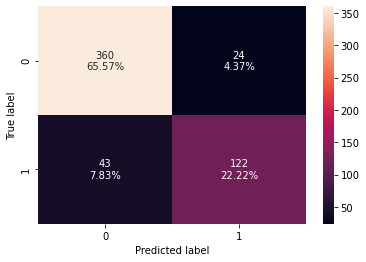

In [367]:
#Fitting the model
bagging_classifier = BaggingClassifier(random_state=1)
bagging_classifier.fit(X_train,y_train)

#Calculating different metrics
bagging_classifier_model_train_perf=model_performance_classification_sklearn(bagging_classifier,X_train,y_train)
print(bagging_classifier_model_train_perf)
bagging_classifier_model_test_perf=model_performance_classification_sklearn(bagging_classifier,X_test,y_test)
print(bagging_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_classifier,X_test,y_test)

* Not a bad performance, but it is overfitting a bit.

#### Hypertuning

In [368]:
# Choose the type of classifier. 
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_samples': [0.7,0.8,0.9,1], 
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=0.9, max_samples=0.9, n_estimators=40,
                  n_jobs=None, oob_score=False, random_state=1, verbose=0,
                  warm_start=False)

   Accuracy    Recall  Precision        F1
0  0.998439  0.994792        1.0  0.997389
   Accuracy   Recall  Precision        F1
0  0.861566  0.70303   0.811189  0.753247


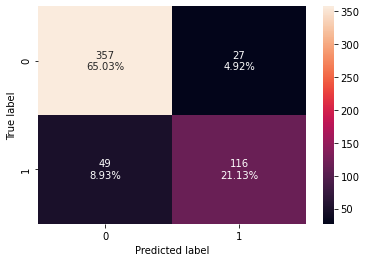

In [369]:
#Calculating different metrics
bagging_estimator_tuned_model_train_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_train,y_train)
print(bagging_estimator_tuned_model_train_perf)
bagging_estimator_tuned_model_test_perf=model_performance_classification_sklearn(bagging_estimator_tuned,X_test,y_test)
print(bagging_estimator_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(bagging_estimator_tuned,X_test,y_test)

* Hypertuning reduced performance slightly, but validated it. We'll use this model.

In [370]:
#Saving this model for predictions
BasicT_model = bagging_estimator_tuned
BasicT_modelfit = bagging_estimator_tuned.fit(X_train, y_train)

## Targeted Deluxe

In [371]:
# Separating features and the target column
X = dfTdeluxe.drop(['ProdTaken'], axis=1)
y = dfTdeluxe['ProdTaken']

In [372]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(1201, 12) (516, 12)


Now we need to double check that y is distributed equally among test and train.

In [373]:
y.value_counts(1)

0    0.881188
1    0.118812
Name: ProdTaken, dtype: float64

In [374]:
y_test.value_counts(1)

0    0.881783
1    0.118217
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

In our previous model comparisons, XGBoost Classifier Tuned did best for Deluxe. So I'll do that here.

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.926357  0.622951   0.716981  0.666667


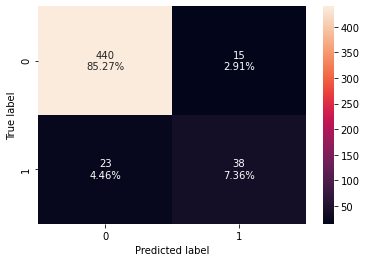

In [375]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Not a stellar performance
* Overfitting the data

#### Hypertuning

In [376]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision        F1
0  0.994172     1.0   0.953333  0.976109
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.918605  0.704918   0.641791  0.671875


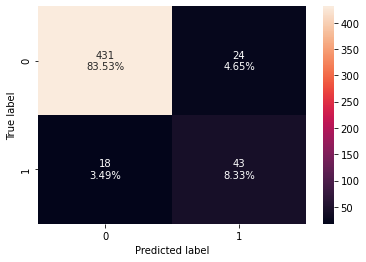

In [377]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

That's not great, but I expected the performance to drop compared to the previous set of models because we're removing some of the better predictors. Customer interaction mattered a decent amount to Deluxe purchasers.

Tuning didn't change the score much at all. We still prefer this model, as it is cross-validated.

In [378]:
#Saving the model for predictions later
DeluxeT_model = xgb_tuned
DeluxeT_modelfit = xgb_tuned.fit(X_train, y_train)

## Targeted King

In [379]:
# Separating features and the target column
X = dfTking.drop(['ProdTaken'], axis=1)
y = dfTking['ProdTaken']

In [380]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(161, 12) (69, 12)


Now we need to double check that y is distributed equally among test and train.

In [381]:
y.value_counts(1)

0    0.913043
1    0.086957
Name: ProdTaken, dtype: float64

In [382]:
y_test.value_counts(1)

0    0.913043
1    0.086957
Name: ProdTaken, dtype: float64

In our previous model comparisons, Gradient Boost Classifier Tuned did best for Deluxe. So I'll do that here.

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.956522  0.833333   0.714286  0.769231


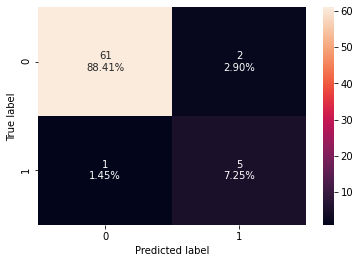

In [383]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
gb_classifier_model_train_perf=model_performance_classification_sklearn(gb_classifier,X_train,y_train)
print("Training performance:\n",gb_classifier_model_train_perf)
gb_classifier_model_test_perf=model_performance_classification_sklearn(gb_classifier,X_test,y_test)
print("Testing performance:\n",gb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gb_classifier,X_test,y_test)

* Gradient Boosting is overfitting a little
* Performance is pretty solid.

#### Hypertuning

In [384]:
# Choose the type of classifier. 
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse',
                           init=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=50,
                                                   random_state=1),
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=0.7, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
             

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision   F1
0  0.942029     0.5       0.75  0.6


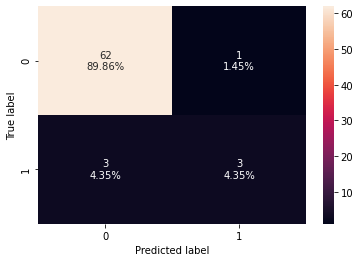

In [385]:
#Calculating different metrics
gbc_tuned_model_train_perf=model_performance_classification_sklearn(gbc_tuned,X_train,y_train)
print("Training performance:\n",gbc_tuned_model_train_perf)
gbc_tuned_model_test_perf=model_performance_classification_sklearn(gbc_tuned,X_test,y_test)
print("Testing performance:\n",gbc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(gbc_tuned,X_test,y_test)

* Precision score increased, boosting f1 score.
* Recall decreased, reducing the score
* Overall not as good, but validation is important. Still acceptable.

In [386]:
# Saving the model for later predictions
KingT_model = gbc_tuned
KingT_modelfit = gbc_tuned.fit(X_train, y_train)

## Targeted Standard

In [387]:
# Separating features and the target column
X = dfTStandard.drop(['ProdTaken'], axis=1)
y = dfTStandard['ProdTaken']

In [388]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(519, 12) (223, 12)


Now we need to double check that y is distributed equally among test and train.

In [389]:
y.value_counts(1)

0    0.832884
1    0.167116
Name: ProdTaken, dtype: float64

In [390]:
y_test.value_counts(1)

0    0.834081
1    0.165919
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

In our previous model comparisons, outside of our stacking classifier (which we won't use here) Adaboost Classifier Tuned did best for Standard. So I'll do that here.

   Accuracy    Recall  Precision        F1
0  0.867052  0.310345       0.75  0.439024
   Accuracy   Recall  Precision        F1
0  0.852018  0.27027      0.625  0.377358


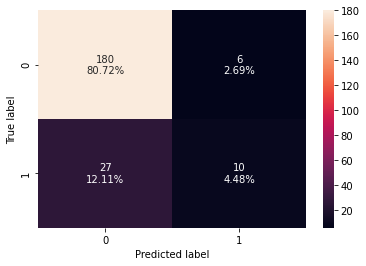

In [391]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* No overfit but poor performance

#### Hypertuning

In [392]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision       F1
0  0.869955  0.432432   0.666667  0.52459


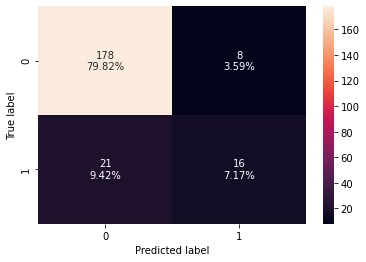

In [393]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

That's really bad. Tuning increased performance a great deal but the overfitting and f1 score are both so bad I wouldn't want to use the model unless we have to.

XGBoost also did well before, I'll try that one too.

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.887892  0.513514   0.730769  0.603175


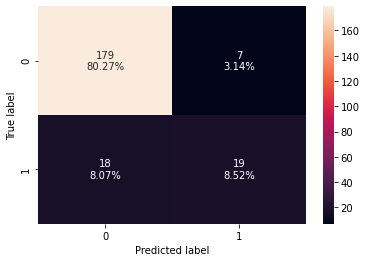

In [394]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Very overfit
* f1 score is bad

#### Hypertuning

In [395]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.7, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision        F1
0  0.998073     1.0   0.988636  0.994286
Testing performance:
    Accuracy    Recall  Precision        F1
0   0.90583  0.648649       0.75  0.695652


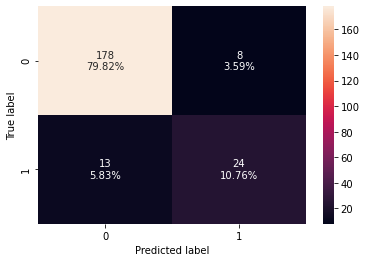

In [396]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

* Still overfit
* Tuning increased the f1 score. It's better than adaboost. We'll have to use this one.

In [397]:
# Saving the model for later predictions
StandardT_model = xgb_tuned
StandardT_modelfit = xgb_tuned.fit(X_train, y_train)

## Targeted Super Deluxe

In [398]:
# Separating features and the target column
X = dfTSuperD.drop(['ProdTaken'], axis=1)
y = dfTSuperD['ProdTaken']

In [399]:
# Splitting data into training and test set, stratifying to ensure proper y count
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=1,stratify=y)
print(X_train.shape, X_test.shape)

(239, 12) (103, 12)


Now we need to double check that y is distributed equally among test and train.

In [400]:
y.value_counts(1)

0    0.94152
1    0.05848
Name: ProdTaken, dtype: float64

In [401]:
y_test.value_counts(1)

0    0.941748
1    0.058252
Name: ProdTaken, dtype: float64

Split complete. Looking good so far.

In our previous model comparisons Adaboost Classifier Tuned did best for Super Deluxe. So I'll do that here.

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision   F1
0  0.980583  0.666667        1.0  0.8


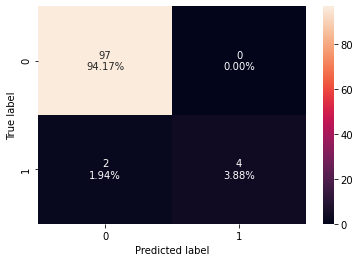

In [402]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
ab_classifier_model_train_perf=model_performance_classification_sklearn(ab_classifier,X_train,y_train)
print(ab_classifier_model_train_perf)
ab_classifier_model_test_perf=model_performance_classification_sklearn(ab_classifier,X_test,y_test)
print(ab_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(ab_classifier,X_test,y_test)

* Overfit
* Performance is pretty good

#### Hypertuning

In [403]:
# Choose the type of classifier. 
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1,random_state=1),
                      DecisionTreeClassifier(max_depth=2,random_state=1),
                      DecisionTreeClassifier(max_depth=3,random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter  combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

   Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
   Accuracy    Recall  Precision        F1
0  0.961165  0.666667   0.666667  0.666667


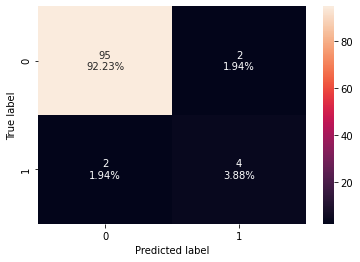

In [404]:
#Calculating different metrics
abc_tuned_model_train_perf=model_performance_classification_sklearn(abc_tuned,X_train,y_train)
print(abc_tuned_model_train_perf)
abc_tuned_model_test_perf=model_performance_classification_sklearn(abc_tuned,X_test,y_test)
print(abc_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(abc_tuned,X_test,y_test)

Tuning adaboost lowered performance, but not by a lot.

XGBoost also did well, I'll try that one too.

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy    Recall  Precision        F1
0  0.970874  0.833333   0.714286  0.769231


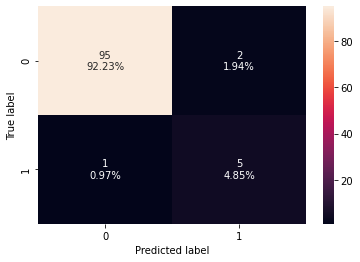

In [405]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1, eval_metric='logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
xgb_classifier_model_train_perf=model_performance_classification_sklearn(xgb_classifier,X_train,y_train)
print("Training performance:\n",xgb_classifier_model_train_perf)
xgb_classifier_model_test_perf=model_performance_classification_sklearn(xgb_classifier,X_test,y_test)
print("Testing performance:\n",xgb_classifier_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_classifier,X_test,y_test)

* Performance is not great but there is still some overfitting.

#### Hypertuning

In [406]:
# Choose the type of classifier. 
xgb_tuned = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": [10,30,50],
    "scale_pos_weight":[1,2,5],
    "subsample":[0.7,0.9,1],
    "learning_rate":[0.05, 0.1,0.2],
    "colsample_bytree":[0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,1]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=16,
              num_parallel_tree=1, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0
Testing performance:
    Accuracy  Recall  Precision    F1
0  0.961165     1.0        0.6  0.75


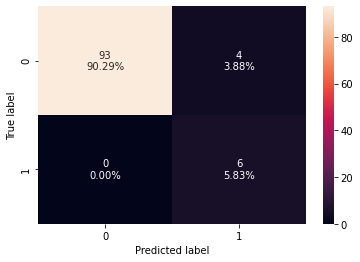

In [407]:
#Calculating different metrics
xgb_tuned_model_train_perf=model_performance_classification_sklearn(xgb_tuned,X_train,y_train)
print("Training performance:\n",xgb_tuned_model_train_perf)
xgb_tuned_model_test_perf=model_performance_classification_sklearn(xgb_tuned,X_test,y_test)
print("Testing performance:\n",xgb_tuned_model_test_perf)

#Creating confusion matrix
confusion_matrix_sklearn(xgb_tuned,X_test,y_test)

Of the two models, XGBoost tuned is best. I'll use that.

In [408]:
SuperDT_model = xgb_tuned
SuperDT_modelfit = xgb_tuned.fit(X_train, y_train)

## Pitch Predictor

I want to give as concrete advice as possible to the sales team. To do that, I have to predict what a new customer will do.

I want to make a function that allows a sales agent to input a new customer's data and then immediately receive advice on which package they should sell that customer, and what strategy is best to maximize the probability they make a sale.

In [409]:
# dfTest will be only the data a sales agent can get over the phone or elsewhere
dfTest = dfTarget.drop(['ProdTaken','ProductPitched'],axis=1)
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4861 entries, 0 to 4860
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       4861 non-null   float64
 1   TypeofContact             4861 non-null   float64
 2   CityTier                  4861 non-null   float64
 3   Occupation                4861 non-null   float64
 4   Gender                    4861 non-null   float64
 5   PreferredPropertyStar     4861 non-null   float64
 6   MaritalStatus             4861 non-null   float64
 7   NumberOfTrips             4861 non-null   float64
 8   Passport                  4861 non-null   float64
 9   NumberOfChildrenVisiting  4861 non-null   float64
 10  MonthlyIncome             4861 non-null   float64
 11  Salaried                  4861 non-null   float64
dtypes: float64(12)
memory usage: 455.8 KB


In [410]:
#I will need to test the function on an example.
test = dfTest.iloc[0].values.reshape(1, -1)

In [411]:
# Making an inside-function to run the customer's values through all the saved models

def Pitch_Predict(customer):
    # Getting probabilities via our saved models
    Basic_pred = BasicT_model.predict_proba(customer).tolist()
    Deluxe_pred = DeluxeT_model.predict_proba(customer).tolist()
    King_pred = KingT_model.predict_proba(customer).tolist()
    Standard_pred = StandardT_model.predict_proba(customer).tolist()
    SuperDT_pred = SuperDT_model.predict_proba(customer).tolist()
    #Putting those probabilities into a dataframe
    pitch_pred = pd.DataFrame()
    pitch_pred['Basic'] = [Basic_pred[0][1]]
    pitch_pred['Deluxe'] = [Deluxe_pred[0][1]]
    pitch_pred['King'] = [King_pred[0][1]]
    pitch_pred['Standard'] = [Standard_pred[0][1]]
    pitch_pred['Super Deluxe'] = [SuperDT_pred[0][1]]
     #Another function to bold the highest probability model
    def negative_bold(val):
        bold = 'bold' if val == pitch_pred.max(axis=1).values.tolist()[0] else ''
        return 'font-weight: %s' % bold
    pitch_pred.style.applymap(negative_bold)
    display(pitch_pred.style.applymap(negative_bold))

In [412]:
Pitch_Predict(test)

,Basic,Deluxe,King,Standard,Super Deluxe
0,0.300000,0.934760,0.207035,0.829594,0.558946


Now we can input a new row and it will output and bold the package that particular customer is most likely to buy. If we have all of the customer's data before we contact them, we can use this to advise the sales team.

But, what if they need to gather data on the phone or via a website?

In [413]:
def sale_pitch():
    #Inputs from the user will populate a row that can be entered into the models
    age = int(input('Age of customer '))
    TypeofContact = input('Were they referred to us by a company? y/n ')
    if TypeofContact == 'y':
        TypeofContact = 0
    else:
        TypeofContact = 1
    CityTier = int(input('City Tier of customer\'s residence: 1,2, or 3? '))
    Occupation = int(input('Are they a free lancer, work at a small business, or a large business? Input 1, 2, or 3, respectively '))
    Gender = int(input('0 for female, 1 for male '))
    PreferredPropertyStar = int(input('They prefer a hotel with how many stars? Whole numbers only '))
    MaritalStatus = int(input('0 for divorced, 1 for married, 2 for single, 3 for unmarried '))
    NumberOfTrips = float(input('Average number of trips in a year '))
    Passport =int(input('0 for has no passport, 1 for has a passport '))
    NumberOfChildrenVisiting = int(input('Expected number of children 5 and younger that would go with the client '))
    MonthlyIncome = float(input('Expected monthly income '))
    Salaried = int(input('0 for hourly-wage-earner, 1 for salaried '))
    #Inputing the user input into a dict for the model
    Dict = {'Age':[age],
            'TypeofContact':[TypeofContact],
            'CityTier':[CityTier],
            'Occupation':[Occupation],
            'Gender':[Gender],
            'PreferredPropertyStar':[PreferredPropertyStar],
            'MaritalStatus':[MaritalStatus],
            'NumberOfTrips':[NumberOfTrips],
            'Passport':[Passport],
            'NumberOfChildrenVisiting':[NumberOfChildrenVisiting],
            'MonthlyIncome':[MonthlyIncome],
            'Salaried':[Salaried]}
    #Putting that dict into a dataframe
    customer = pd.DataFrame(Dict)
    cust_test = customer.iloc[0].values.reshape(1, -1)
    # Making an inside-function to run the customer's values through all the saved models
    def Pitch_Predict(customer):
        # Getting probabilities via our saved models
        Basic_pred = BasicT_model.predict_proba(customer).tolist()
        Deluxe_pred = DeluxeT_model.predict_proba(customer).tolist()
        King_pred = KingT_model.predict_proba(customer).tolist()
        Standard_pred = StandardT_model.predict_proba(customer).tolist()
        SuperDT_pred = SuperDT_model.predict_proba(customer).tolist()
        #Putting those probabilities into a dataframe
        pitch_pred = pd.DataFrame()
        pitch_pred['Basic'] = [Basic_pred[0][1]]
        pitch_pred['Deluxe'] = [Deluxe_pred[0][1]]
        pitch_pred['King'] = [King_pred[0][1]]
        pitch_pred['Standard'] = [Standard_pred[0][1]]
        pitch_pred['Super Deluxe'] = [SuperDT_pred[0][1]]
        #Another function to bold the highest probability model
        def negative_bold(val):
            bold = 'bold' if val == pitch_pred.max(axis=1).values.tolist()[0] else ''
            return 'font-weight: %s' % bold
        pitch_pred.style.applymap(negative_bold)
        display(pitch_pred.style.applymap(negative_bold))
    Pitch_Predict(cust_test)

In [414]:
sale_pitch()

Age of customer 26
Were they referred to us by a company? y/n n
City Tier of customer's residence: 1,2, or 3? 2
Are they a free lancer, work at a small business, or a large business? Input 1, 2, or 3, respectively 3
0 for female, 1 for male 1
They prefer a hotel with how many stars? Whole numbers only 4
0 for divorced, 1 for married, 2 for single, 3 for unmarried 3
Average number of trips in a year 6
0 for has no passport, 1 for has a passport 1
Expected number of children 5 and younger that would go with the client 1
Expected monthly income 6000
0 for hourly-wage-earner, 1 for salaried 1


,Basic,Deluxe,King,Standard,Super Deluxe
0,0.950000,0.007930,0.328781,0.954804,0.410515


The above is a demo app that allows the user (a sales agent?) to input data about the customer. Then it tells the agent which package that customer is most likely to buy.

Then, all the sales agent needs to do is pair the prediction with the matching pitch advice below:

Basic Package
* Talk to the customer for 20 minutes or more
* Follow-up repeatedly, the more they allow the better
* Be nice and give them a good experience

Deluxe Package
* Talk to the customer for 20 minutes or more
* Follow-up repeatedly, the more they allow the better
* Just don't make them angry at you

King Package
* Keep the pitch short and sweet: 9 or 10 minutes max.
* Follow-up a few times, but don't waste your time
* Be concise but not rude

Standard Package
* Longer pitches very important: talk for 20+ minutes
* Follow-up repeatedly, the more they allow the better
* Their satisfaction is important, engage with them and listen

Super Deluxe
* Average length pitches better: 10-15 minutes
* Don't follow up much - don't pester these customers
* Don't be pushy

# The Wellness Tourism Package

The original task posed to me was helping marketing target customers more likely to buy the Wellness Tourism Package. However, no information was given to me about this package or even the other packages.

Therefore, my recommendation is for the marketing team to analyze who their target audience is for this new wellness package, and then identify which existing package has the most similar customer profile.

Once that is complete, it should be easy to make an educated guess as to which type of customer is most likely to buy the Wellness Tourism Package, and which marketing strategies should be used.

Regardless of similarities, however, the following traits should be true for all targetted customers:

* Has a passport
* Lives in a tier 3 city
* Prefers higher star hotels

Those are the only three factors that never flip in direction for any package (though high star hotels is unimportant to Super Deluxe). Every other feature flips in direction at least once. The first two are more important in general, and easily discoverable to create a bank of customers to cold-call or otherwise contact.

## Missing customers

I always find it useful to point out who we are *not* seeing. This allows marketing to design products that may appeal to a part of the population who current packages do not appeal to.

Given the above trends, I'd say the following kinds of people tend to not buy packages:

* No passport
* Lives in a very nice city
* Prefers simple living (low star hotels)
* Women (being female only appealed to a single package that didn't sell well)

There could be travel packages that can appeal to this demographic. For example, domestic travel to local national parks where the customer stays in a tent could appeal to those with no passport and don't like spending on luxury hotels.

In [ ]:
StandardT_model

In [415]:
#Defining shap variables
explainer = shap.TreeExplainer(SuperDT_model)
shap_values = explainer.shap_values(X)

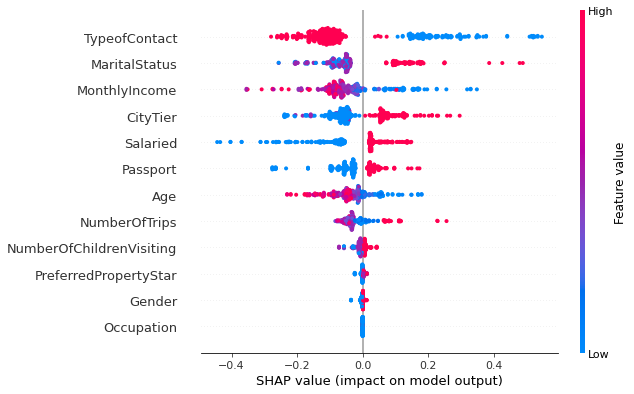

In [416]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [417]:
#Defining shap variables
explainer = shap.TreeExplainer(StandardT_model)
shap_values = explainer.shap_values(X)

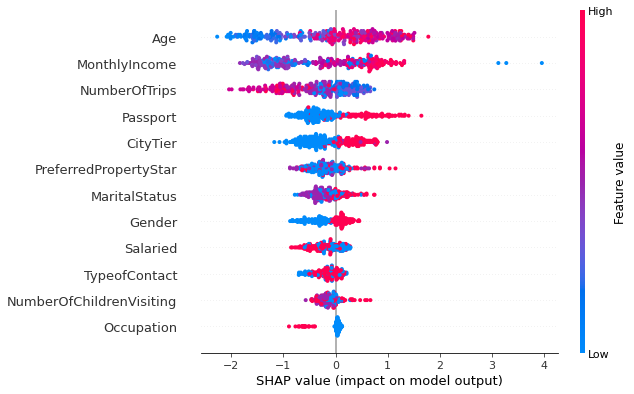

In [418]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)